In [24]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Standard plotly imports
#import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
#import cufflinks
#import cufflinks as cf
import plotly.figure_factory as ff

# Using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)
#cufflinks.go_offline(connected=True)

from sklearn import datasets, linear_model, metrics 
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

## Hyperopt modules
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial

import os
import gc
#print(os.listdir("../input"))


In [28]:
test_identity = pd.read_csv("test_identity.csv")
test_transaction = pd.read_csv("test_transaction.csv")
train_identity = pd.read_csv("train_identity.csv")
train_transaction = pd.read_csv("train_transaction.csv")

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [29]:
test_identity = reduce_mem_usage(test_identity)
test_transaction = reduce_mem_usage(test_transaction)
train_identity = reduce_mem_usage(train_identity)
train_transaction = reduce_mem_usage(train_transaction)

Mem. usage decreased to 25.44 Mb (42.7% reduction)
Mem. usage decreased to 472.59 Mb (68.9% reduction)


### Getting an ides of the structure of the data 

In [5]:
print("There are {} rows and {}columns in the test_identity data".format(test_identity.shape[0], test_identity.shape[1]))
print("There are {} rows and {}columns in the train_identity data".format(train_identity.shape[0], train_identity.shape[1]))
print("There are {} rows and {}columns in the test_transaction data".format(test_transaction.shape[0], test_transaction.shape[1]))
print("There are {} rows and {}columns in the train_transaction data".format(train_transaction.shape[0], train_transaction.shape[1]))

There are 141907 rows and 41columns in the test_identity data
There are 144233 rows and 41columns in the train_identity data
There are 506691 rows and 393columns in the test_transaction data
There are 590540 rows and 394columns in the train_transaction data


In [6]:
print("There are {} Transation ID's in test_identity data".format(len(test_identity['TransactionID'].unique())))
print("There are {} Transation ID's in train_identity data".format(len(train_identity['TransactionID'].unique())))
print("There are {} Transation ID's in test_transaction data".format(len(test_transaction['TransactionID'].unique())))
print("There are {} Transation ID's in train_transaction data".format(len(train_transaction['TransactionID'].unique())))

There are 141907 Transation ID's in test_identity data
There are 144233 Transation ID's in train_identity data
There are 506691 Transation ID's in test_transaction data
There are 590540 Transation ID's in train_transaction data


The 4 datasets are unique at TransactionID level.  

### Looking at the first few rows of the data

In [7]:
test_identity.head()

TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
0        3663586  -45.0  280290.0    NaN    NaN    0.0    0.0    NaN    NaN   
1        3663588    0.0    3579.0    0.0    0.0    0.0    0.0    NaN    NaN   
2        3663597   -5.0  185210.0    NaN    NaN    1.0    0.0    NaN    NaN   
3        3663601  -45.0  252944.0    0.0    0.0    0.0    0.0    NaN    NaN   
4        3663602  -95.0  328680.0    NaN    NaN    7.0  -33.0    NaN    NaN   

   id_09  ...                    id_31  id_32     id_33           id_34  \
0    NaN  ...  chrome 67.0 for android    NaN       NaN             NaN   
1    0.0  ...  chrome 67.0 for android   24.0  1280x720  match_status:2   
2    NaN  ...       ie 11.0 for tablet    NaN       NaN             NaN   
3    0.0  ...  chrome 67.0 for android    NaN       NaN             NaN   
4    NaN  ...  chrome 67.0 for android    NaN       NaN             NaN   

   id_35 id_36 id_37  id_38  DeviceType                   DeviceInfo  
0      F     F     T      F      mobile  MYA-L13 Build/HUAWEIMYA-L13  
1      T     F     T      T      mobile         LGLS676 Build/MXB48T  
2      F     T     T      F     desktop                  Trident/7.0  
3      F     F     T      F      mobile  MYA-L13 Build/HUAWEIMYA-L13  
4      F     F     T      F      mobile         SM-G9650 Build/R16NW  

[5 rows x 41 columns]

In [24]:
test_transaction.head()

TransactionID  TransactionDT  TransactionAmt ProductCD  card1  card2  \
0        3663549       18403224           31.95         W  10409  111.0   
1        3663550       18403263           49.00         W   4272  111.0   
2        3663551       18403310          171.00         W   4476  574.0   
3        3663552       18403310          284.95         W  10989  360.0   
4        3663553       18403317           67.95         W  18018  452.0   

   card3       card4  card5  card6  ...  V330  V331  V332  V333 V334 V335  \
0  150.0        visa  226.0  debit  ...   NaN   NaN   NaN   NaN  NaN  NaN   
1  150.0        visa  226.0  debit  ...   NaN   NaN   NaN   NaN  NaN  NaN   
2  150.0        visa  226.0  debit  ...   NaN   NaN   NaN   NaN  NaN  NaN   
3  150.0        visa  166.0  debit  ...   NaN   NaN   NaN   NaN  NaN  NaN   
4  150.0  mastercard  117.0  debit  ...   NaN   NaN   NaN   NaN  NaN  NaN   

   V336  V337  V338  V339  
0   NaN   NaN   NaN   NaN  
1   NaN   NaN   NaN   NaN  
2   NaN   NaN   NaN   NaN  
3   NaN   NaN   NaN   NaN  
4   NaN   NaN   NaN   NaN  

[5 rows x 393 columns]

In [25]:
train_identity.head()

TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
0        2987004    0.0   70787.0    NaN    NaN    NaN    NaN    NaN    NaN   
1        2987008   -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN    NaN   
2        2987010   -5.0  191631.0    0.0    0.0    0.0    0.0    NaN    NaN   
3        2987011   -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN    NaN   
4        2987016    0.0    7460.0    0.0    0.0    1.0    0.0    NaN    NaN   

   id_09  ...                id_31  id_32      id_33           id_34  id_35  \
0    NaN  ...  samsung browser 6.2   32.0  2220x1080  match_status:2      T   
1    NaN  ...   mobile safari 11.0   32.0   1334x750  match_status:1      T   
2    0.0  ...          chrome 62.0    NaN        NaN             NaN      F   
3    NaN  ...          chrome 62.0    NaN        NaN             NaN      F   
4    0.0  ...          chrome 62.0   24.0   1280x800  match_status:2      T   

  id_36 id_37  id_38  DeviceType                     DeviceInfo  
0     F     T      T      mobile  SAMSUNG SM-G892A Build/NRD90M  
1     F     F      T      mobile                     iOS Device  
2     F     T      T     desktop                        Windows  
3     F     T      T     desktop                            NaN  
4     F     T      T     desktop                          MacOS  

[5 rows x 41 columns]

In [26]:
train_transaction.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ... V330  V331  V332  V333  V334 V335  \
0    NaN  150.0    discover  142.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
1  404.0  150.0  mastercard  102.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
2  490.0  150.0        visa  166.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
3  567.0  150.0  mastercard  117.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
4  514.0  150.0  mastercard  102.0  ...  0.0   0.0   0.0   0.0   0.0  0.0   

  V336  V337  V338  V339  
0  NaN   NaN   NaN   NaN  
1  NaN   NaN   NaN   NaN  
2  NaN   NaN   NaN   NaN  
3  NaN   NaN   NaN   NaN  
4  0.0   0.0   0.0   0.0  

[5 rows x 394 columns]

### Merging the Identity and Transaction data sets 

In [30]:
df_train = train_transaction.merge(train_identity, how = 'left', left_index=True,right_index=True, on = "TransactionID")
df_test = test_transaction.merge(test_identity, how = 'left', left_index=True,right_index=True, on = "TransactionID")

In [31]:
#Deleting orignal data sets which were imported to free up some memory as they are no longer needed
del train_transaction,train_identity,test_identity,test_transaction

In [9]:
print("Training data as {} rows and {} columns".format(df_train.shape[0],df_train.shape[1]))
print("Testing data as {} rows and {} columns".format(df_test.shape[0],df_test.shape[1]))

Training data as 590540 rows and 434 columns
Testing data as 506691 rows and 433 columns


In [10]:
pd.set_option('display.max_rows', 1500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [20]:
df_train.describe()

TransactionID        isFraud  TransactionDT  TransactionAmt          card1          card2          card3          card5          addr1          addr2          dist1         dist2             C1             C2             C3             C4             C5             C6             C7             C8             C9            C10            C11            C12            C13            C14             D1             D2             D3             D4             D5            D6            D7            D8            D9            D10            D11           D12           D13           D14            D15             V1             V2             V3             V4             V5             V6             V7             V8             V9            V10            V11            V12            V13            V14            V15            V16            V17            V18            V19            V20            V21            V22            V23            V24            V25  \
count   5.905400e+05  590540.000000   5.905400e+05   590540.000000  590540.000000  581607.000000  588975.000000  586281.000000  524834.000000  524834.000000  238269.000000  37627.000000  590540.000000  590540.000000  590540.000000  590540.000000  590540.000000  590540.000000  590540.000000  590540.000000  590540.000000  590540.000000  590540.000000  590540.000000  590540.000000  590540.000000  589271.000000  309743.000000  327662.000000  421618.000000  280699.000000  73187.000000  38917.000000  74926.000000  74926.000000  514518.000000  311253.000000  64717.000000  61952.000000  62187.000000  501427.000000  311253.000000  311253.000000  311253.000000  311253.000000  311253.000000  311253.000000  311253.000000  311253.000000  311253.000000  311253.000000  311253.000000  514467.000000  514467.000000  514467.000000  514467.000000  514467.000000  514467.000000  514467.000000  514467.000000  514467.000000  514467.000000  514467.000000  514467.000000  514467.000000  514467.000000   
mean    3.282270e+06       0.034990   7.372311e+06      135.027176    9898.734658     362.555488     153.194925     199.278897     290.733794      86.800630     118.502180    231.855423      14.092458      15.269734       0.005644       4.092185       5.571526       9.071082       2.848478       5.144574       4.480240       5.240343      10.241521       4.076227      32.539918       8.295215      94.347568     169.563231      28.343348     140.002441      42.335965     69.805717     41.638950    146.058108      0.561057     123.982137     146.621465     54.037533     17.901295     57.724444     163.744579       0.999945       1.045204       1.078075       0.846456       0.876991       1.045686       1.072870       1.027704       1.041529       0.463915       0.478987       0.559711       0.599166       0.999500       0.122342       0.123460       0.134040       0.135363       0.816371       0.847843       0.129684       0.132292       1.034791       1.058097       0.977660   
std     1.704744e+05       0.183755   4.617224e+06      239.162522    4901.170153     157.793246      11.336444      41.244453     101.741072       2.690623     371.872026    529.053494     133.569018     154.668899       0.150536      68.848459      25.786976      71.508467      61.727304      95.378574      16.674897      95.581443      94.336292      86.666218     129.364844      49.544262     157.660387     177.315865      62.384721     191.096774      89.000144    143.669253     99.743264    231.663840      0.316880     182.615225     186.042622    124.274558     67.614425    136.312450     202.726660       0.007390       0.240133       0.320890       0.440053       0.475902       0.239385       0.304779       0.186069       0.226339       0.521522       0.552431       0.510533       0.532185       0.022345       0.332422       0.342841       0.364456       0.371763       0.425512       0.459451       0.339060       0.359415       0.247681       0.305485       0.185245   
min     2.987000e+06       0.000000   8

In [14]:
df_test.describe()

TransactionID  TransactionDT  TransactionAmt          card1          card2          card3          card5          addr1          addr2          dist1         dist2             C1             C2             C3             C4             C5             C6             C7             C8             C9            C10            C11            C12            C13            C14             D1             D2             D3             D4             D5             D6            D7            D8            D9            D10            D11           D12            D13            D14            D15             V1             V2             V3             V4             V5             V6             V7             V8             V9            V10            V11            V12            V13            V14            V15            V16            V17            V18            V19            V20            V21            V22            V23            V24            V25            V26  \
count   5.066910e+05   5.066910e+05   506691.000000  506691.000000  498037.000000  503689.000000  502144.000000  441082.000000  441082.000000  215474.000000  36436.000000  506688.000000  506688.000000  506688.000000  506688.000000  506688.000000  506688.000000  506688.000000  506688.000000  506688.000000  506688.000000  506688.000000  506688.000000  501943.000000  506688.000000  500660.000000  271922.000000  303549.000000  429840.000000  282316.000000  124783.000000  60133.000000  74338.000000  74338.000000  494146.000000  330173.000000  69254.000000  123384.000000  115194.000000  494622.000000  330173.000000  330173.000000  330173.000000  330173.000000  330173.000000  330173.000000  330173.000000  330173.000000  330173.000000  330173.000000  330173.000000  494102.000000  494102.000000  494102.000000  494102.000000  494102.000000  494102.000000  494102.000000  494102.000000  494102.000000  494102.000000  494102.000000  494102.000000  494102.000000  494102.000000  494102.000000   
mean    3.916894e+06   2.692994e+07      134.725568    9957.222175     363.735379     153.543409     200.162975     291.846514      86.723412      87.065270    237.175047      10.093211      10.714635       0.027403       2.385875       4.962701       6.854992       1.678173       1.893994       4.611943       1.810149       7.484594       2.649486      27.816035       6.083890     108.207504     188.666621      33.394727     175.060799      50.977752      82.443145     61.815642    160.834483      0.553981     159.810552     218.414895     77.404179      18.225961      58.163186     206.854137       0.999997       1.046636       1.087436       0.850563       0.884697       1.045940       1.079207       1.022779       1.039876       0.456621       0.473873       0.569816       0.600435       0.999846       0.140963       0.142317       0.259778       0.261657       0.861490       0.885503       0.249799       0.254431       1.045493       1.069415       1.004693       1.012959   
std     1.462692e+05   4.756507e+06      245.779822    4884.960969     158.688653      12.443013      40.562461     102.062730       2.987328     314.131694    556.450834      79.334782      88.896921       0.227753      41.942977      25.462195      46.783565      37.874827      26.766115      21.282640      23.692393      61.322505      53.973060     101.114033      28.315616     176.964526     197.099611      82.558210     250.417470     116.829786     192.867671    150.299612    257.003738      0.317327     240.566557     253.091693    176.218548      78.079890     164.015525     269.419196       0.001740       0.250847       0.359033       0.427938       0.483297       0.244112       0.330086       0.174533       0.226182       0.523406       0.558754       0.508138       0.536276       0.012401       0.361034       0.379262       0.461083       0.467456       0.392307       0.436220       0.438383       0.464469       0.289516       0.371149       0.133895       0.189354   
min     3.663549e+06   1.84

### Checking the Distribution of categorical data with respect to the number of frauds per category of a variable

In [21]:
df_train.describe(exclude=[np.number])

ProductCD   card4   card6 P_emaildomain R_emaildomain      M1      M2      M3      M4      M5      M6      M7      M8      M9     id_12   id_15   id_16                 id_23  id_27   id_28   id_29       id_30        id_31      id_33           id_34   id_35   id_36   id_37   id_38 DeviceType DeviceInfo
count     590540  588963  588969        496084        137291  319440  319440  319440  309096  240058  421180  244275  244288  244288    144233  140985  129340                  5169   5169  140978  140978       77565       140282      73289           77805  140985  140985  140985  140985     140810     118666
unique         5       4       4            59            60       2       2       2       3       2       2       2       2       2         2       3       2                     3      2       2       2          75          130        260               4       2       2       2       2          2       1786
top            W    visa   debit     gmail.com     gmail.com       T       T       T      M0       F       F       F       F       T  NotFound   Found   Found  IP_PROXY:TRANSPARENT  Found   Found   Found  Windows 10  chrome 63.0  1920x1080  match_status:2       T       F       T       F    desktop    Windows
freq      439670  384767  439938        228355         57147  319415  285468  251731  196405  132491  227856  211374  155251  205656    123025   67728   66324                  3489   5155   76232   74926       21155        22000      16874           60011   77814  134066  110452   73922      85165      47722

### Checking the Data for missing Values

In [11]:
#CHecking for Missing data 
data_null = df_train.isnull().sum()/len(df_train)*100
data_null = data_null.drop(data_null[data_null==0].index).sort_values(ascending=False)[:500]
missing_data = pd.DataFrame({'Missing Ratio':data_null})
missing_data.head()

Missing Ratio
id_24      99.196159
id_25      99.130965
id_07      99.127070
id_08      99.127070
id_21      99.126393

In [12]:
missing_data.shape

(414, 1)

### Creating a list of columns which have high percentage of missing values or repeated values

In [7]:
#Function to remove missing columns
def cal_null_values(data):
    null_cols = [col for col in data.columns if data[col].isnull().sum()/data.shape[0]>0.9]
    return null_cols

#FUnction to remove repeated values
def cal_repeat_values(data):
    rep_values = [col for col in data.columns if data[col].value_counts(dropna = False,normalize = True).values[0]>0.9]
    return rep_values
#Creating a ist of variables to be dropped from the data 
def drop_columns(data):
    too_many_null = cal_null_values(data)
    print("More than 90% null: " +str(len(too_many_null)))
    too_many_repeated = cal_repeat_values(data)
    print("More than 90% repeated: " +str(len(too_many_repeated)))
    cols_to_drop = list(set(too_many_null+too_many_repeated))
    cols_to_drop.remove('isFraud')
    return cols_to_drop

In [8]:
#Columns to drop
cols_todrop = drop_columns(df_train)

More than 90% null: 12
More than 90% repeated: 67


In [9]:
df_train = df_train.drop(cols_todrop, axis=1)
df_test = df_test.drop(cols_todrop, axis=1)

### Exploring Categorical Variables of the data

In [16]:
#Creating a list of categorical data in the training set 
cols = df_train.columns
num_cols=df_train._get_numeric_data().columns
cat_cols = list(set(cols)-set(num_cols))
#cat_cols.append('isFraud')

<Figure size 432x288 with 0 Axes>

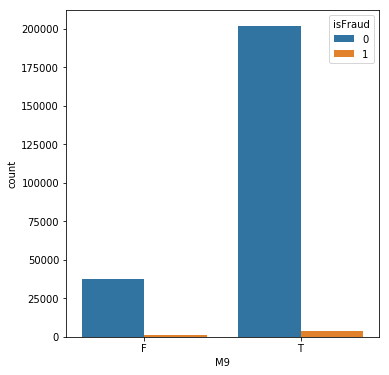

<Figure size 432x288 with 0 Axes>

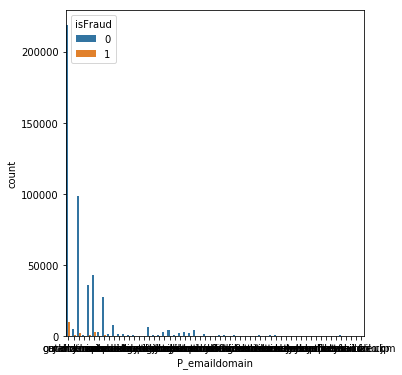

<Figure size 432x288 with 0 Axes>

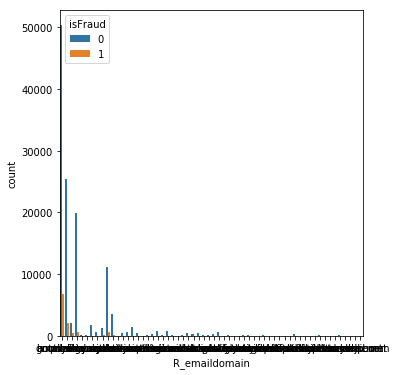

<Figure size 432x288 with 0 Axes>

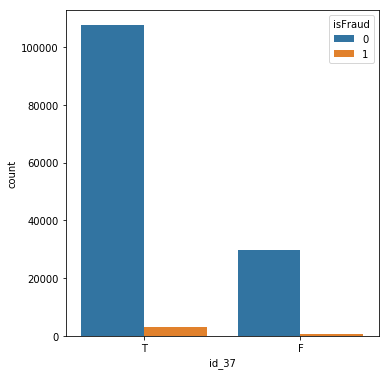

<Figure size 432x288 with 0 Axes>

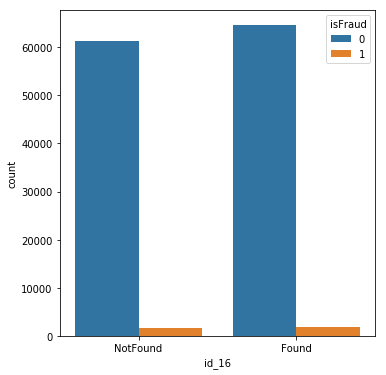

<Figure size 432x288 with 0 Axes>

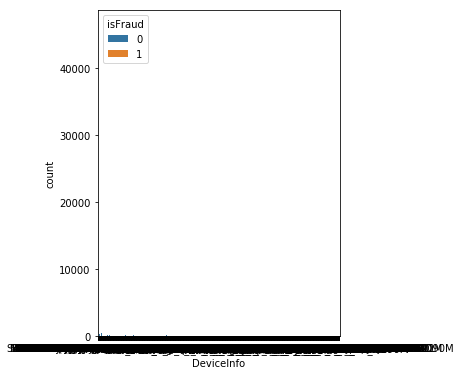

<Figure size 432x288 with 0 Axes>

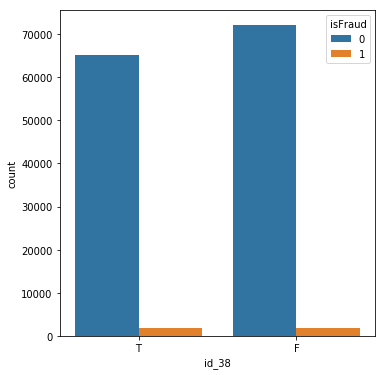

<Figure size 432x288 with 0 Axes>

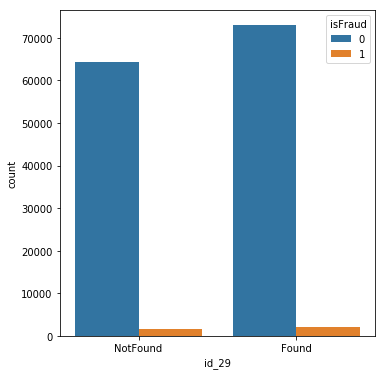

<Figure size 432x288 with 0 Axes>

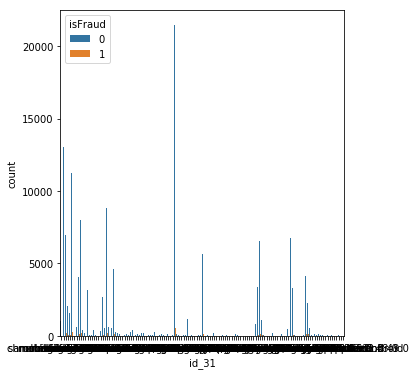

<Figure size 432x288 with 0 Axes>

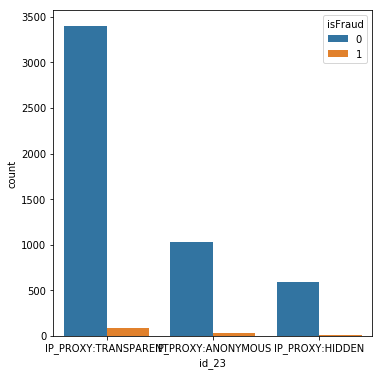

<Figure size 432x288 with 0 Axes>

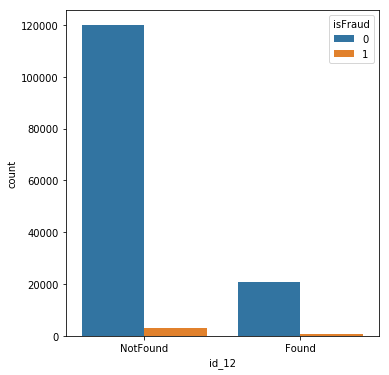

<Figure size 432x288 with 0 Axes>

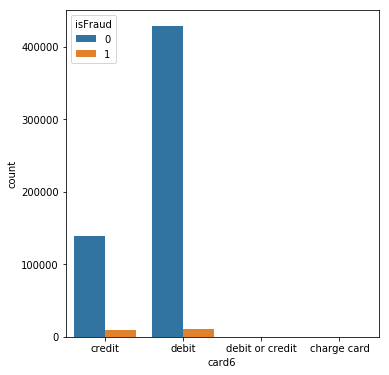

<Figure size 432x288 with 0 Axes>

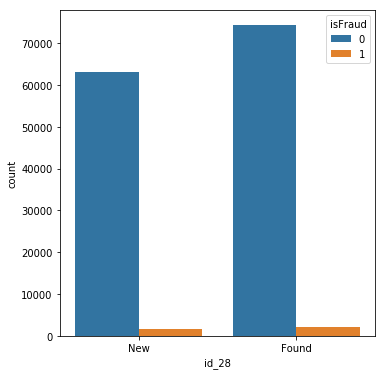

<Figure size 432x288 with 0 Axes>

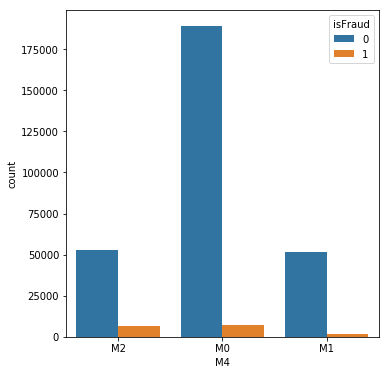

<Figure size 432x288 with 0 Axes>

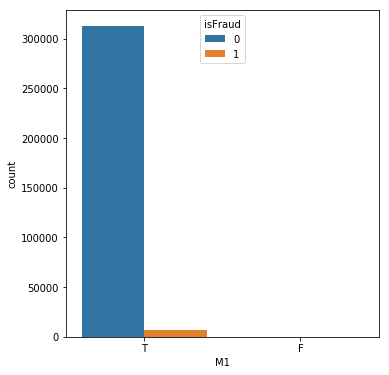

<Figure size 432x288 with 0 Axes>

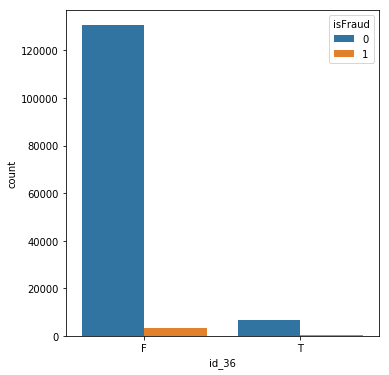

<Figure size 432x288 with 0 Axes>

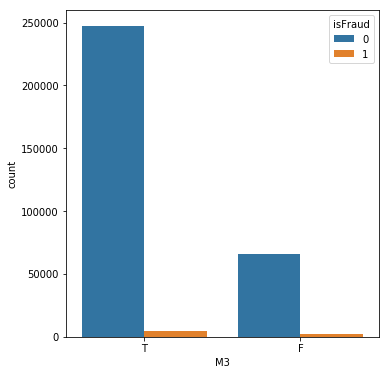

<Figure size 432x288 with 0 Axes>

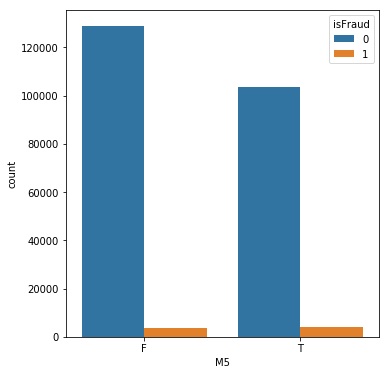

<Figure size 432x288 with 0 Axes>

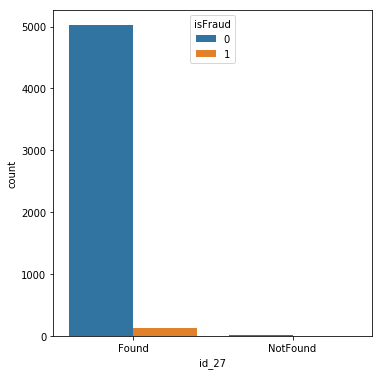

<Figure size 432x288 with 0 Axes>

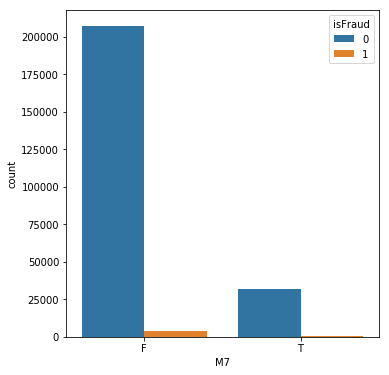

<Figure size 432x288 with 0 Axes>

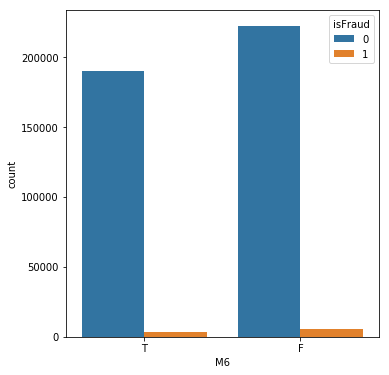

<Figure size 432x288 with 0 Axes>

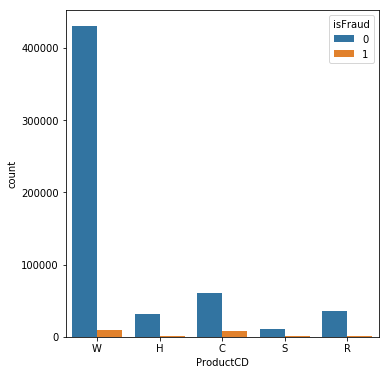

<Figure size 432x288 with 0 Axes>

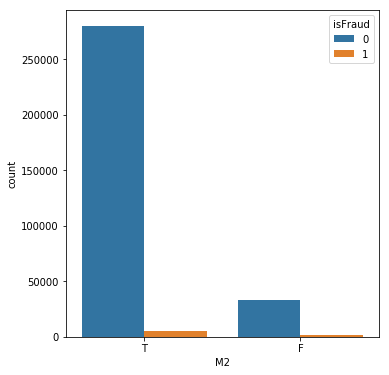

<Figure size 432x288 with 0 Axes>

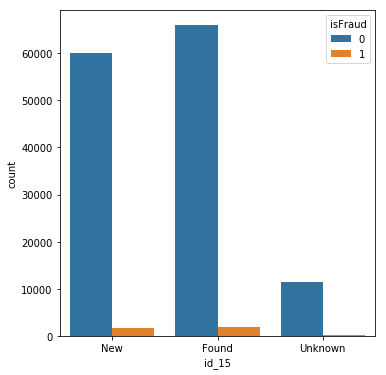

<Figure size 432x288 with 0 Axes>

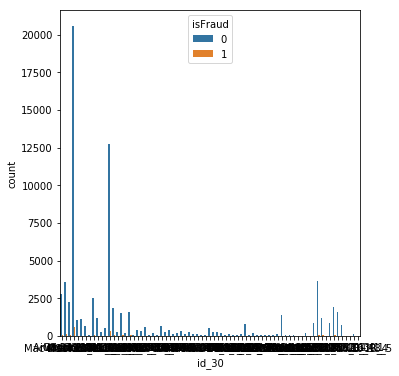

<Figure size 432x288 with 0 Axes>

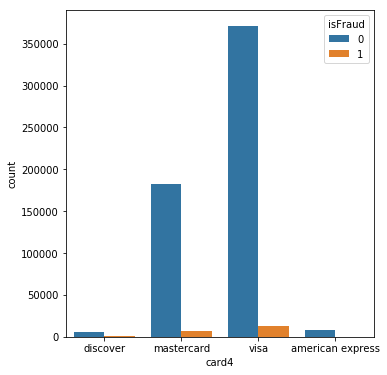

<Figure size 432x288 with 0 Axes>

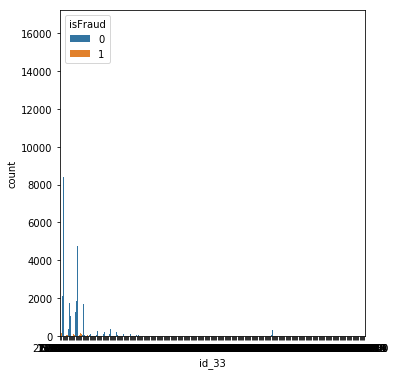

<Figure size 432x288 with 0 Axes>

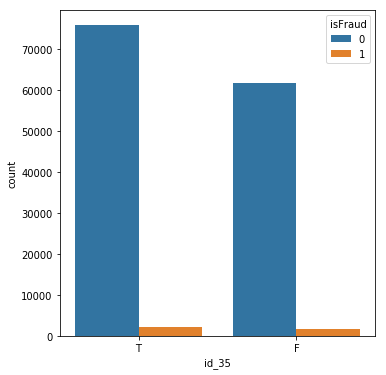

<Figure size 432x288 with 0 Axes>

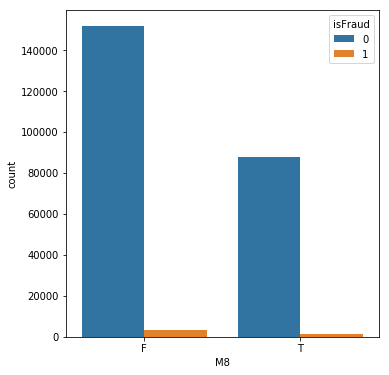

<Figure size 432x288 with 0 Axes>

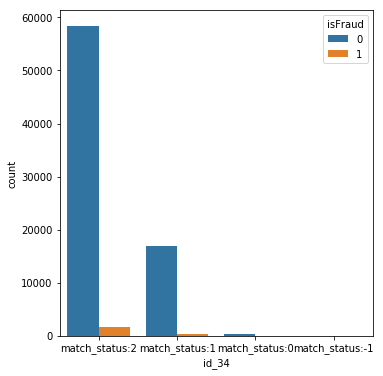

<Figure size 432x288 with 0 Axes>

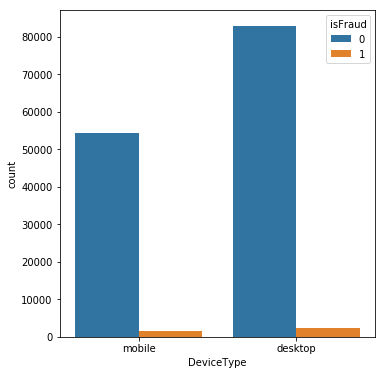

<Figure size 432x288 with 0 Axes>

In [25]:
#Plotting the Categorical variables with respect to fraud or not fraud
plt.figure()
for feature in cat_cols:
              
        fig = plt.figure(figsize=(10,10))
        g = sns.countplot(x=feature, data = df_train)
        g.set_title(feature, fontsize = 22)
        g.set_ylim(0,420000)
        g.set_xlabel(feature, fontsize=19)
        g.set_ylabel("Count", fontsize=17)
        plt.subplot(222)
        g1=sns.countplot(x=feature, hue ='isFraud',data = df_train)
        plt.legend(title = 'Fraud', loc = 'best', labels = ['No','Yes'])
        plt.tight_layout()
        plt.show()
        plt.clf()

In [13]:
#Checking only fraud cases in training data
train_fraud =df_train[df_train['isFraud']==1]

<Figure size 432x288 with 0 Axes>

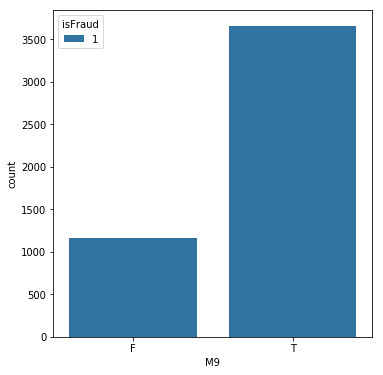

<Figure size 432x288 with 0 Axes>

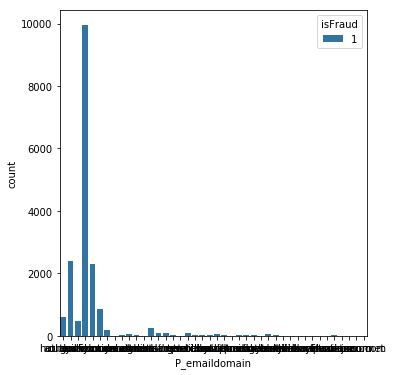

<Figure size 432x288 with 0 Axes>

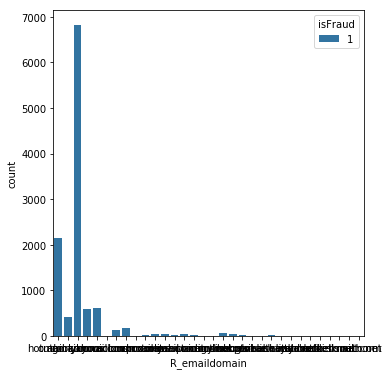

<Figure size 432x288 with 0 Axes>

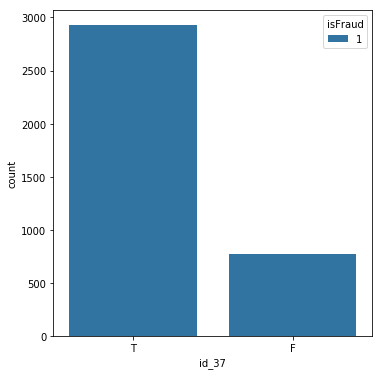

<Figure size 432x288 with 0 Axes>

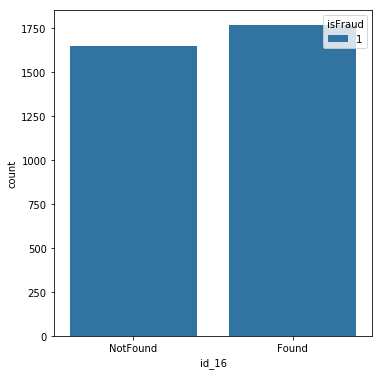

<Figure size 432x288 with 0 Axes>

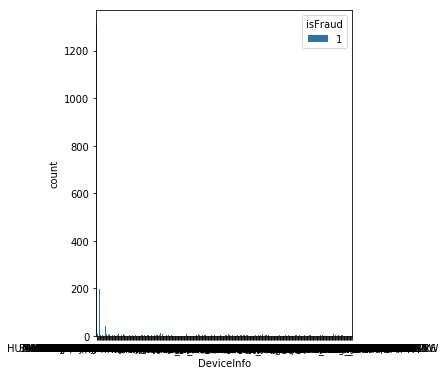

<Figure size 432x288 with 0 Axes>

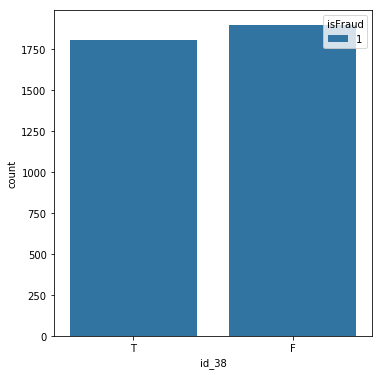

<Figure size 432x288 with 0 Axes>

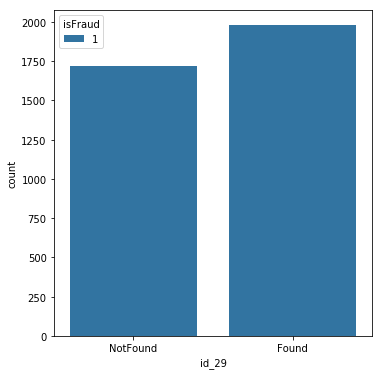

<Figure size 432x288 with 0 Axes>

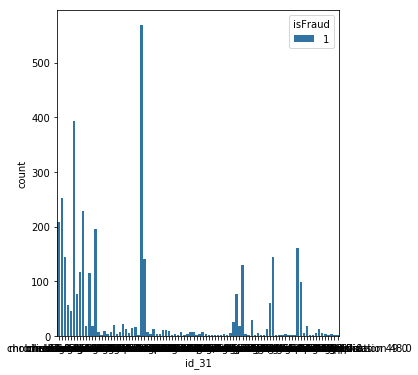

<Figure size 432x288 with 0 Axes>

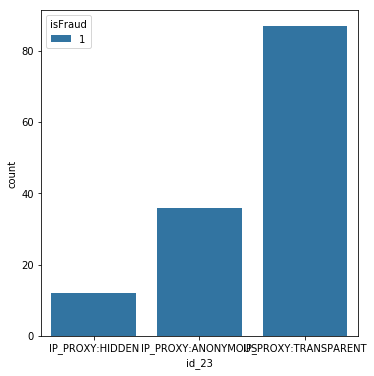

<Figure size 432x288 with 0 Axes>

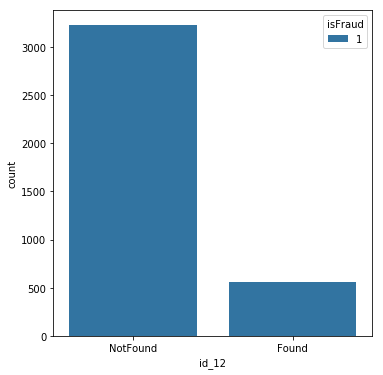

<Figure size 432x288 with 0 Axes>

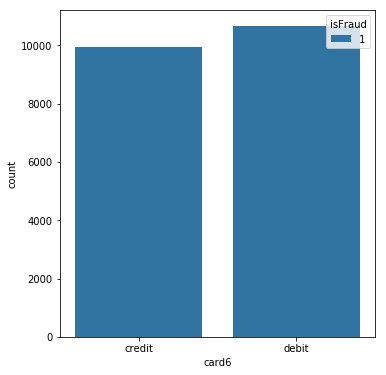

<Figure size 432x288 with 0 Axes>

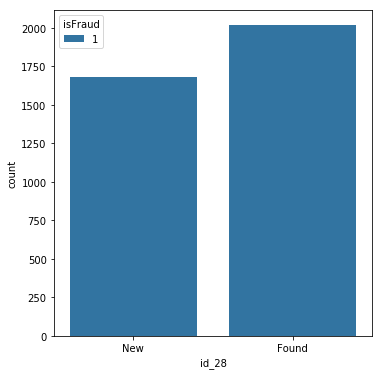

<Figure size 432x288 with 0 Axes>

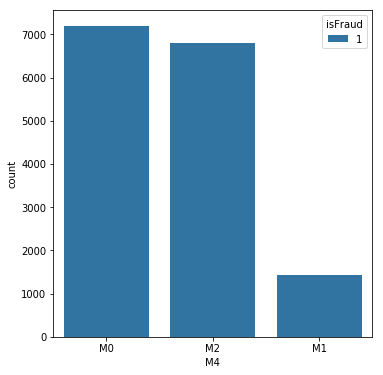

<Figure size 432x288 with 0 Axes>

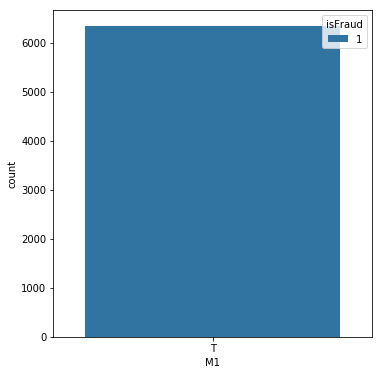

<Figure size 432x288 with 0 Axes>

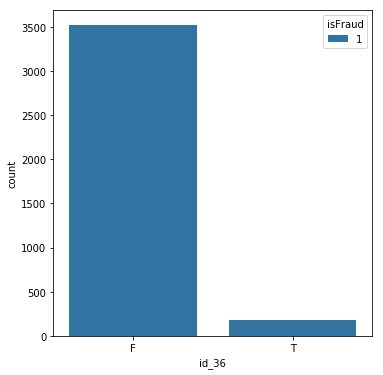

<Figure size 432x288 with 0 Axes>

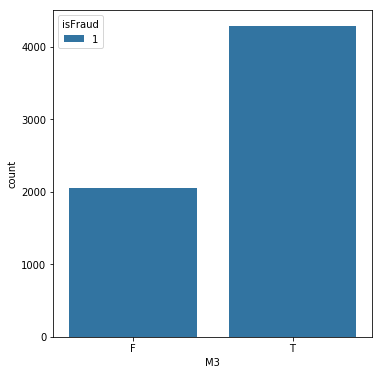

<Figure size 432x288 with 0 Axes>

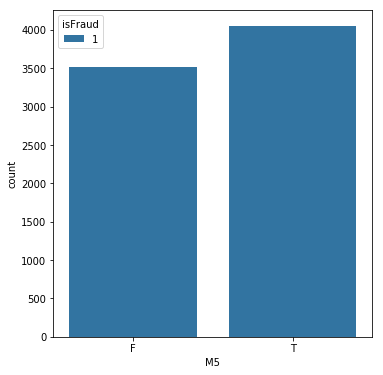

<Figure size 432x288 with 0 Axes>

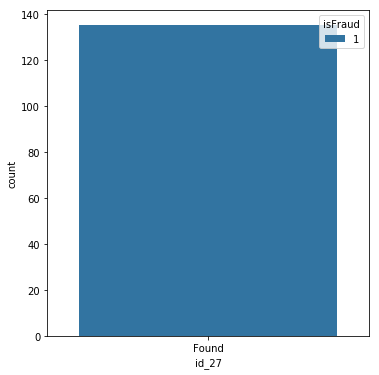

<Figure size 432x288 with 0 Axes>

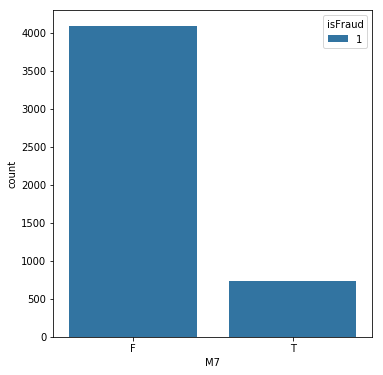

<Figure size 432x288 with 0 Axes>

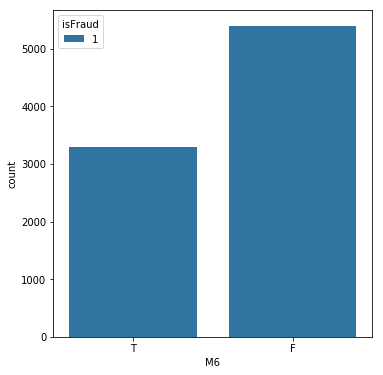

<Figure size 432x288 with 0 Axes>

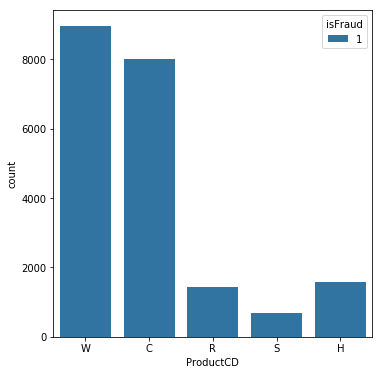

<Figure size 432x288 with 0 Axes>

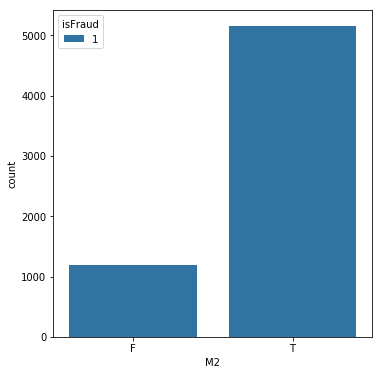

<Figure size 432x288 with 0 Axes>

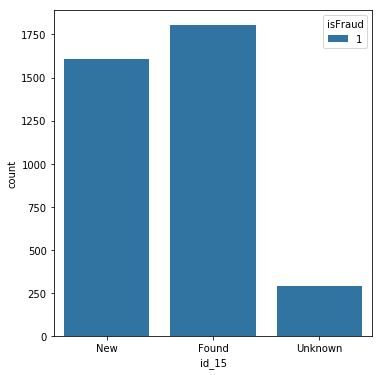

<Figure size 432x288 with 0 Axes>

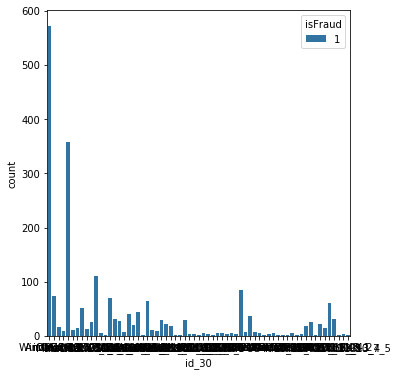

<Figure size 432x288 with 0 Axes>

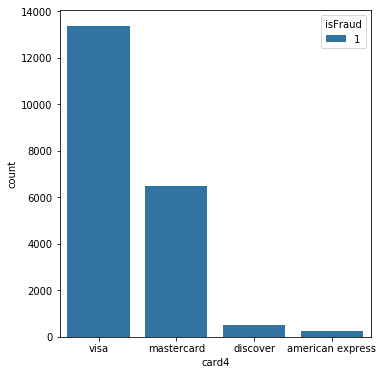

<Figure size 432x288 with 0 Axes>

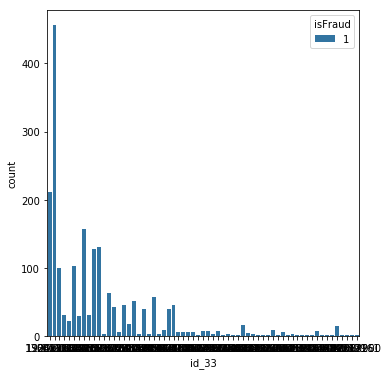

<Figure size 432x288 with 0 Axes>

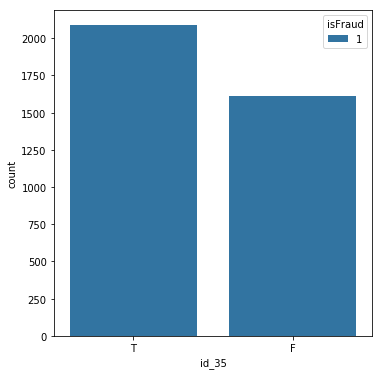

<Figure size 432x288 with 0 Axes>

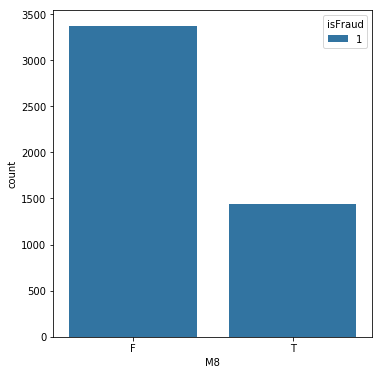

<Figure size 432x288 with 0 Axes>

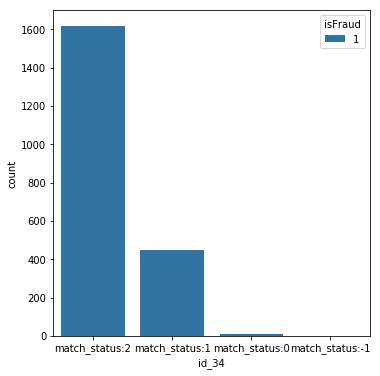

<Figure size 432x288 with 0 Axes>

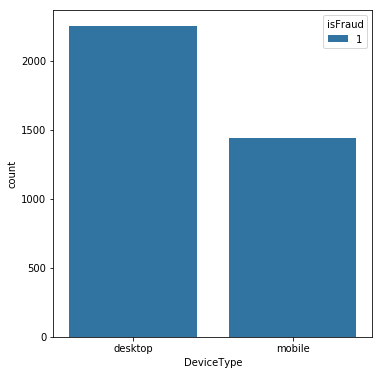

<Figure size 432x288 with 0 Axes>

In [27]:
#Plotting the Categorical variables with respect to fraud or not fraud
plt.figure()
for feature in cat_cols:
              
        fig = plt.figure(figsize=(10,10))
        g = sns.countplot(x=feature, data = train_fraud)
        g.set_title(feature, fontsize = 22)
        g.set_ylim(0,420000)
        g.set_xlabel(feature, fontsize=19)
        g.set_ylabel("Count", fontsize=17)
        plt.subplot(222)
        g1=sns.countplot(x=feature, hue ='isFraud',data = train_fraud)
        #plt.legend(title = 'Fraud', loc = 'best', labels = ['No','Yes'])
        plt.tight_layout()
        plt.show()
        plt.clf()

### Having a look at the variables Card1,Card2,Card3,Card5 variables 

Text(0, 0.5, 'Card5 Values')

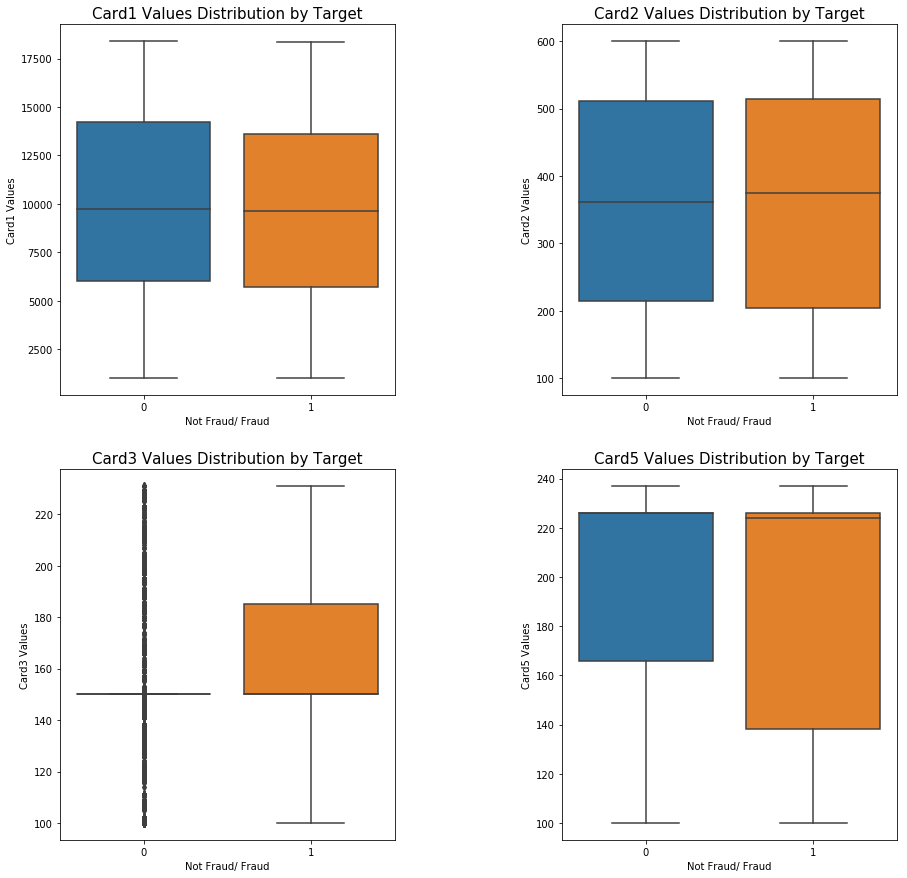

In [110]:
fig, axes =plt.subplots(figsize=(15,15), ncols=2, nrows=2)
plt.subplots_adjust(wspace  =  0.5 #the amount of width reserved for blank space between subplots
                    ,hspace  =  0.2 # the amount of height reserved for white space between subplots
                   )

g = sns.boxplot(x='isFraud',y='card1',data=df_train, ax=axes[0][0])
g.set_title("Card1 Values Distribution by Target", fontsize=15)
g.set_xlabel("Not Fraud/ Fraud", fontsize=10)
g.set_ylabel("Card1 Values", fontsize=10)


g = sns.boxplot(x='isFraud',y='card2',data=df_train, ax=axes[0][1])
g.set_title("Card2 Values Distribution by Target", fontsize=15)
g.set_xlabel("Not Fraud/ Fraud", fontsize=10)
g.set_ylabel("Card2 Values", fontsize=10)


g = sns.boxplot(x='isFraud',y='card3',data=df_train, ax=axes[1][0])
g.set_title("Card3 Values Distribution by Target", fontsize=15)
g.set_xlabel("Not Fraud/ Fraud", fontsize=10)
g.set_ylabel("Card3 Values", fontsize=10)


g = sns.boxplot(x='isFraud',y='card5',data=df_train, ax=axes[1][1])
g.set_title("Card5 Values Distribution by Target", fontsize=15)
g.set_xlabel("Not Fraud/ Fraud", fontsize=10)
g.set_ylabel("Card5 Values", fontsize=10)

Looks like most of the values of card3 are around 150. Card3 needs to be explored further.

In [132]:
#Getting the basic statistics of card3
(df_train['card3']).describe()

count    588975.0
mean          NaN
std           0.0
min         100.0
25%         150.0
50%         150.0
75%         150.0
max         231.0
Name: card3, dtype: float64

In [ ]:
#checking for duplicate values of card3
dup_counts = pd.DataFrame(df_train['card3'].value_counts()).sort_values(by = 'card3',ascending=False)
dup_counts['Per'] = dup_counts['card3']/df_train.shape[0]
dup_counts.head(10)

For card3 almost 90% values are 150 and 9% values are 185

In [17]:
#Getting the distribution of values for card3 with respect to the dependent variable
df_train.pivot_table(index='card3',columns='isFraud',values='TransactionID',aggfunc='count').sort_values(by =1, ascending = False)

isFraud         0        1
card3                     
150.0    508480.0  12807.0
185.0     48984.0   7362.0
144.0      1140.0    112.0
119.0       680.0     70.0
143.0       871.0     28.0
146.0      1227.0     25.0
106.0      1547.0     24.0
117.0       944.0     18.0
223.0        41.0     14.0
134.0       155.0     11.0
102.0       449.0     11.0
100.0       192.0     10.0
147.0       383.0      7.0
191.0        11.0      7.0
182.0        32.0      7.0
203.0       247.0      6.0
198.0        25.0      6.0
214.0        60.0      6.0
135.0       114.0      6.0
188.0       169.0      6.0
121.0        94.0      5.0
142.0        35.0      5.0
133.0        46.0      4.0
127.0        24.0      4.0
118.0        13.0      4.0
210.0       101.0      3.0
213.0       218.0      3.0
181.0         NaN      3.0
162.0       336.0      3.0
160.0         NaN      3.0
137.0        68.0      3.0
141.0        46.0      3.0
159.0        80.0      2.0
131.0       170.0      2.0
206.0         NaN      2.0
138.0        68.0      2.0
129.0         7.0      2.0
149.0       125.0      2.0
177.0        31.0      2.0
200.0       182.0      2.0
125.0         NaN      1.0
215.0        43.0      1.0
126.0        22.0      1.0
219.0         8.0      1.0
111.0        38.0      1.0
224.0         NaN      1.0
208.0         1.0      1.0
229.0       117.0      1.0
204.0        50.0      1.0
197.0        80.0      1.0
132.0         NaN      1.0
157.0         4.0      1.0
195.0       100.0      1.0
139.0         NaN      1.0
183.0         8.0      1.0
180.0        12.0      1.0
175.0         NaN      1.0
168.0        10.0      1.0
167.0         3.0      1.0
166.0        46.0      1.0
155.0         2.0      1.0
231.0         5.0      1.0
101.0         1.0      NaN
105.0         3.0      NaN
107.0         6.0      NaN
108.0         5.0      NaN
109.0         8.0      NaN
114.0         1.0      NaN
116.0         8.0      NaN
120.0         6.0      NaN
122.0         4.0      NaN
123.0         3.0      NaN
124.0         3.0      NaN
128.0         7.0      NaN
130.0        10.0      NaN
136.0         3.0      NaN
148.0        61.0      NaN
151.0         5.0      NaN
152.0        13.0      NaN
153.0         5.0      NaN
156.0         6.0      NaN
161.0         8.0      NaN
163.0         9.0      NaN
164.0         1.0      NaN
169.0         7.0      NaN
170.0         1.0      NaN
171.0        10.0      NaN
172.0         1.0      NaN
173.0         1.0      NaN
174.0         3.0      NaN
176.0         2.0      NaN
179.0         2.0      NaN
184.0         5.0      NaN
186.0         2.0      NaN
189.0        14.0      NaN
190.0        31.0      NaN
193.0         2.0      NaN
194.0        25.0      NaN
199.0         1.0      NaN
201.0         1.0      NaN
202.0         3.0      NaN
205.0         3.0      NaN
207.0         3.0      NaN
209.0         1.0      NaN
211.0        11.0      NaN
212.0        46.0      NaN
217.0        17.0      NaN
220.0         2.0      NaN
221.0         1.0      NaN
222.0        13.0      NaN
225.0         3.0      NaN
226.0         2.0      NaN
227.0        17.0      NaN
228.0         1.0      NaN

In [18]:
#total number of Fraud/Not Fraud cases in he training data
df_train['isFraud'].value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

The Training data has total 20663 fraud cases. 
For 12807 Cases which are fraud, the variable card3 takes value as 150
For 7362 Cases which are fraud, the variable card3 takes value as 185
97% cases where there was a fraud, card3 variable takes only 2 values

Based on the above finding, it is clear that card3 is not able to distinguish between Fraud and not fraud. 
Hence this variable can be excluded from the modelling exercise.

### Checking variables addr1 and addr2

Text(0, 0.5, 'addr22 Values')

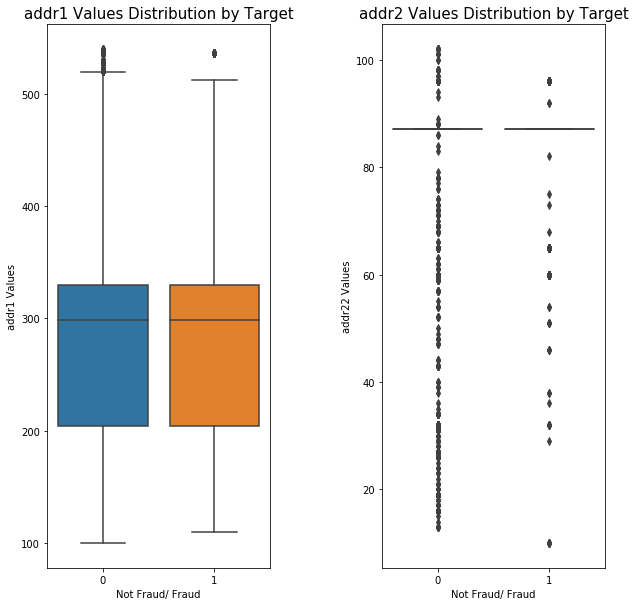

In [147]:
fig, axes =plt.subplots(figsize=(10,10), ncols=2, nrows=1)
plt.subplots_adjust(wspace  =  0.5 #the amount of width reserved for blank space between subplots
                    ,hspace  =  0.2 # the amount of height reserved for white space between subplots
                   )

g = sns.boxplot(x='isFraud',y='addr1',data=df_train, ax=axes[0])
g.set_title("addr1 Values Distribution by Target", fontsize=15)
g.set_xlabel("Not Fraud/ Fraud", fontsize=10)
g.set_ylabel("addr1 Values", fontsize=10)


g = sns.boxplot(x='isFraud',y='addr2',data=df_train, ax=axes[1])
g.set_title("addr2 Values Distribution by Target", fontsize=15)
g.set_xlabel("Not Fraud/ Fraud", fontsize=10)
g.set_ylabel("addr22 Values", fontsize=10)

### Checking C variables

Text(0, 0.5, 'C14 Values')

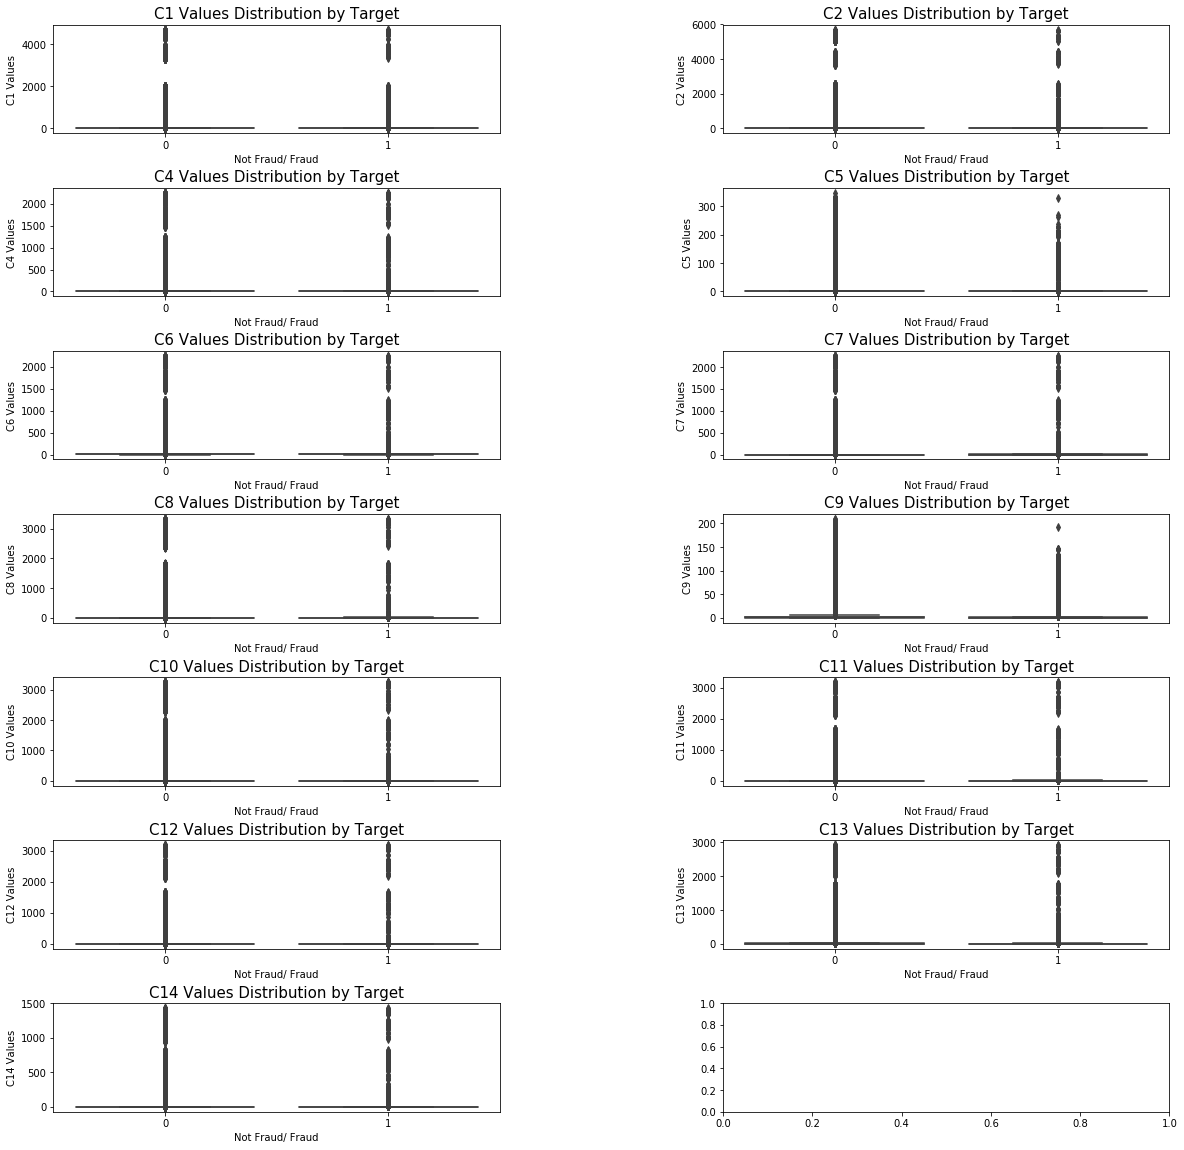

In [161]:
fig, axes =plt.subplots(figsize=(20,20), ncols=2, nrows=7)
plt.subplots_adjust(wspace  =  0.5 #the amount of width reserved for blank space between subplots
                    ,hspace  =  0.5 # the amount of height reserved for white space between subplots
                   )

g = sns.boxplot(x='isFraud',y='C1',data=df_train, ax=axes[0][0])
g.set_title("C1 Values Distribution by Target", fontsize=15)
g.set_xlabel("Not Fraud/ Fraud", fontsize=10)
g.set_ylabel("C1 Values", fontsize=10)

g = sns.boxplot(x='isFraud',y='C2',data=df_train, ax=axes[0][1])
g.set_title("C2 Values Distribution by Target", fontsize=15)
g.set_xlabel("Not Fraud/ Fraud", fontsize=10)
g.set_ylabel("C2 Values", fontsize=10)

g = sns.boxplot(x='isFraud',y='C4',data=df_train, ax=axes[1][0])
g.set_title("C4 Values Distribution by Target", fontsize=15)
g.set_xlabel("Not Fraud/ Fraud", fontsize=10)
g.set_ylabel("C4 Values", fontsize=10)

g = sns.boxplot(x='isFraud',y='C5',data=df_train, ax=axes[1][1])
g.set_title("C5 Values Distribution by Target", fontsize=15)
g.set_xlabel("Not Fraud/ Fraud", fontsize=10)
g.set_ylabel("C5 Values", fontsize=10)

g = sns.boxplot(x='isFraud',y='C6',data=df_train, ax=axes[2][0])
g.set_title("C6 Values Distribution by Target", fontsize=15)
g.set_xlabel("Not Fraud/ Fraud", fontsize=10)
g.set_ylabel("C6 Values", fontsize=10)

g = sns.boxplot(x='isFraud',y='C7',data=df_train, ax=axes[2][1])
g.set_title("C7 Values Distribution by Target", fontsize=15)
g.set_xlabel("Not Fraud/ Fraud", fontsize=10)
g.set_ylabel("C7 Values", fontsize=10)

g = sns.boxplot(x='isFraud',y='C8',data=df_train, ax=axes[3][0])
g.set_title("C8 Values Distribution by Target", fontsize=15)
g.set_xlabel("Not Fraud/ Fraud", fontsize=10)
g.set_ylabel("C8 Values", fontsize=10)

g = sns.boxplot(x='isFraud',y='C9',data=df_train, ax=axes[3][1])
g.set_title("C9 Values Distribution by Target", fontsize=15)
g.set_xlabel("Not Fraud/ Fraud", fontsize=10)
g.set_ylabel("C9 Values", fontsize=10)

g = sns.boxplot(x='isFraud',y='C10',data=df_train, ax=axes[4][0])
g.set_title("C10 Values Distribution by Target", fontsize=15)
g.set_xlabel("Not Fraud/ Fraud", fontsize=10)
g.set_ylabel("C10 Values", fontsize=10)

g = sns.boxplot(x='isFraud',y='C11',data=df_train, ax=axes[4][1])
g.set_title("C11 Values Distribution by Target", fontsize=15)
g.set_xlabel("Not Fraud/ Fraud", fontsize=10)
g.set_ylabel("C11 Values", fontsize=10)

g = sns.boxplot(x='isFraud',y='C12',data=df_train, ax=axes[5][0])
g.set_title("C12 Values Distribution by Target", fontsize=15)
g.set_xlabel("Not Fraud/ Fraud", fontsize=10)
g.set_ylabel("C12 Values", fontsize=10)

g = sns.boxplot(x='isFraud',y='C13',data=df_train, ax=axes[5][1])
g.set_title("C13 Values Distribution by Target", fontsize=15)
g.set_xlabel("Not Fraud/ Fraud", fontsize=10)
g.set_ylabel("C13 Values", fontsize=10)

g = sns.boxplot(x='isFraud',y='C14',data=df_train, ax=axes[6][0])
g.set_title("C14 Values Distribution by Target", fontsize=15)
g.set_xlabel("Not Fraud/ Fraud", fontsize=10)
g.set_ylabel("C14 Values", fontsize=10)


### It appears tht C columns also has many repeating values

In [10]:
#Getting names of Ccolumns
c_cols = [c for c in df_train if c[0] == 'C']

In [11]:
#For all C columns, getting the Frequency of the highest recurring value and the Highest recurring value
for c in c_cols:
    Unique_val = df_train[c].value_counts()[1]
    Top_Unique_values = pd.DataFrame(df_train[c].value_counts().reset_index()['index']).rename(columns={"index":"Unique_Values"})

In [21]:
#Creating a data frame showing for every C column, the most recurring value, Number of times it is recurring  
# and percentage of most recurring value of the total number of values 
C_Value_counts = pd.DataFrame()
C_Value_counts['C_Variable'] = c_cols
C_Value_counts['NO_Unique'] = Unique_val
C_Value_counts['Top_Unique_values'] = Top_Unique_values
C_Value_counts['Per_of_Total'] = C_Value_counts['NO_Unique']/df_train.shape[0]*100
C_Value_counts

C_Variable  NO_Unique  Top_Unique_values  Per_of_Total
0          C1     320189                1.0     54.219697
1          C2     320189                2.0     54.219697
2          C4     320189                3.0     54.219697
3          C5     320189                0.0     54.219697
4          C6     320189                4.0     54.219697
5          C7     320189                5.0     54.219697
6          C8     320189                6.0     54.219697
7          C9     320189                7.0     54.219697
8         C10     320189                8.0     54.219697
9         C11     320189                9.0     54.219697
10        C12     320189               10.0     54.219697
11        C13     320189               11.0     54.219697
12        C14     320189               12.0     54.219697

### Checking if V cols have the same trend as C col

In [12]:
#Getting names of Ccolumns
v_cols = [v for v in df_train if v[0] == 'V']

<Figure size 432x288 with 0 Axes>

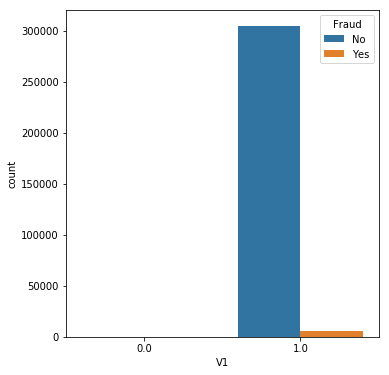

<Figure size 432x288 with 0 Axes>

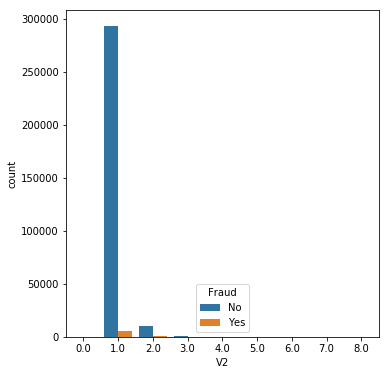

<Figure size 432x288 with 0 Axes>

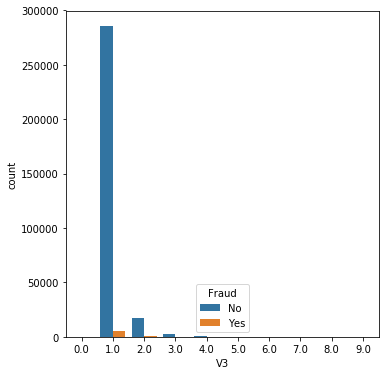

<Figure size 432x288 with 0 Axes>

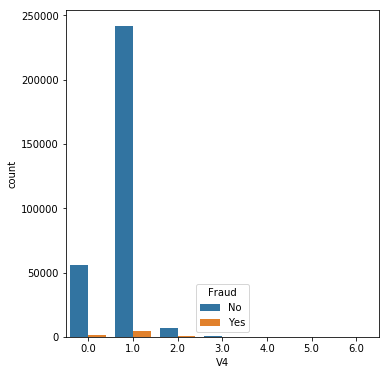

<Figure size 432x288 with 0 Axes>

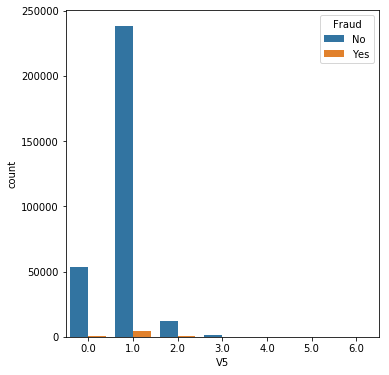

<Figure size 432x288 with 0 Axes>

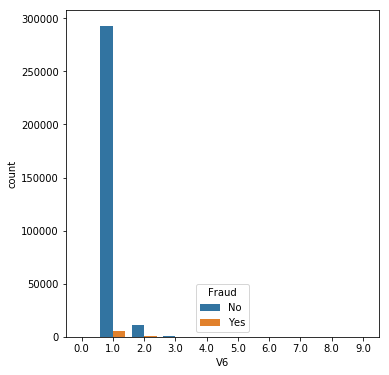

<Figure size 432x288 with 0 Axes>

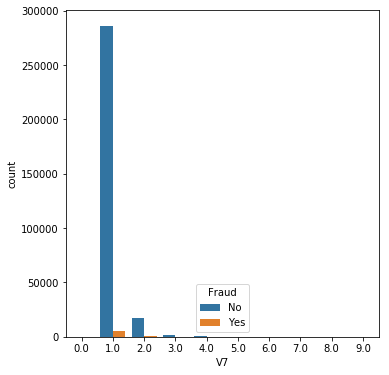

<Figure size 432x288 with 0 Axes>

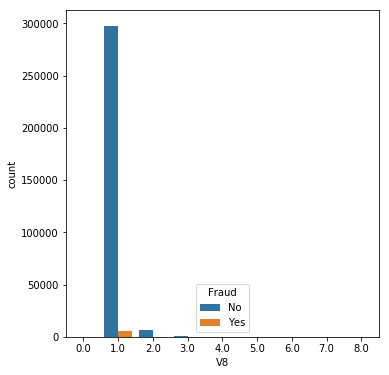

<Figure size 432x288 with 0 Axes>

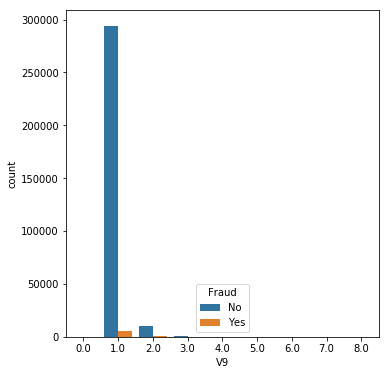

<Figure size 432x288 with 0 Axes>

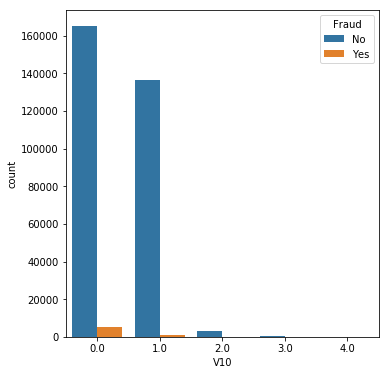

<Figure size 432x288 with 0 Axes>

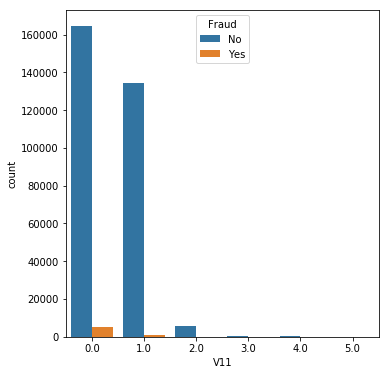

<Figure size 432x288 with 0 Axes>

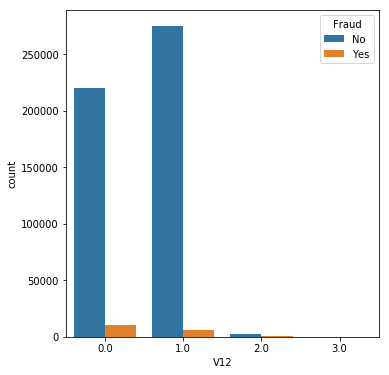

<Figure size 432x288 with 0 Axes>

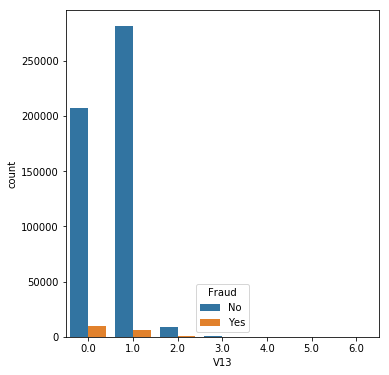

<Figure size 432x288 with 0 Axes>

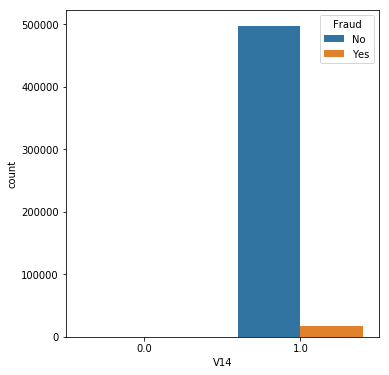

<Figure size 432x288 with 0 Axes>

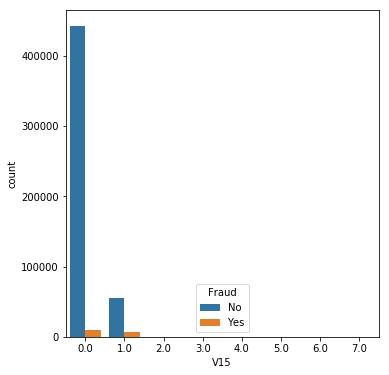

<Figure size 432x288 with 0 Axes>

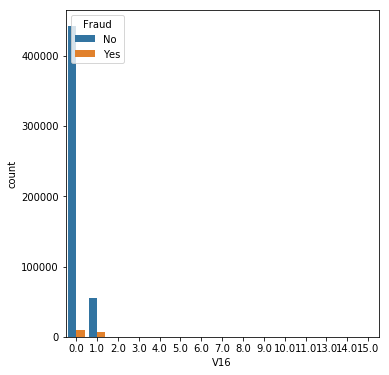

<Figure size 432x288 with 0 Axes>

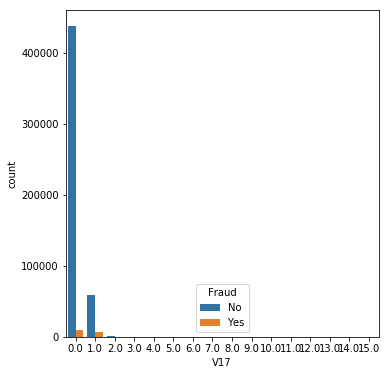

<Figure size 432x288 with 0 Axes>

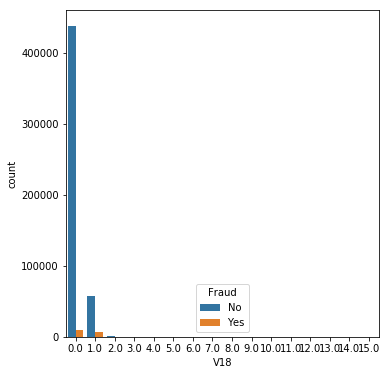

<Figure size 432x288 with 0 Axes>

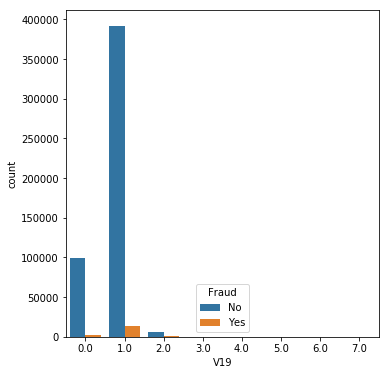

<Figure size 432x288 with 0 Axes>

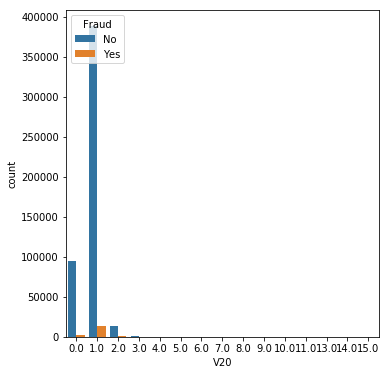

<Figure size 432x288 with 0 Axes>

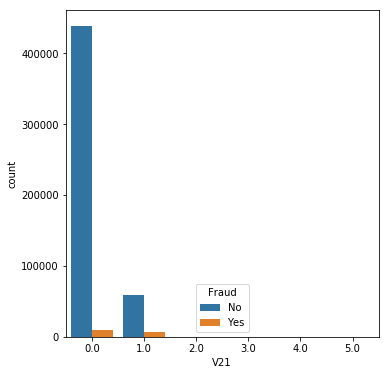

<Figure size 432x288 with 0 Axes>

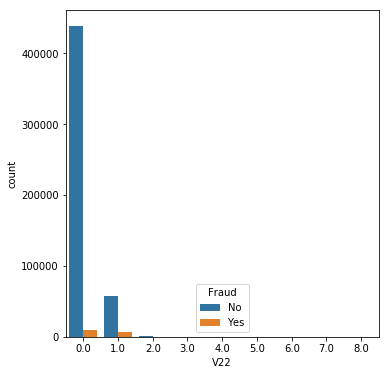

<Figure size 432x288 with 0 Axes>

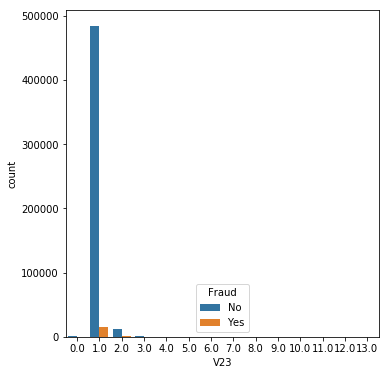

<Figure size 432x288 with 0 Axes>

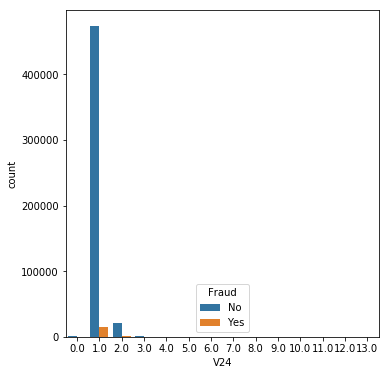

<Figure size 432x288 with 0 Axes>

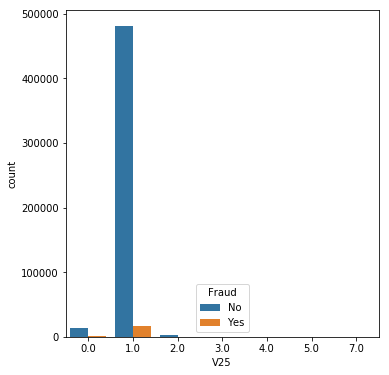

<Figure size 432x288 with 0 Axes>

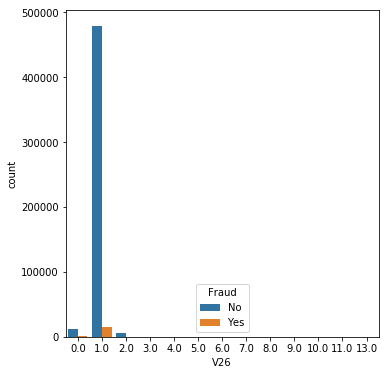

<Figure size 432x288 with 0 Axes>

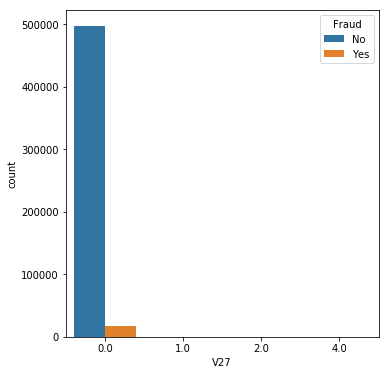

<Figure size 432x288 with 0 Axes>

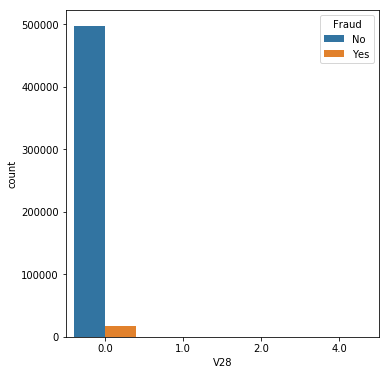

<Figure size 432x288 with 0 Axes>

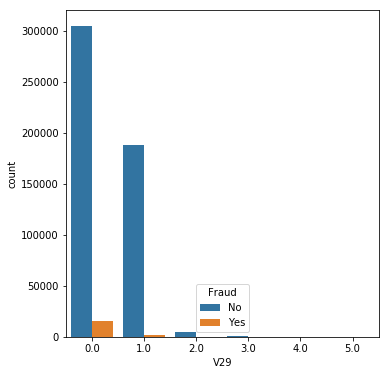

<Figure size 432x288 with 0 Axes>

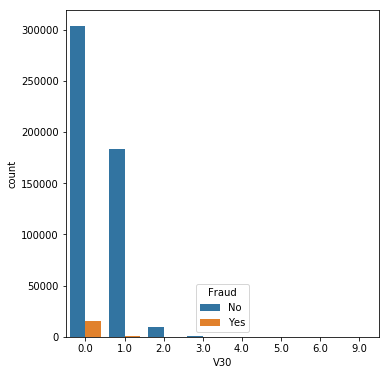

<Figure size 432x288 with 0 Axes>

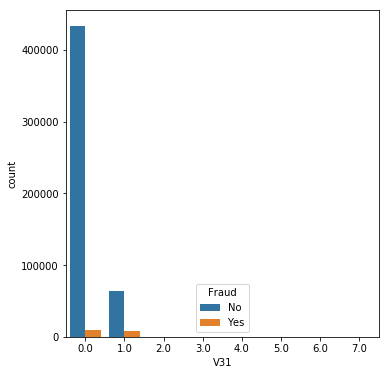

<Figure size 432x288 with 0 Axes>

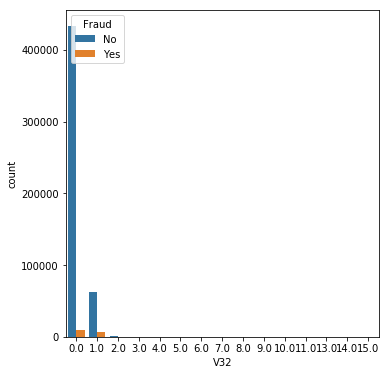

<Figure size 432x288 with 0 Axes>

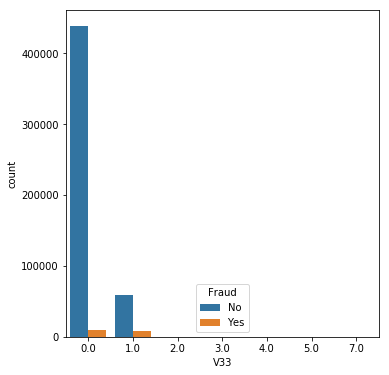

<Figure size 432x288 with 0 Axes>

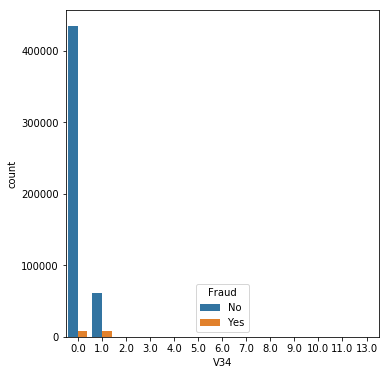

<Figure size 432x288 with 0 Axes>

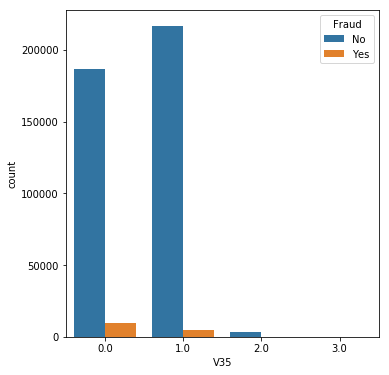

<Figure size 432x288 with 0 Axes>

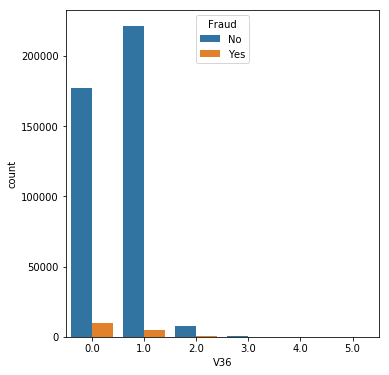

<Figure size 432x288 with 0 Axes>

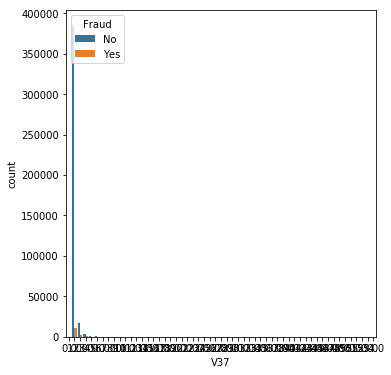

<Figure size 432x288 with 0 Axes>

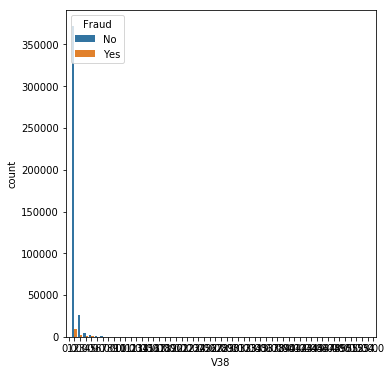

<Figure size 432x288 with 0 Axes>

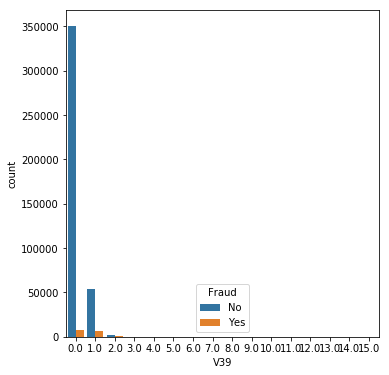

<Figure size 432x288 with 0 Axes>

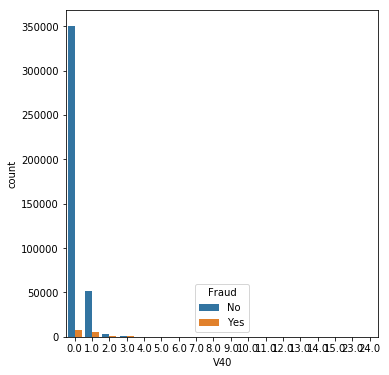

<Figure size 432x288 with 0 Axes>

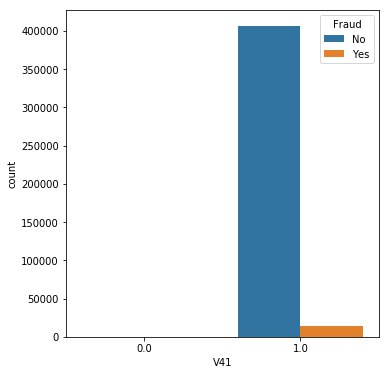

<Figure size 432x288 with 0 Axes>

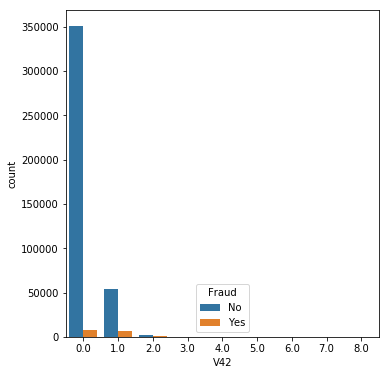

<Figure size 432x288 with 0 Axes>

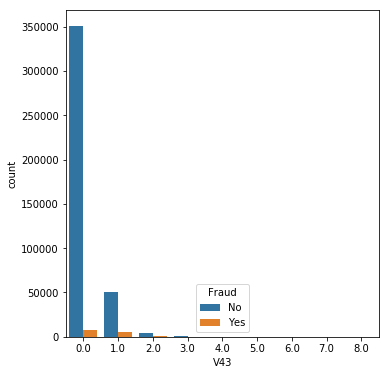

<Figure size 432x288 with 0 Axes>

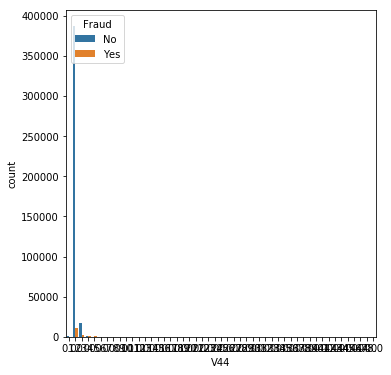

<Figure size 432x288 with 0 Axes>

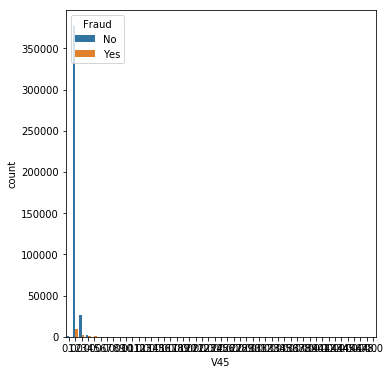

<Figure size 432x288 with 0 Axes>

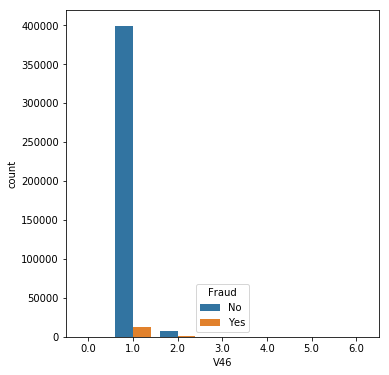

<Figure size 432x288 with 0 Axes>

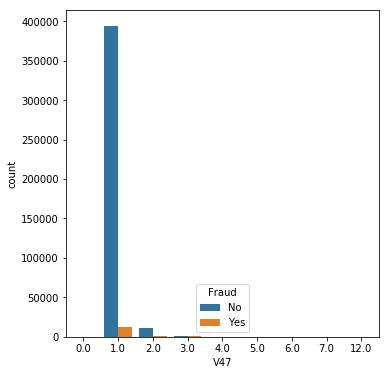

<Figure size 432x288 with 0 Axes>

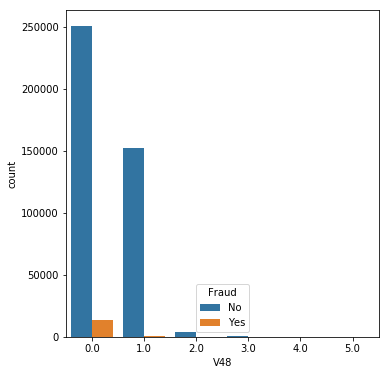

<Figure size 432x288 with 0 Axes>

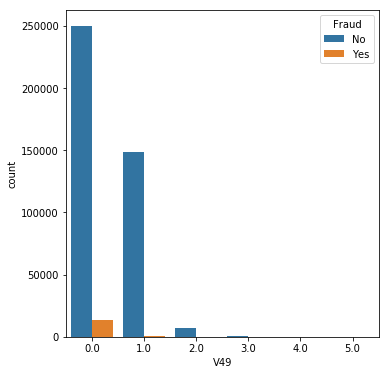

<Figure size 432x288 with 0 Axes>

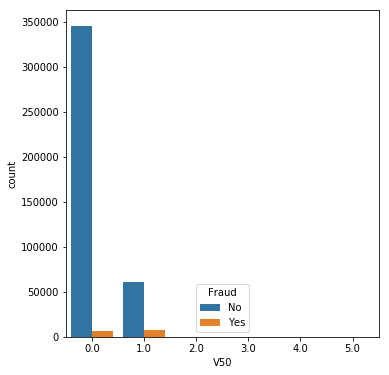

<Figure size 432x288 with 0 Axes>

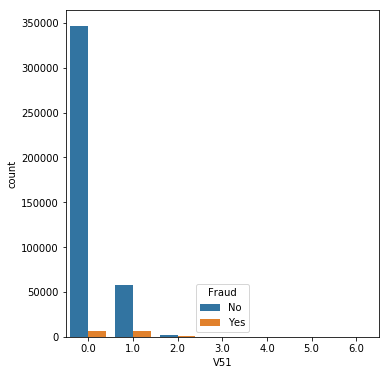

<Figure size 432x288 with 0 Axes>

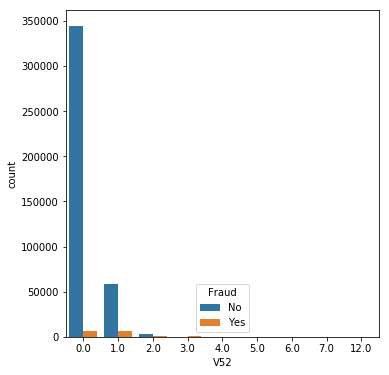

<Figure size 432x288 with 0 Axes>

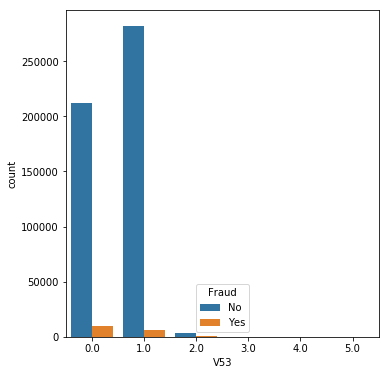

<Figure size 432x288 with 0 Axes>

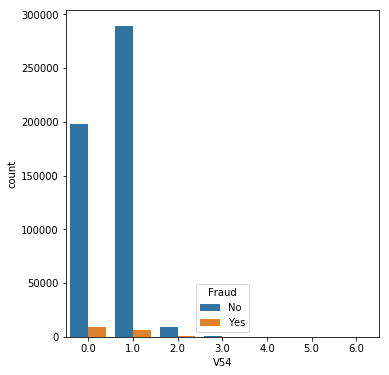

<Figure size 432x288 with 0 Axes>

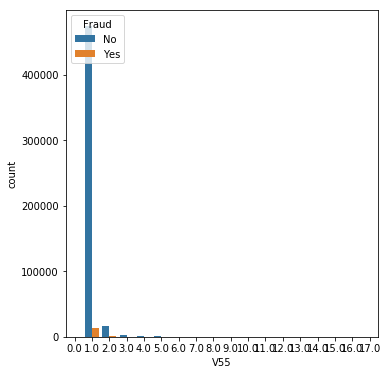

<Figure size 432x288 with 0 Axes>

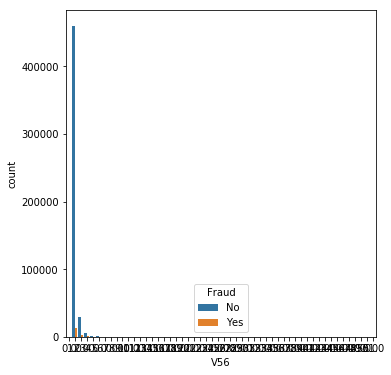

<Figure size 432x288 with 0 Axes>

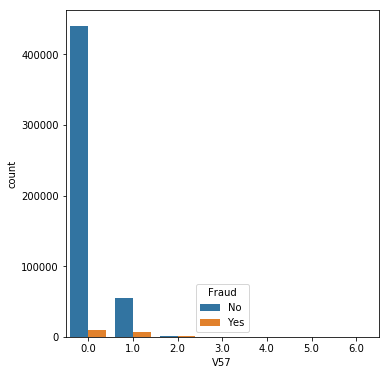

<Figure size 432x288 with 0 Axes>

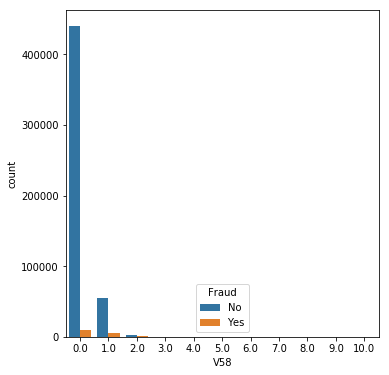

<Figure size 432x288 with 0 Axes>

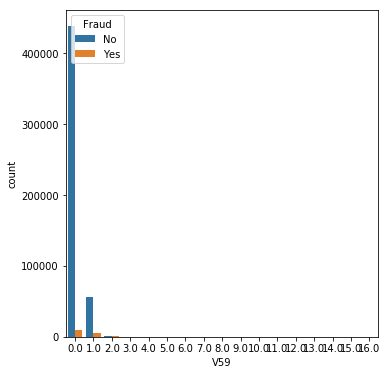

<Figure size 432x288 with 0 Axes>

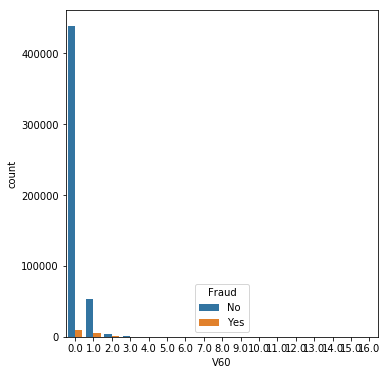

<Figure size 432x288 with 0 Axes>

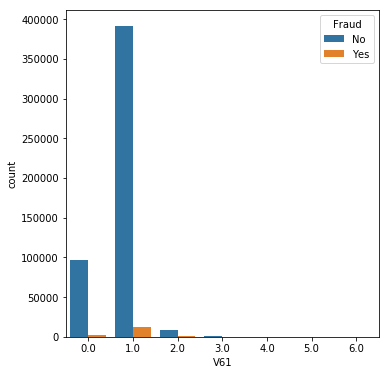

<Figure size 432x288 with 0 Axes>

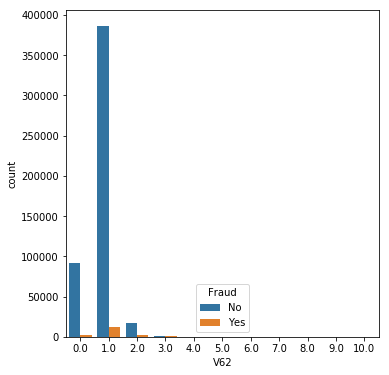

<Figure size 432x288 with 0 Axes>

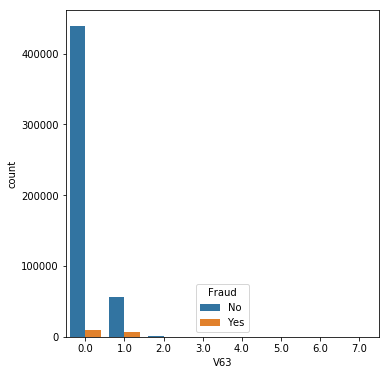

<Figure size 432x288 with 0 Axes>

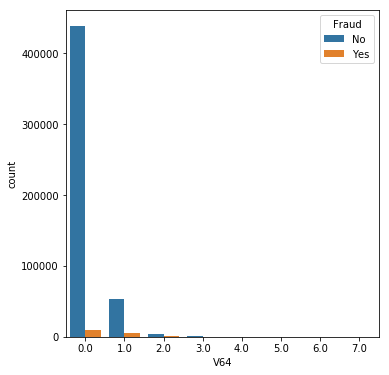

<Figure size 432x288 with 0 Axes>

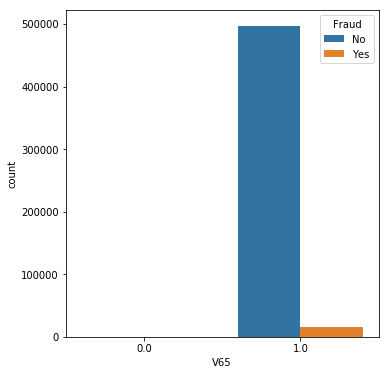

<Figure size 432x288 with 0 Axes>

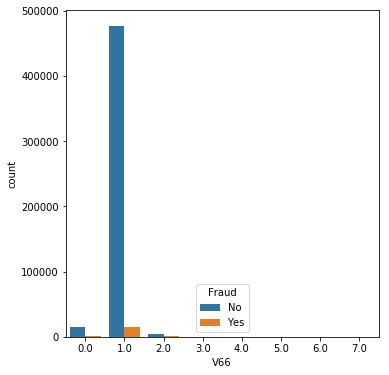

<Figure size 432x288 with 0 Axes>

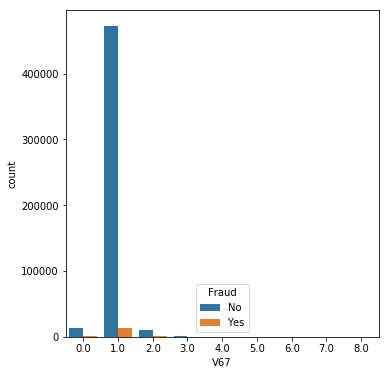

<Figure size 432x288 with 0 Axes>

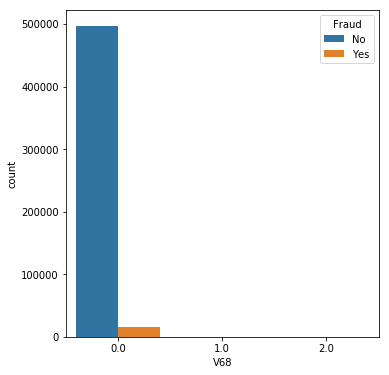

<Figure size 432x288 with 0 Axes>

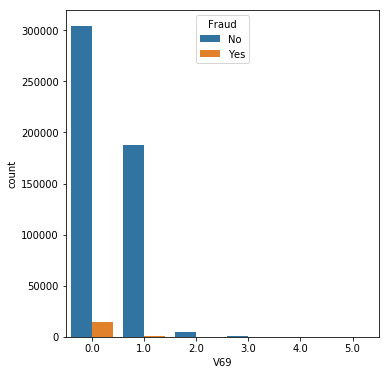

<Figure size 432x288 with 0 Axes>

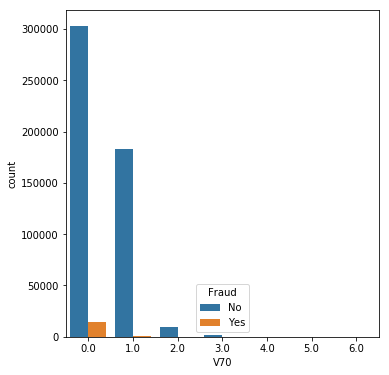

<Figure size 432x288 with 0 Axes>

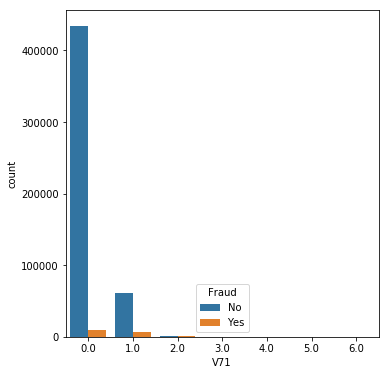

<Figure size 432x288 with 0 Axes>

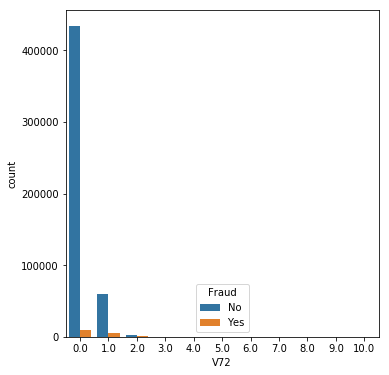

<Figure size 432x288 with 0 Axes>

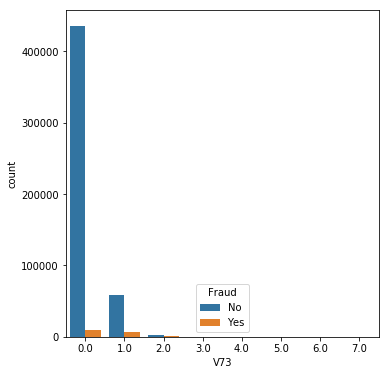

<Figure size 432x288 with 0 Axes>

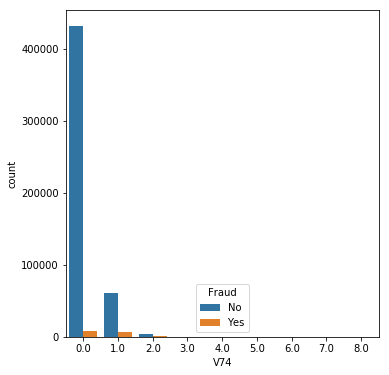

<Figure size 432x288 with 0 Axes>

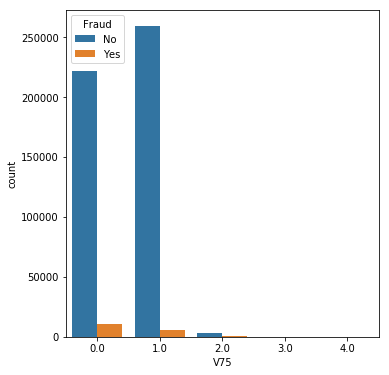

<Figure size 432x288 with 0 Axes>

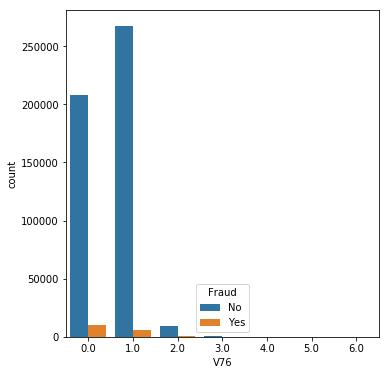

<Figure size 432x288 with 0 Axes>

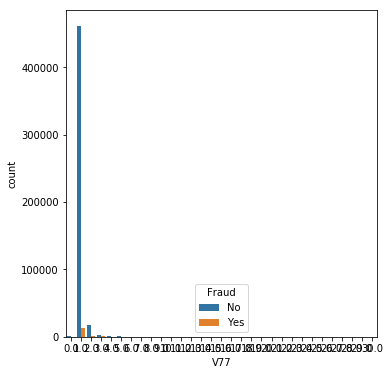

<Figure size 432x288 with 0 Axes>

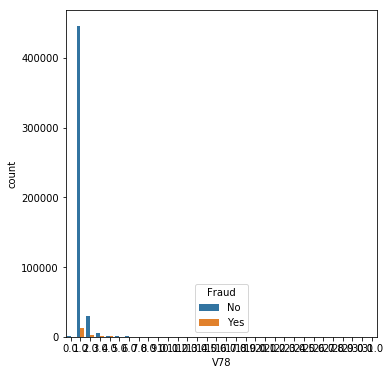

<Figure size 432x288 with 0 Axes>

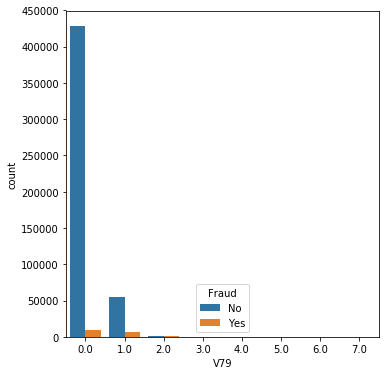

<Figure size 432x288 with 0 Axes>

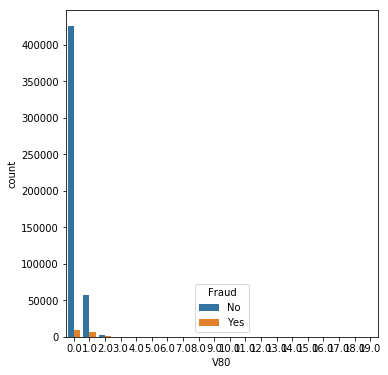

<Figure size 432x288 with 0 Axes>

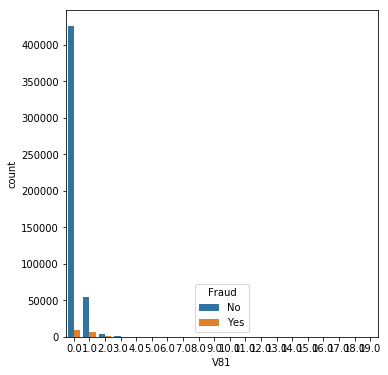

<Figure size 432x288 with 0 Axes>

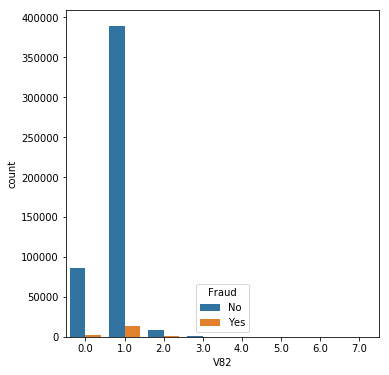

<Figure size 432x288 with 0 Axes>

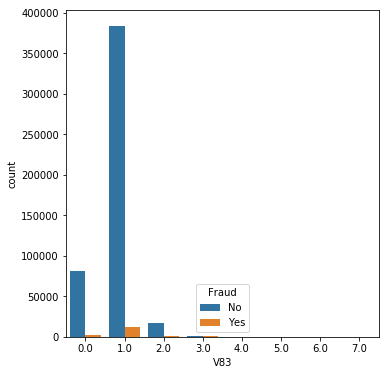

<Figure size 432x288 with 0 Axes>

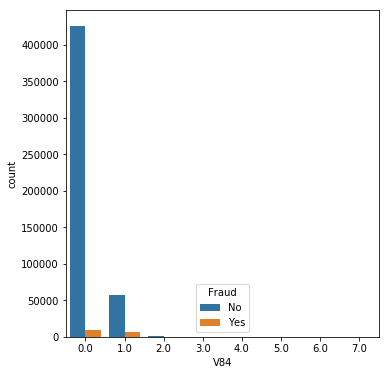

<Figure size 432x288 with 0 Axes>

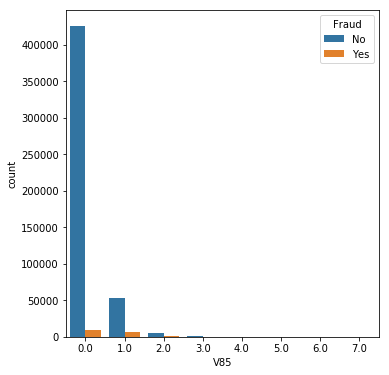

<Figure size 432x288 with 0 Axes>

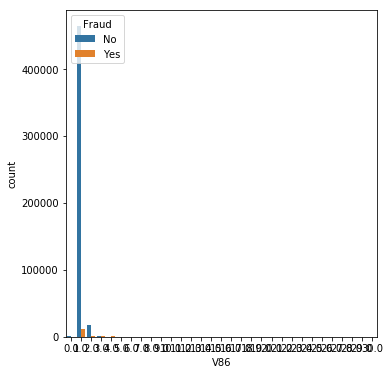

<Figure size 432x288 with 0 Axes>

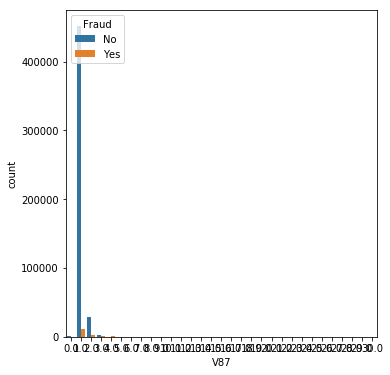

<Figure size 432x288 with 0 Axes>

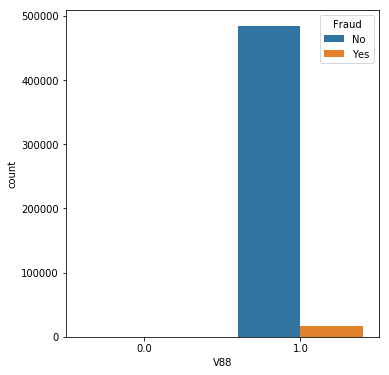

<Figure size 432x288 with 0 Axes>

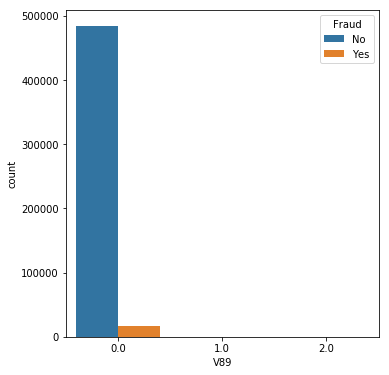

<Figure size 432x288 with 0 Axes>

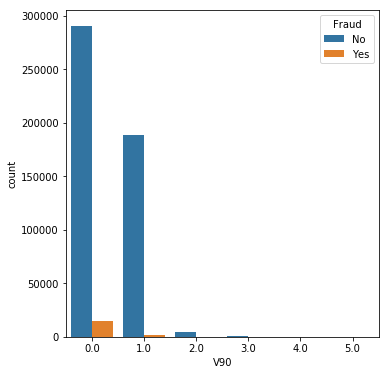

<Figure size 432x288 with 0 Axes>

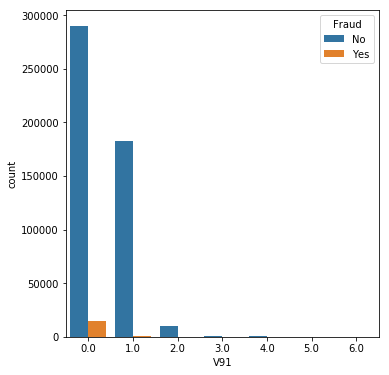

<Figure size 432x288 with 0 Axes>

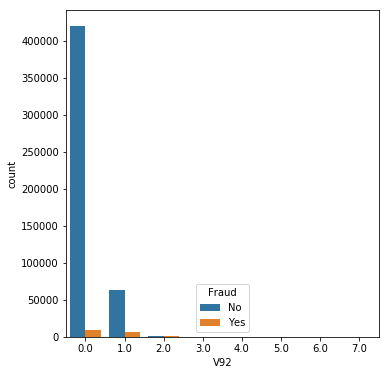

<Figure size 432x288 with 0 Axes>

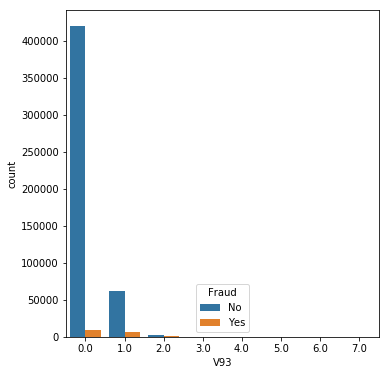

<Figure size 432x288 with 0 Axes>

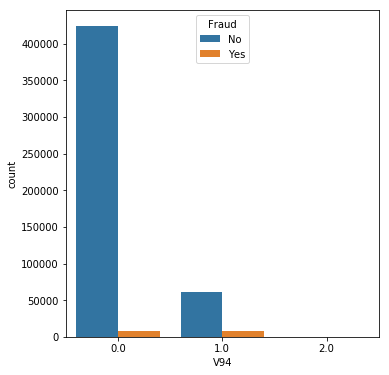

<Figure size 432x288 with 0 Axes>

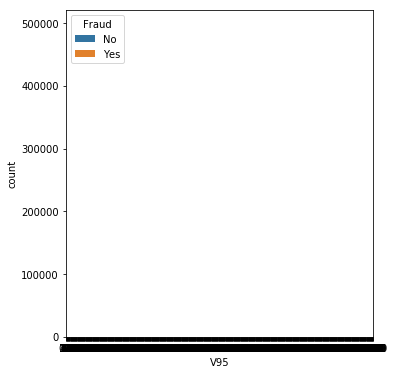

<Figure size 432x288 with 0 Axes>

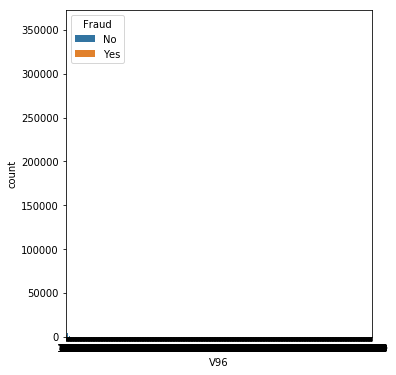

<Figure size 432x288 with 0 Axes>

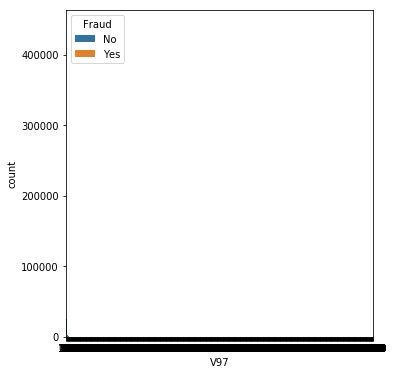

<Figure size 432x288 with 0 Axes>

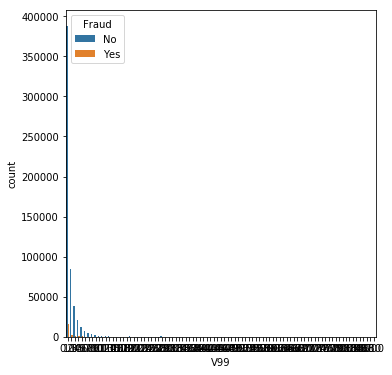

<Figure size 432x288 with 0 Axes>

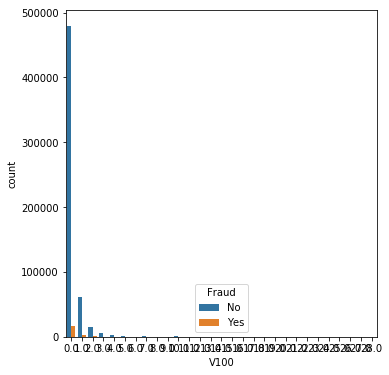

<Figure size 432x288 with 0 Axes>

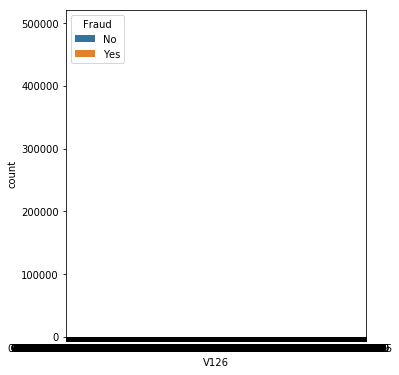

<Figure size 432x288 with 0 Axes>

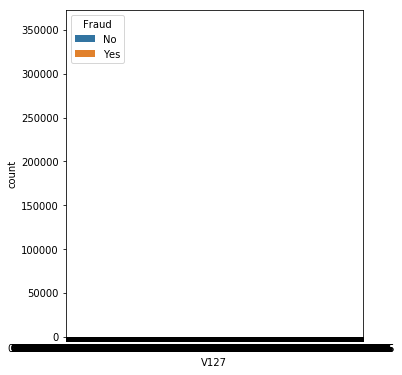

<Figure size 432x288 with 0 Axes>

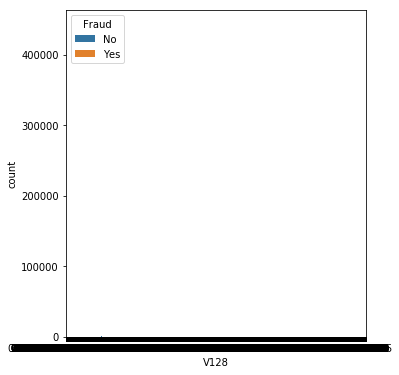

<Figure size 432x288 with 0 Axes>

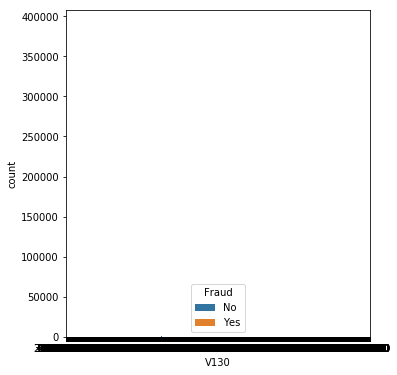

<Figure size 432x288 with 0 Axes>

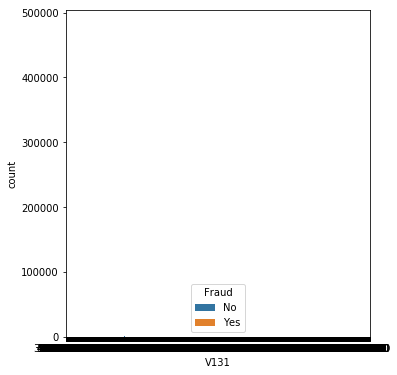

<Figure size 432x288 with 0 Axes>

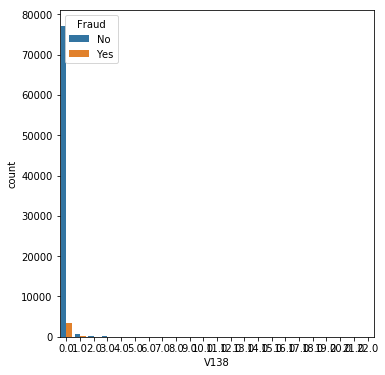

<Figure size 432x288 with 0 Axes>

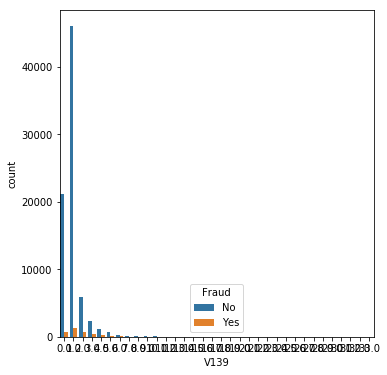

<Figure size 432x288 with 0 Axes>

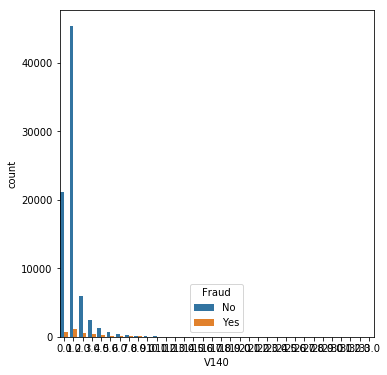

<Figure size 432x288 with 0 Axes>

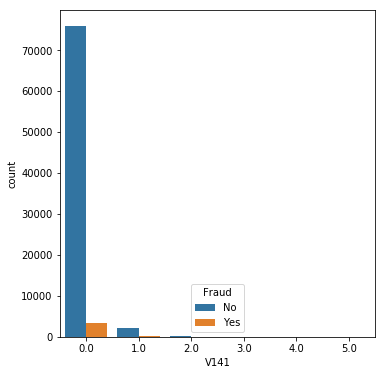

<Figure size 432x288 with 0 Axes>

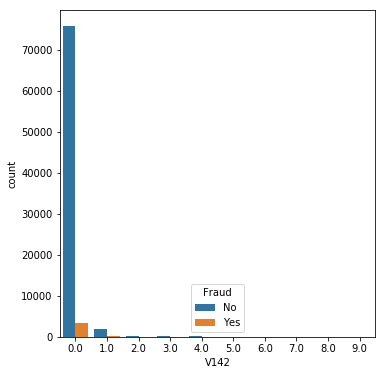

<Figure size 432x288 with 0 Axes>

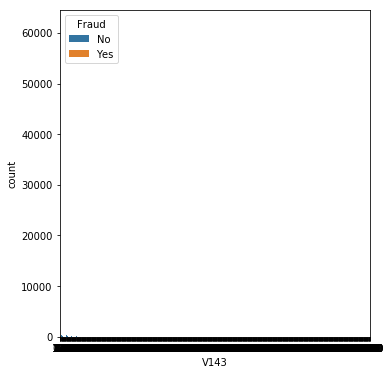

<Figure size 432x288 with 0 Axes>

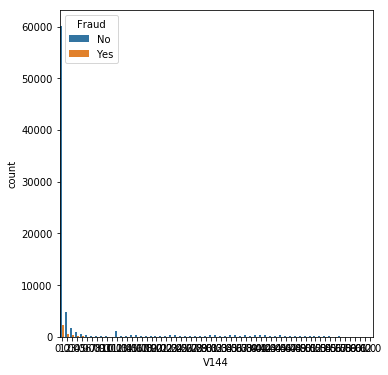

<Figure size 432x288 with 0 Axes>

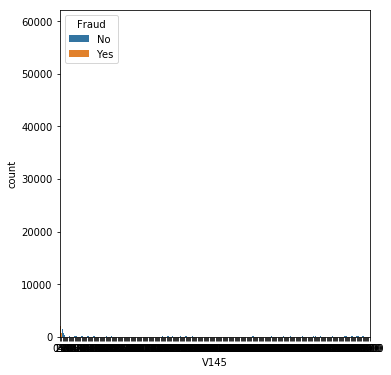

<Figure size 432x288 with 0 Axes>

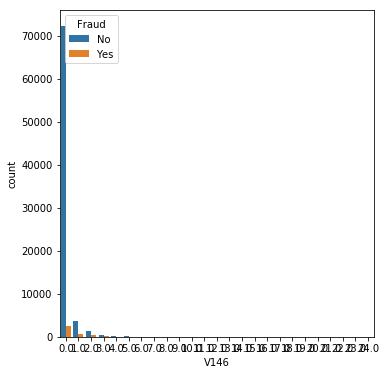

<Figure size 432x288 with 0 Axes>

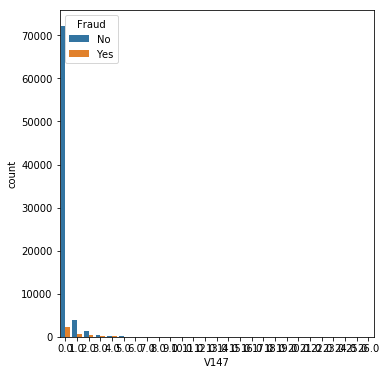

<Figure size 432x288 with 0 Axes>

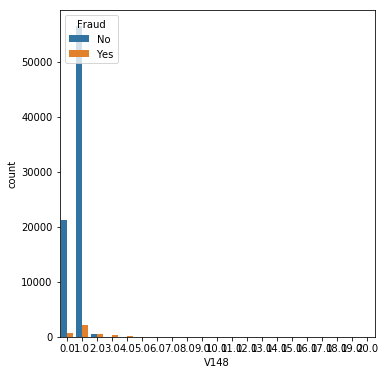

<Figure size 432x288 with 0 Axes>

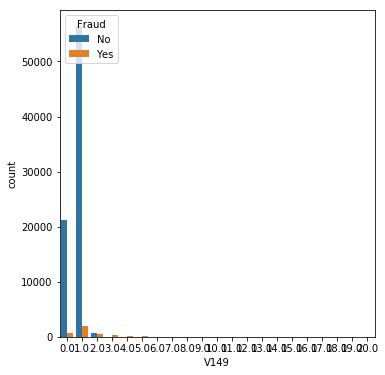

<Figure size 432x288 with 0 Axes>

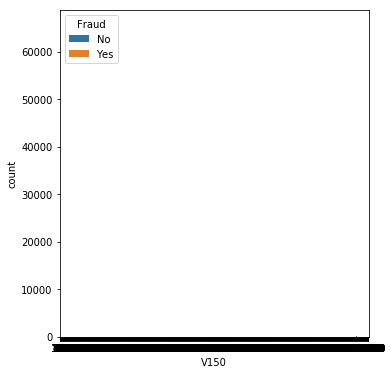

<Figure size 432x288 with 0 Axes>

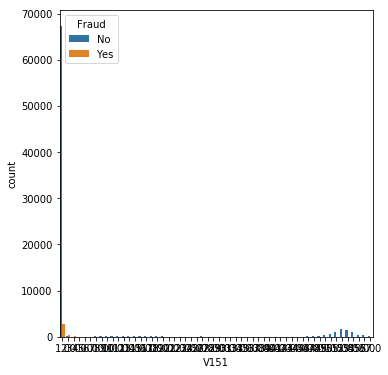

<Figure size 432x288 with 0 Axes>

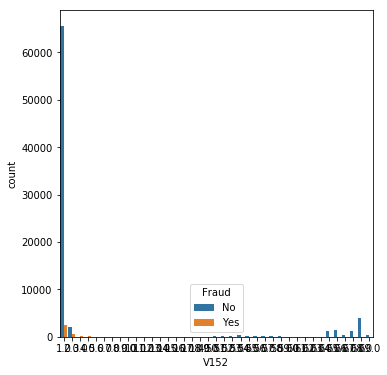

<Figure size 432x288 with 0 Axes>

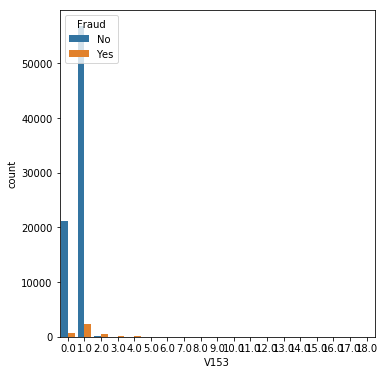

<Figure size 432x288 with 0 Axes>

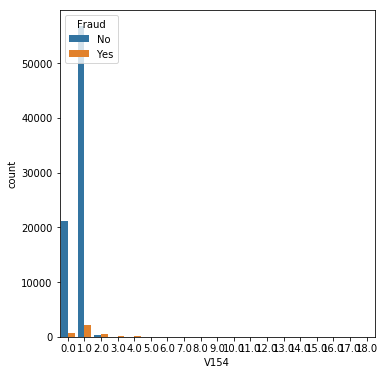

<Figure size 432x288 with 0 Axes>

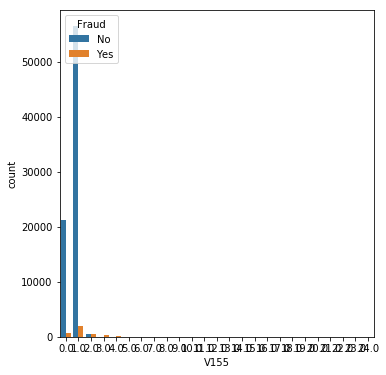

<Figure size 432x288 with 0 Axes>

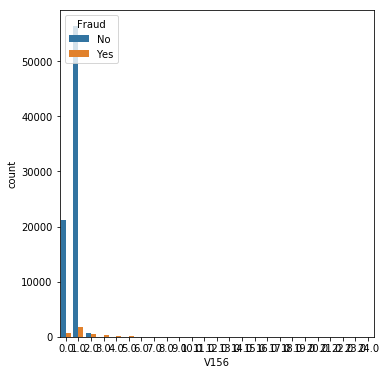

<Figure size 432x288 with 0 Axes>

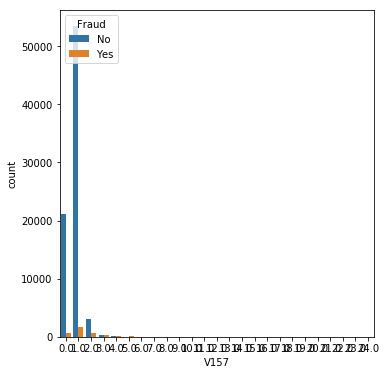

<Figure size 432x288 with 0 Axes>

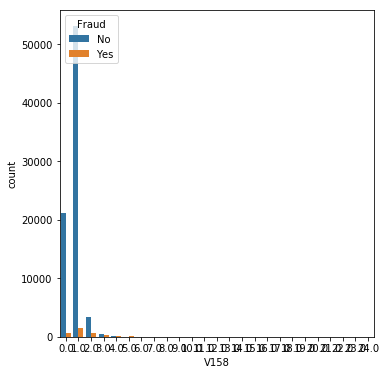

<Figure size 432x288 with 0 Axes>

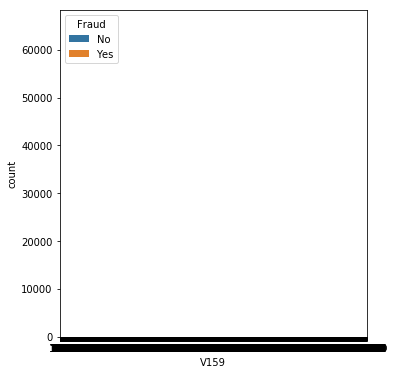

<Figure size 432x288 with 0 Axes>

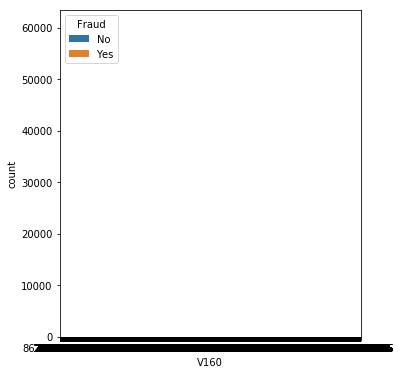

<Figure size 432x288 with 0 Axes>

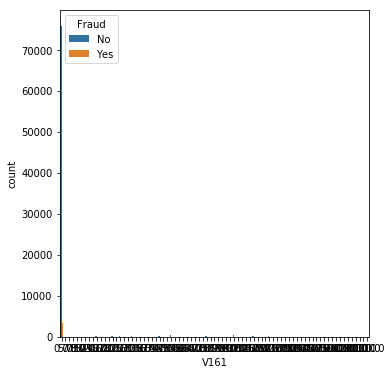

<Figure size 432x288 with 0 Axes>

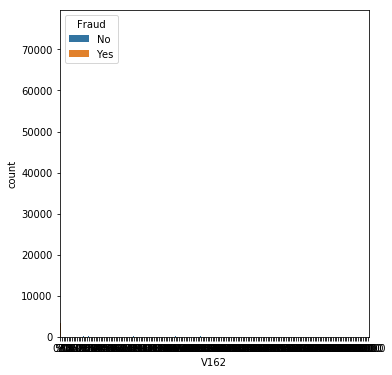

<Figure size 432x288 with 0 Axes>

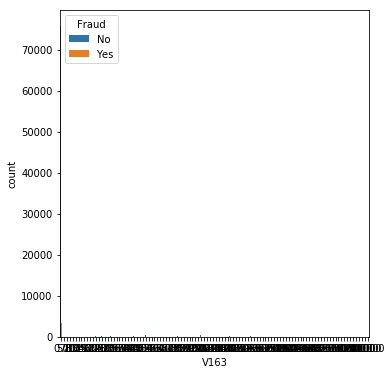

<Figure size 432x288 with 0 Axes>

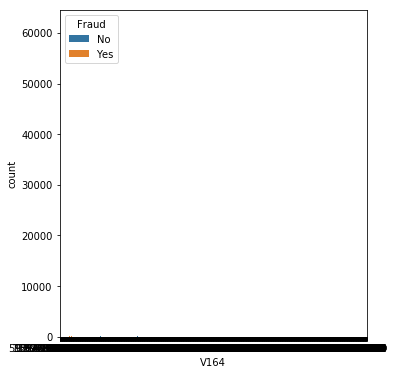

<Figure size 432x288 with 0 Axes>

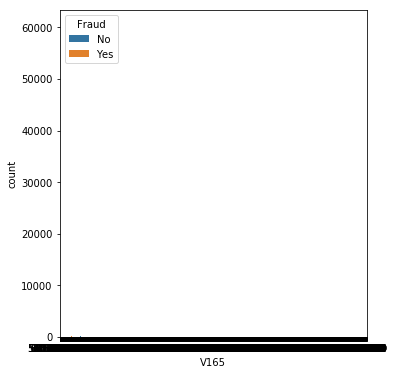

<Figure size 432x288 with 0 Axes>

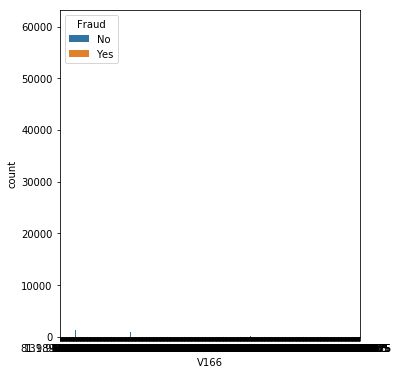

<Figure size 432x288 with 0 Axes>

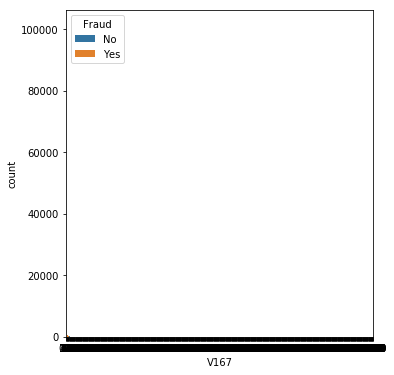

<Figure size 432x288 with 0 Axes>

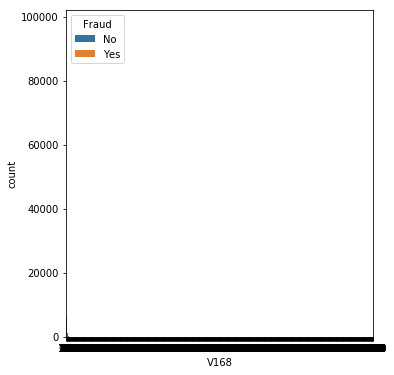

<Figure size 432x288 with 0 Axes>

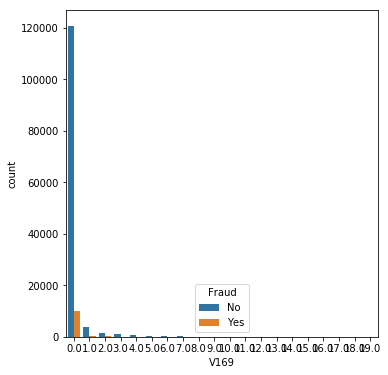

<Figure size 432x288 with 0 Axes>

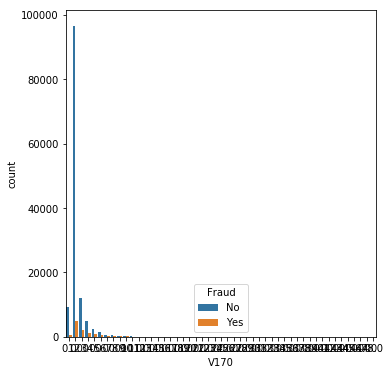

<Figure size 432x288 with 0 Axes>

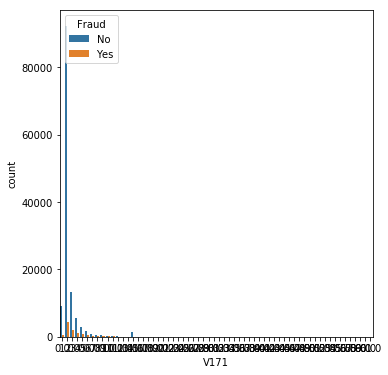

<Figure size 432x288 with 0 Axes>

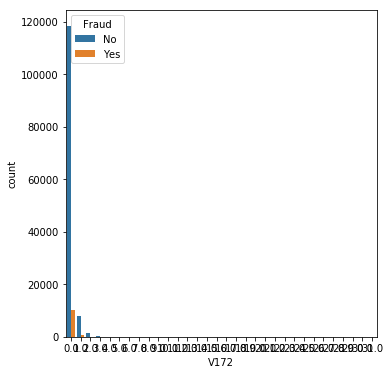

<Figure size 432x288 with 0 Axes>

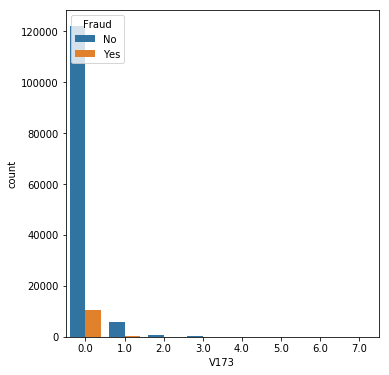

<Figure size 432x288 with 0 Axes>

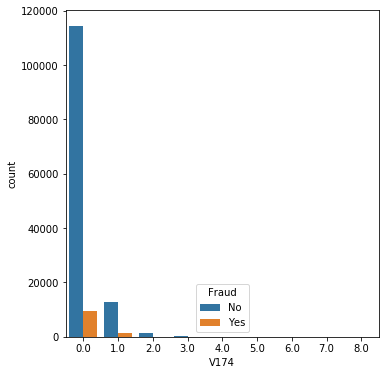

<Figure size 432x288 with 0 Axes>

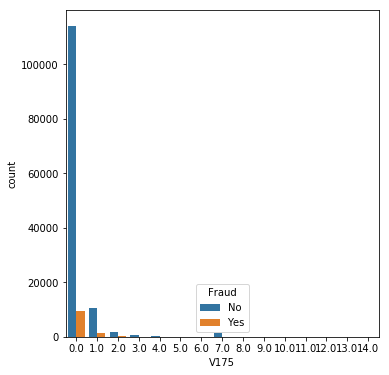

<Figure size 432x288 with 0 Axes>

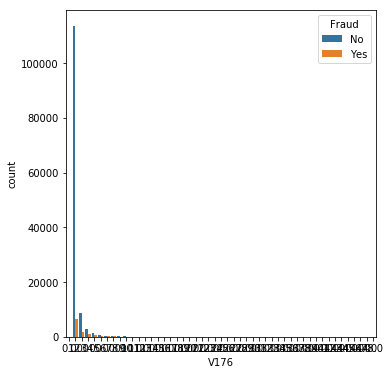

<Figure size 432x288 with 0 Axes>

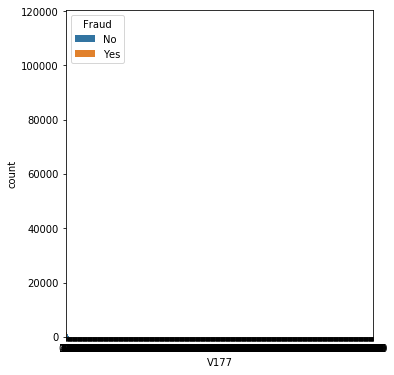

<Figure size 432x288 with 0 Axes>

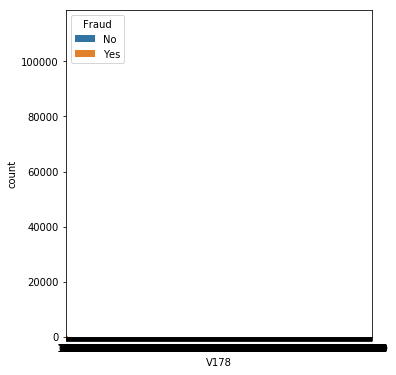

<Figure size 432x288 with 0 Axes>

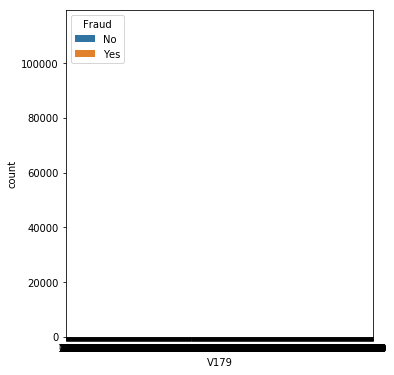

<Figure size 432x288 with 0 Axes>

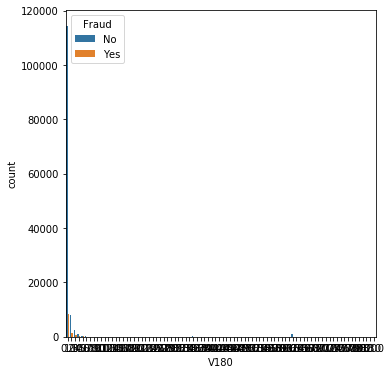

<Figure size 432x288 with 0 Axes>

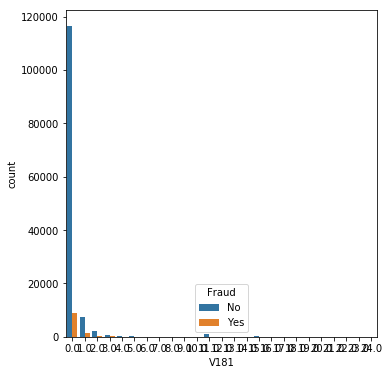

<Figure size 432x288 with 0 Axes>

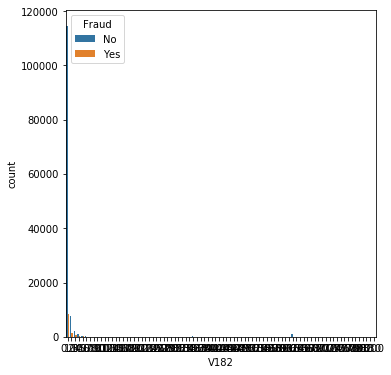

<Figure size 432x288 with 0 Axes>

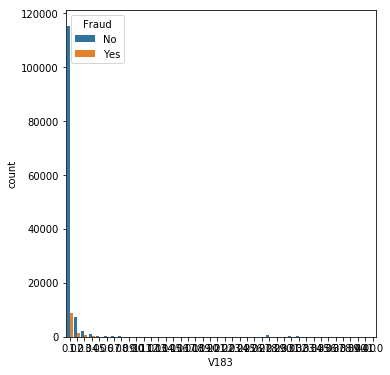

<Figure size 432x288 with 0 Axes>

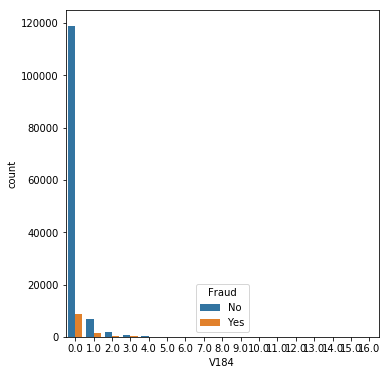

<Figure size 432x288 with 0 Axes>

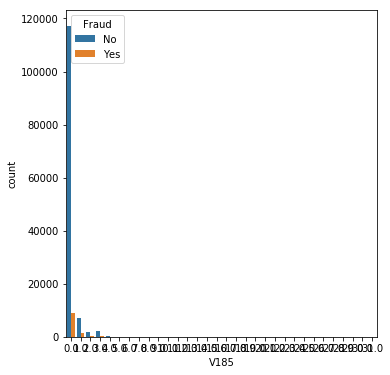

<Figure size 432x288 with 0 Axes>

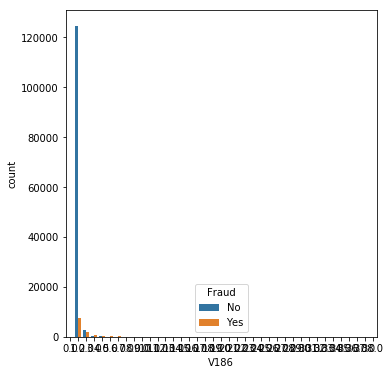

<Figure size 432x288 with 0 Axes>

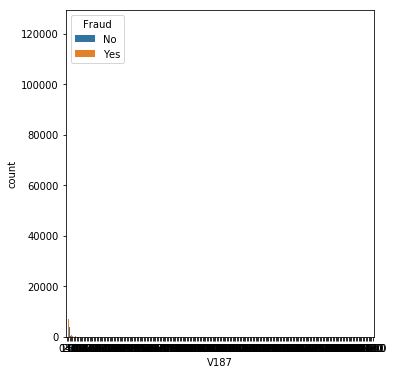

<Figure size 432x288 with 0 Axes>

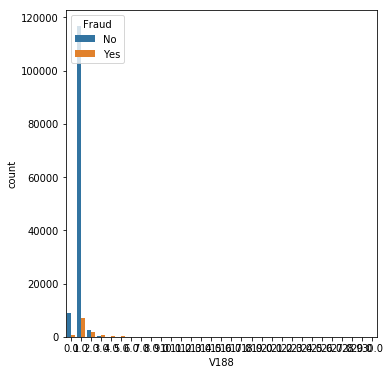

<Figure size 432x288 with 0 Axes>

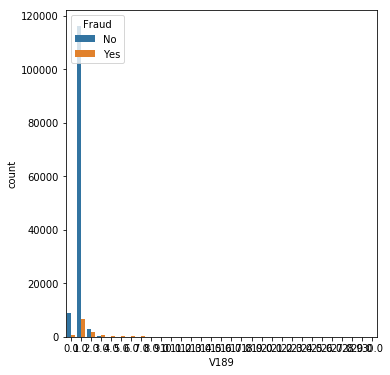

<Figure size 432x288 with 0 Axes>

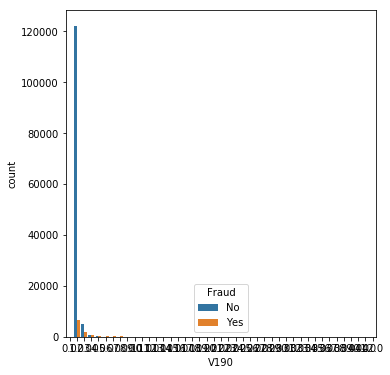

<Figure size 432x288 with 0 Axes>

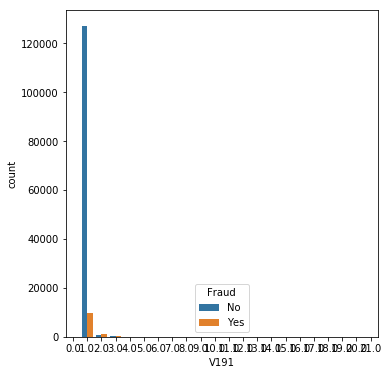

<Figure size 432x288 with 0 Axes>

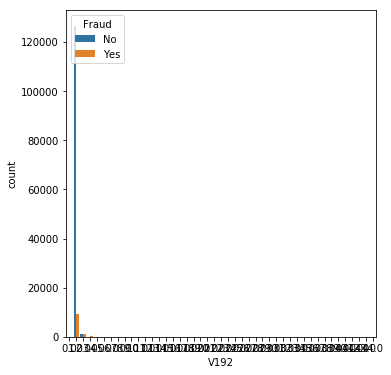

<Figure size 432x288 with 0 Axes>

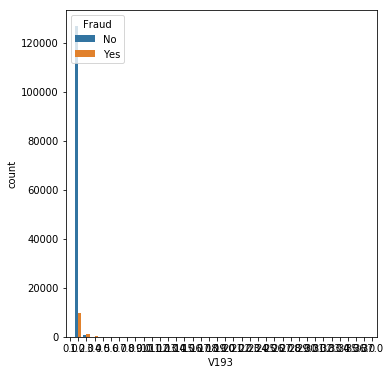

<Figure size 432x288 with 0 Axes>

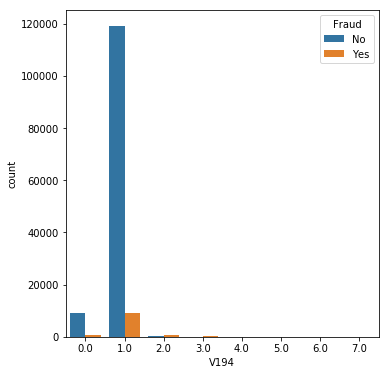

<Figure size 432x288 with 0 Axes>

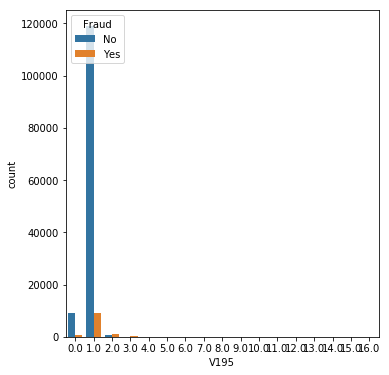

<Figure size 432x288 with 0 Axes>

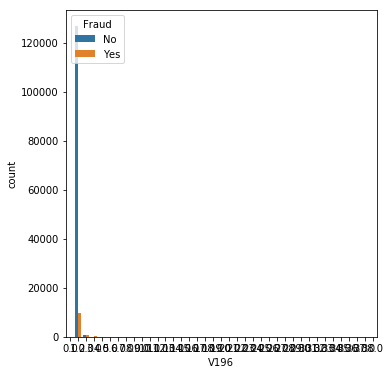

<Figure size 432x288 with 0 Axes>

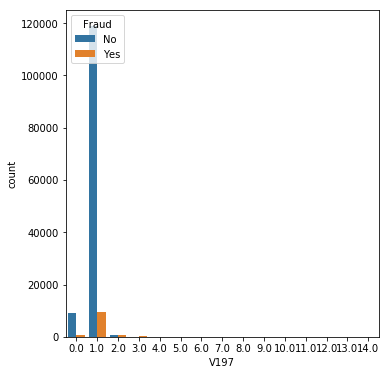

<Figure size 432x288 with 0 Axes>

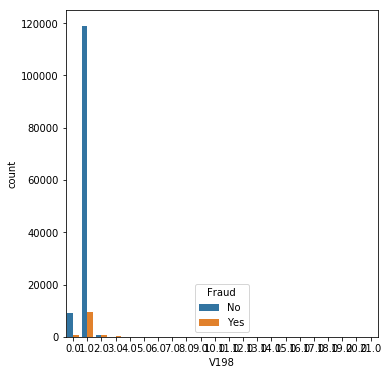

<Figure size 432x288 with 0 Axes>

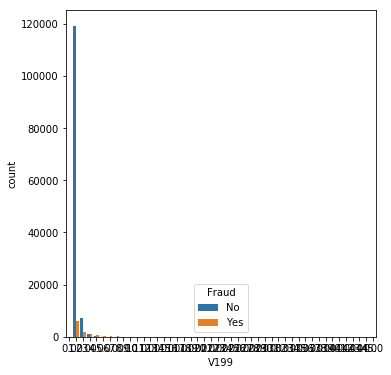

<Figure size 432x288 with 0 Axes>

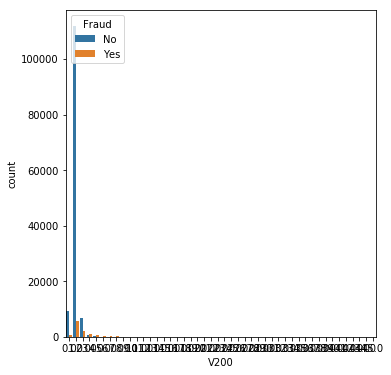

<Figure size 432x288 with 0 Axes>

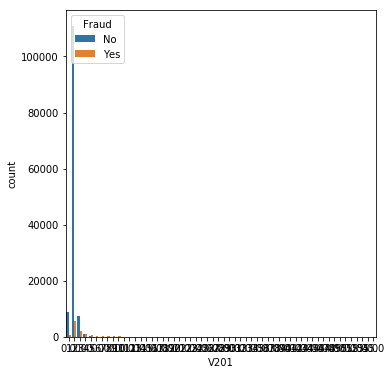

<Figure size 432x288 with 0 Axes>

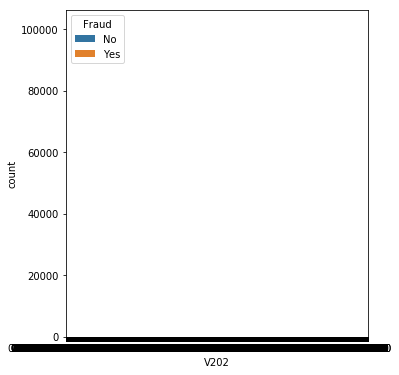

<Figure size 432x288 with 0 Axes>

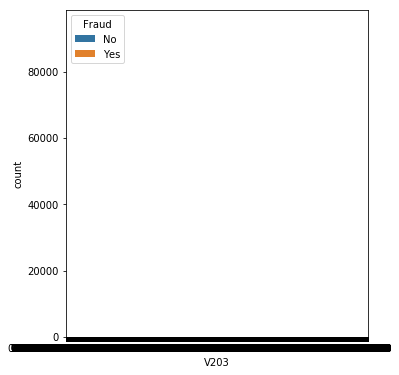

<Figure size 432x288 with 0 Axes>

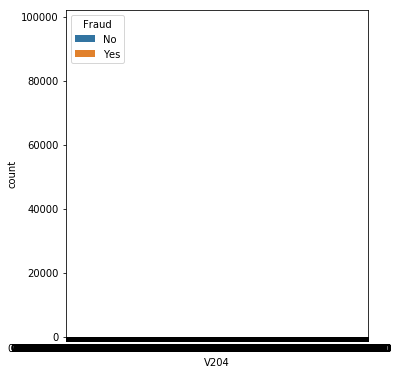

<Figure size 432x288 with 0 Axes>

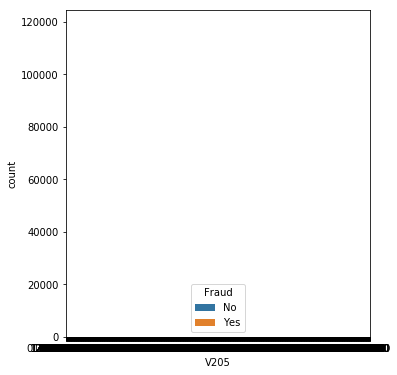

<Figure size 432x288 with 0 Axes>

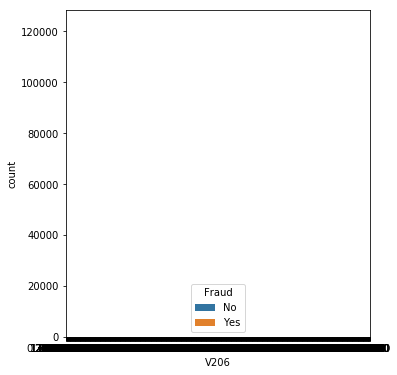

<Figure size 432x288 with 0 Axes>

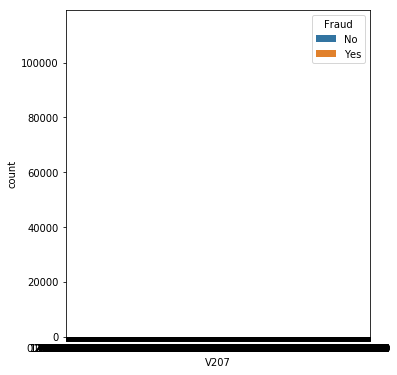

<Figure size 432x288 with 0 Axes>

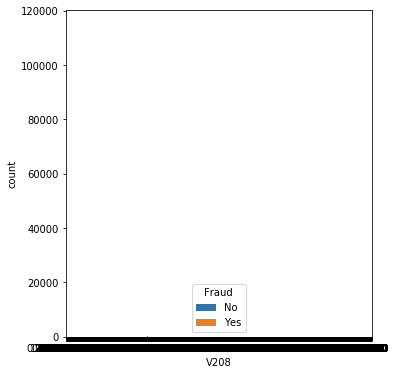

<Figure size 432x288 with 0 Axes>

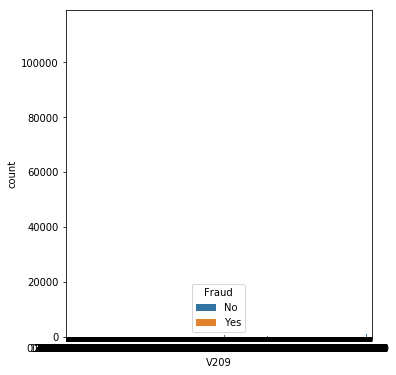

<Figure size 432x288 with 0 Axes>

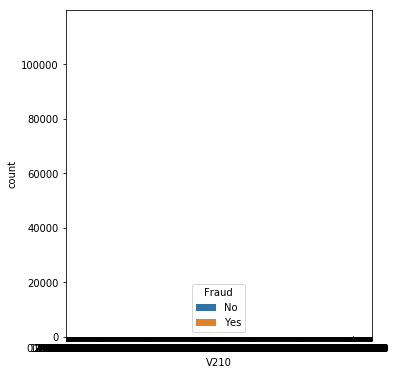

<Figure size 432x288 with 0 Axes>

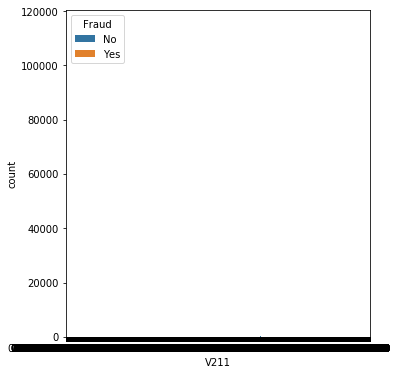

<Figure size 432x288 with 0 Axes>

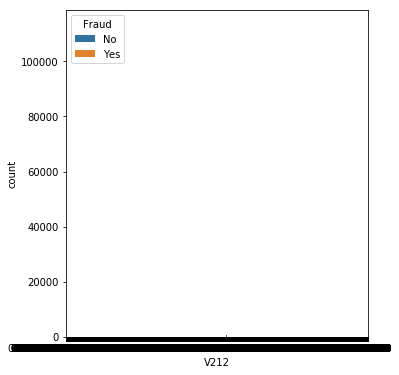

<Figure size 432x288 with 0 Axes>

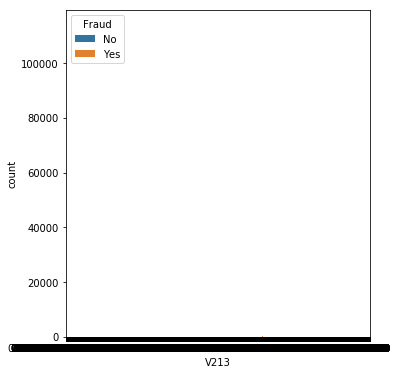

<Figure size 432x288 with 0 Axes>

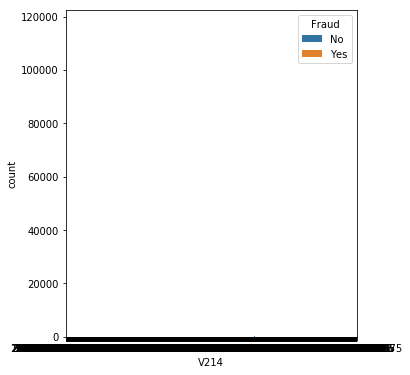

<Figure size 432x288 with 0 Axes>

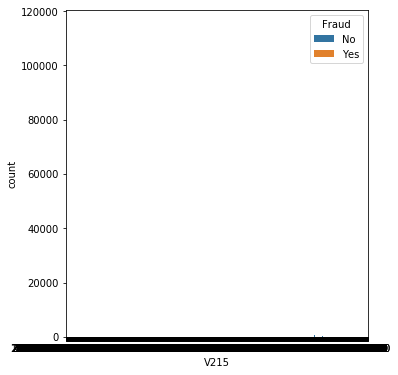

<Figure size 432x288 with 0 Axes>

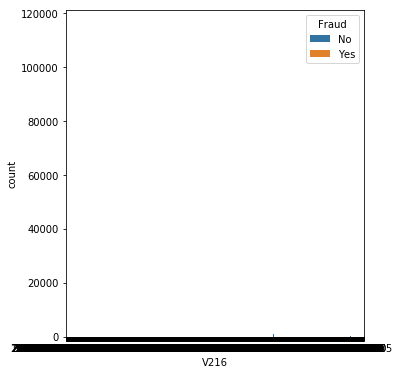

<Figure size 432x288 with 0 Axes>

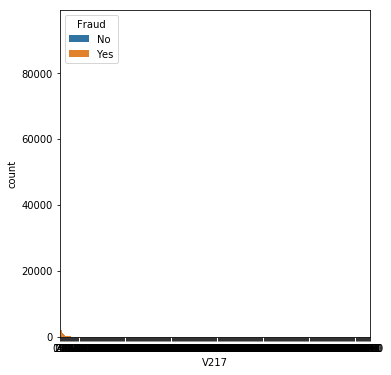

<Figure size 432x288 with 0 Axes>

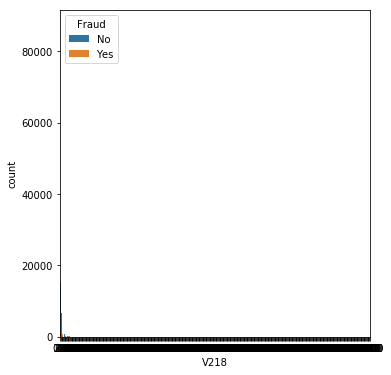

<Figure size 432x288 with 0 Axes>

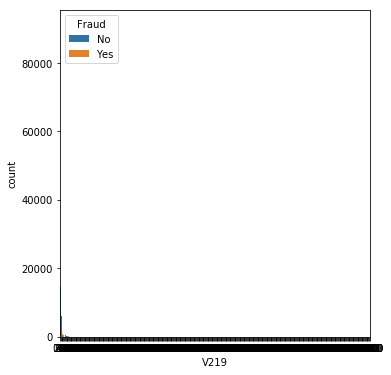

<Figure size 432x288 with 0 Axes>

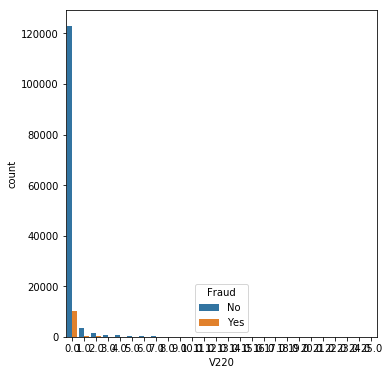

<Figure size 432x288 with 0 Axes>

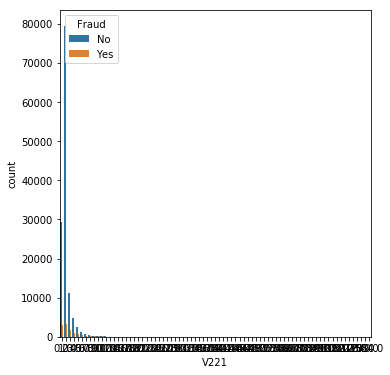

<Figure size 432x288 with 0 Axes>

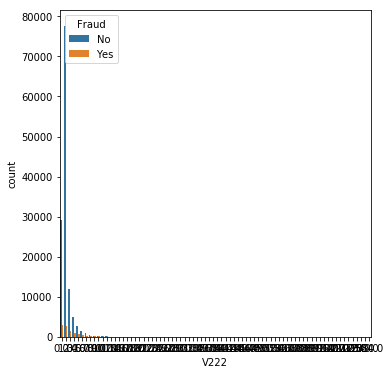

<Figure size 432x288 with 0 Axes>

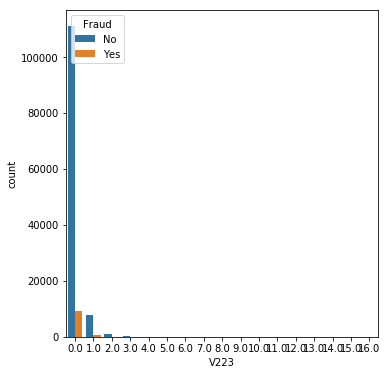

<Figure size 432x288 with 0 Axes>

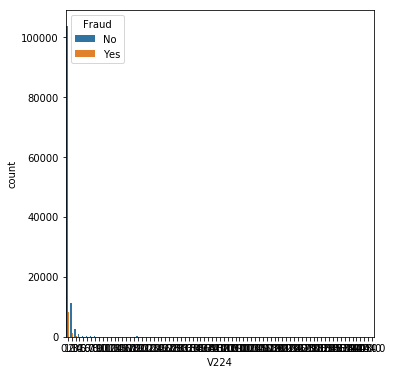

<Figure size 432x288 with 0 Axes>

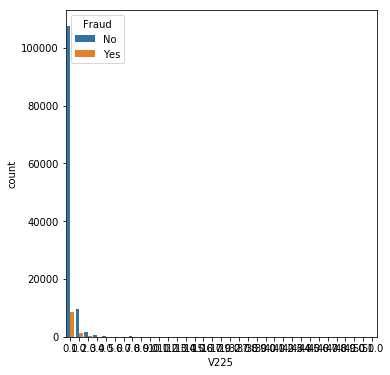

<Figure size 432x288 with 0 Axes>

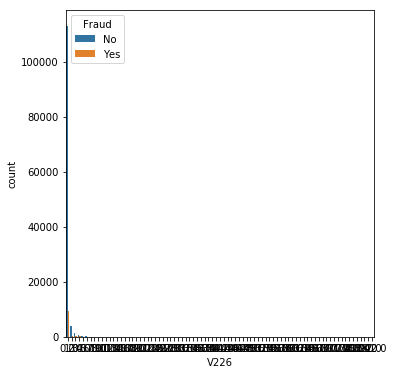

<Figure size 432x288 with 0 Axes>

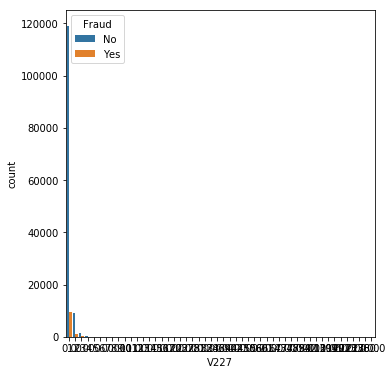

<Figure size 432x288 with 0 Axes>

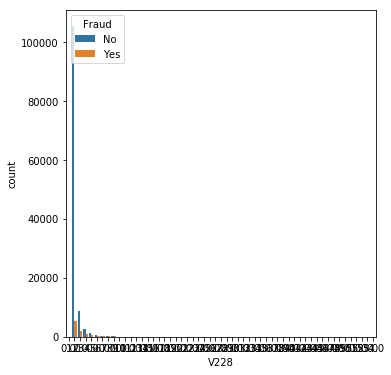

<Figure size 432x288 with 0 Axes>

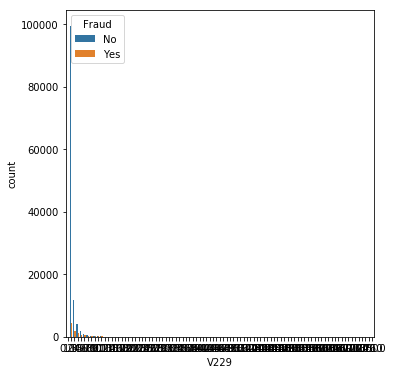

<Figure size 432x288 with 0 Axes>

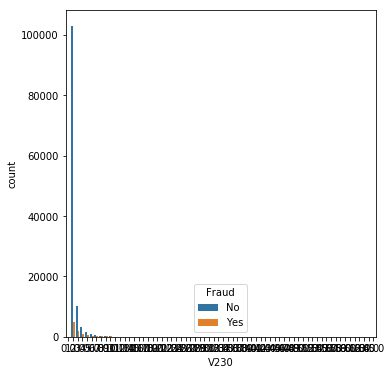

<Figure size 432x288 with 0 Axes>

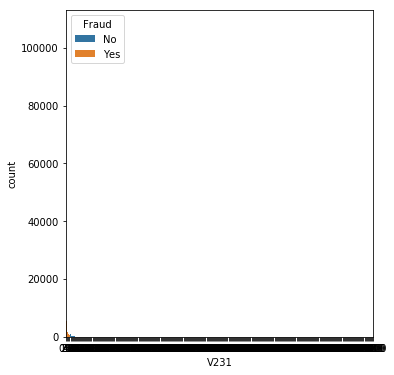

<Figure size 432x288 with 0 Axes>

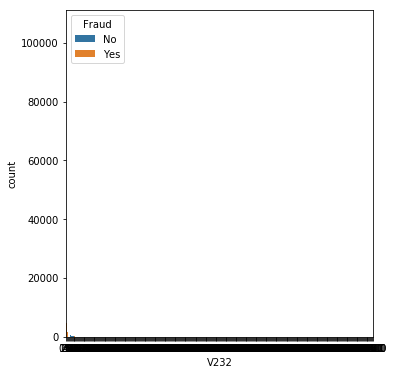

<Figure size 432x288 with 0 Axes>

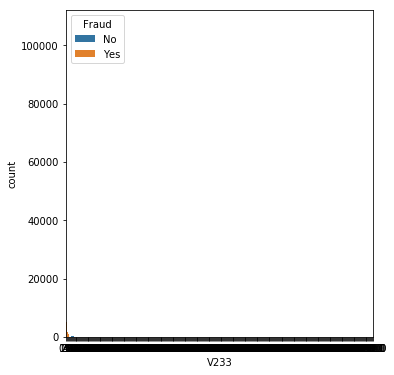

<Figure size 432x288 with 0 Axes>

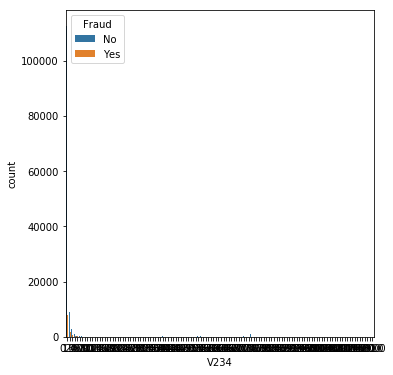

<Figure size 432x288 with 0 Axes>

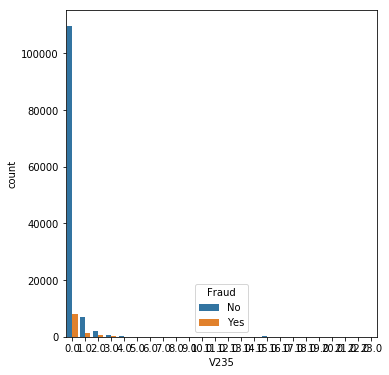

<Figure size 432x288 with 0 Axes>

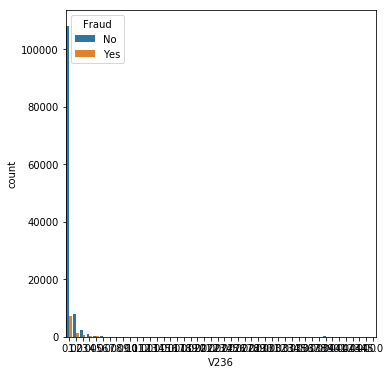

<Figure size 432x288 with 0 Axes>

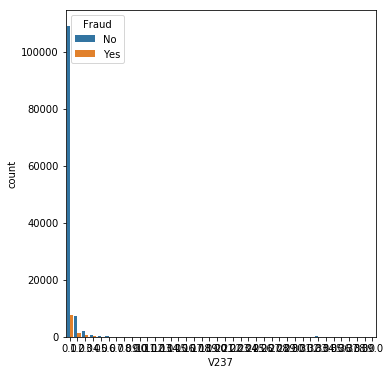

<Figure size 432x288 with 0 Axes>

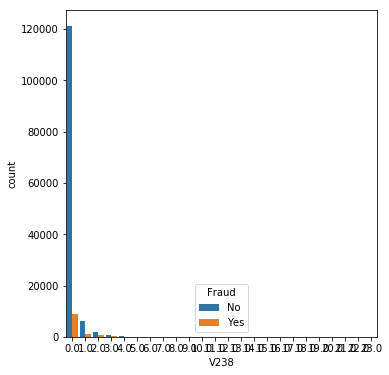

<Figure size 432x288 with 0 Axes>

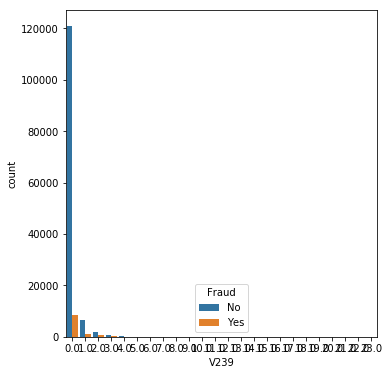

<Figure size 432x288 with 0 Axes>

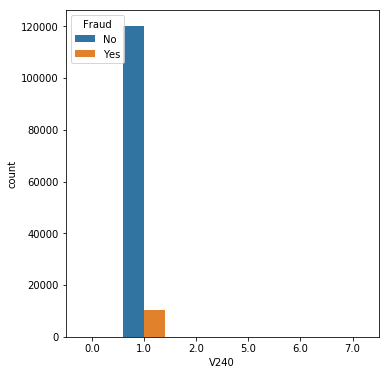

<Figure size 432x288 with 0 Axes>

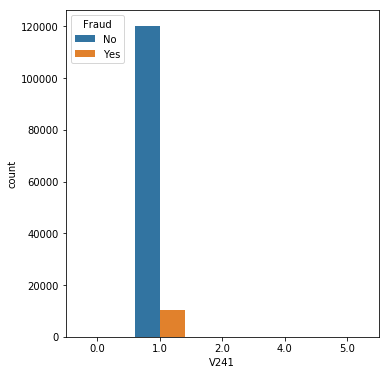

<Figure size 432x288 with 0 Axes>

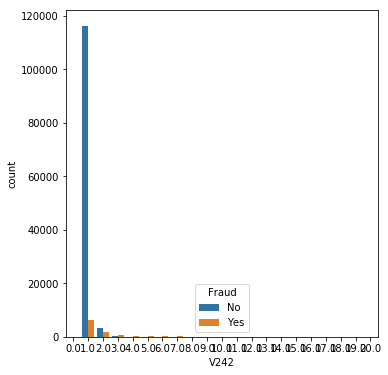

<Figure size 432x288 with 0 Axes>

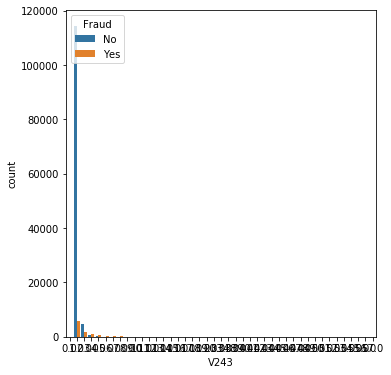

<Figure size 432x288 with 0 Axes>

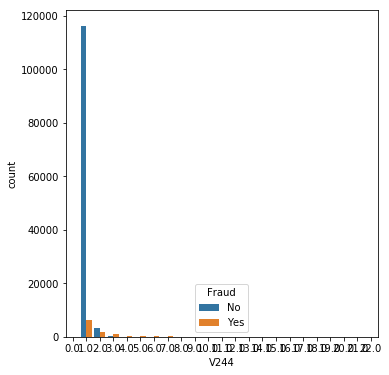

<Figure size 432x288 with 0 Axes>

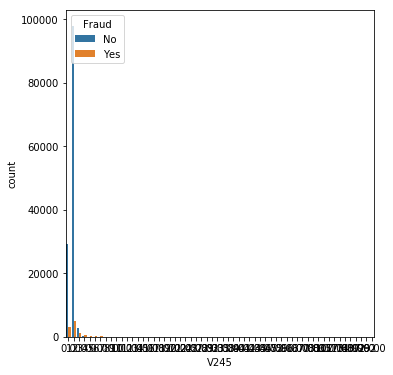

<Figure size 432x288 with 0 Axes>

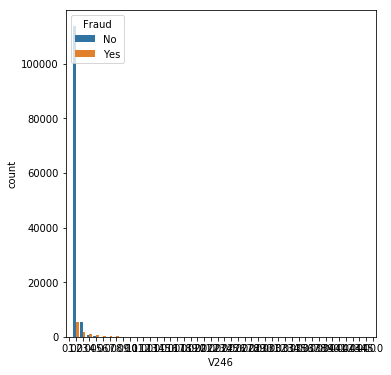

<Figure size 432x288 with 0 Axes>

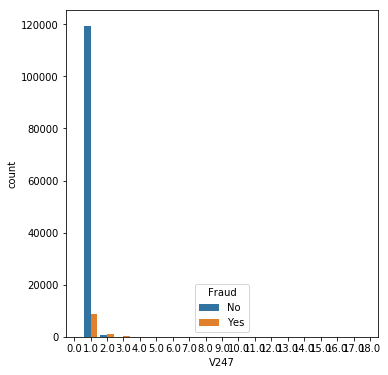

<Figure size 432x288 with 0 Axes>

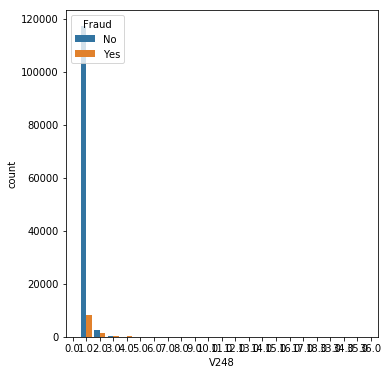

<Figure size 432x288 with 0 Axes>

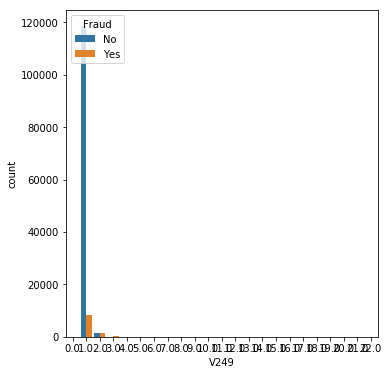

<Figure size 432x288 with 0 Axes>

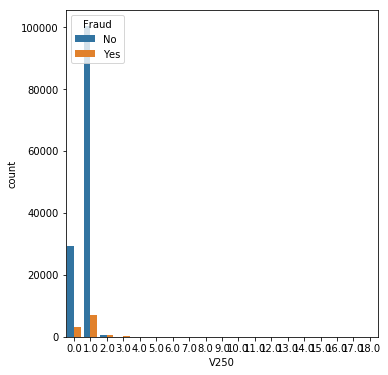

<Figure size 432x288 with 0 Axes>

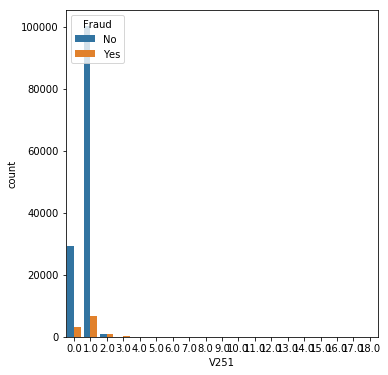

<Figure size 432x288 with 0 Axes>

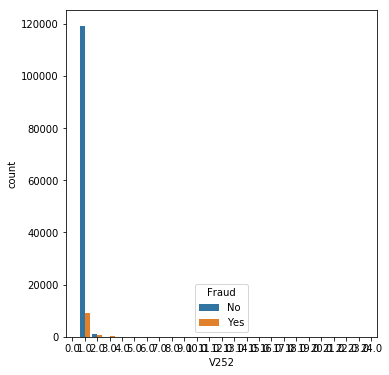

<Figure size 432x288 with 0 Axes>

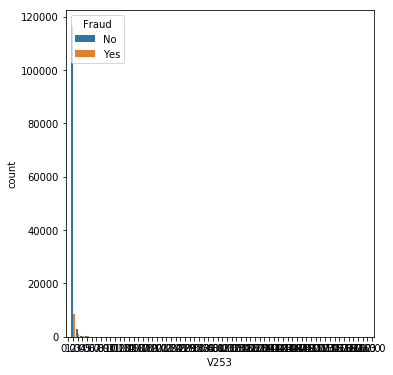

<Figure size 432x288 with 0 Axes>

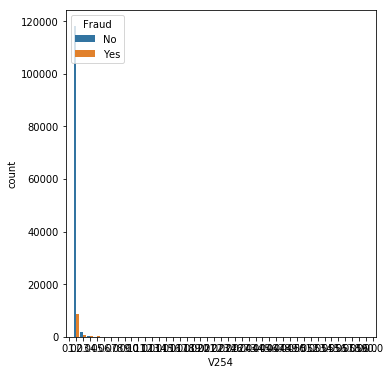

<Figure size 432x288 with 0 Axes>

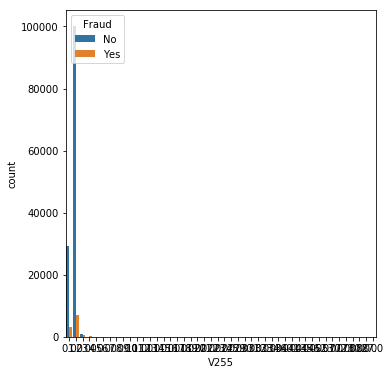

<Figure size 432x288 with 0 Axes>

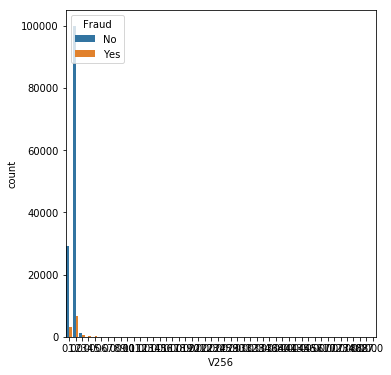

<Figure size 432x288 with 0 Axes>

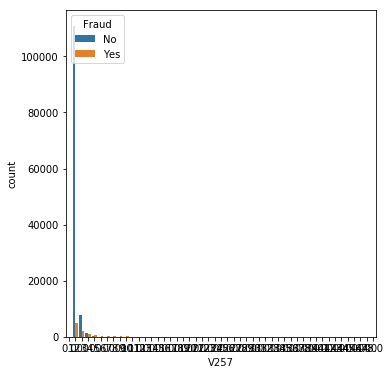

<Figure size 432x288 with 0 Axes>

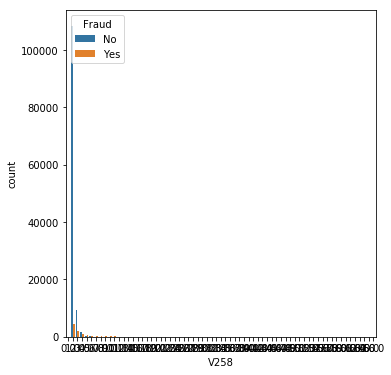

<Figure size 432x288 with 0 Axes>

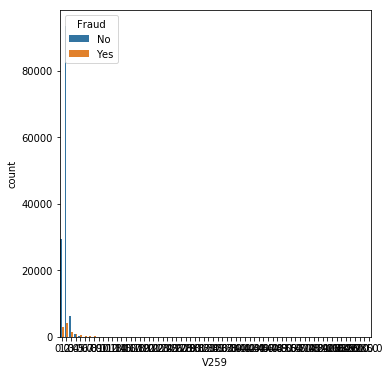

<Figure size 432x288 with 0 Axes>

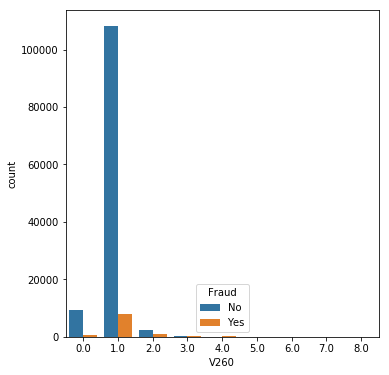

<Figure size 432x288 with 0 Axes>

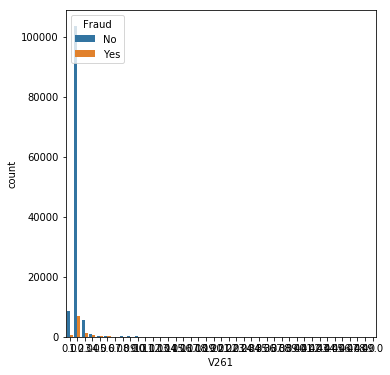

<Figure size 432x288 with 0 Axes>

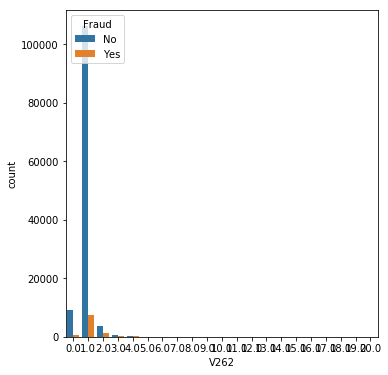

<Figure size 432x288 with 0 Axes>

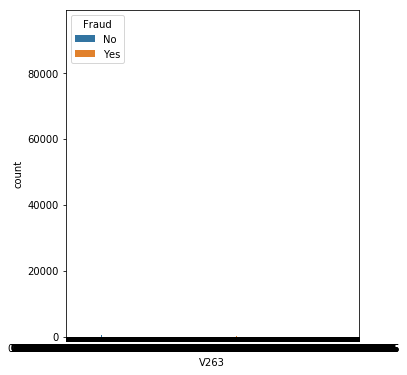

<Figure size 432x288 with 0 Axes>

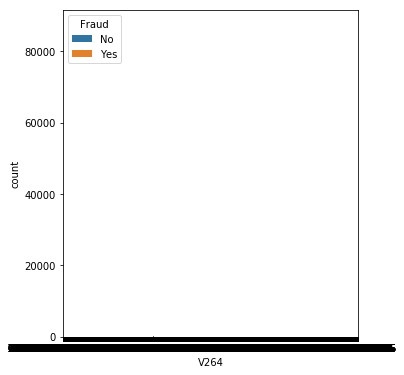

<Figure size 432x288 with 0 Axes>

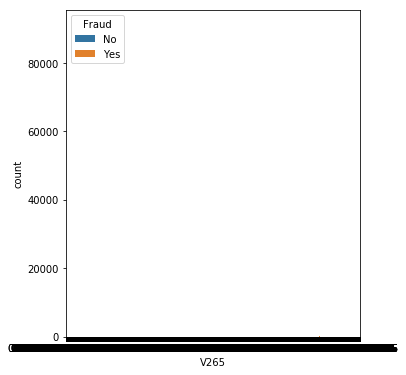

<Figure size 432x288 with 0 Axes>

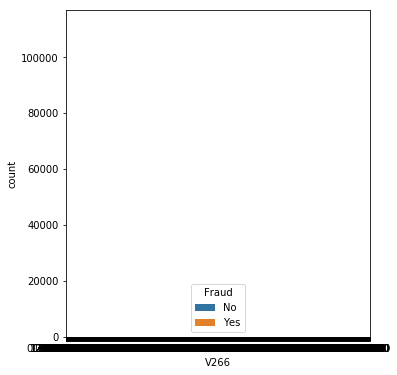

<Figure size 432x288 with 0 Axes>

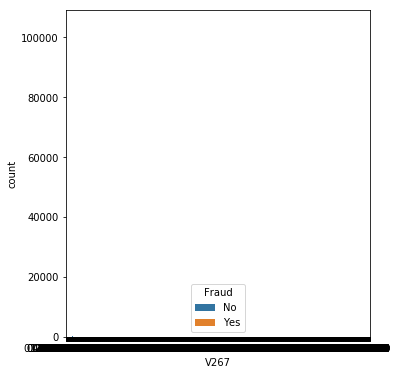

<Figure size 432x288 with 0 Axes>

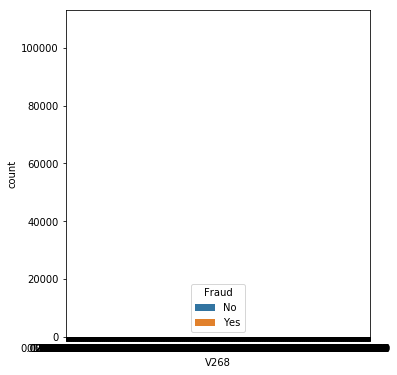

<Figure size 432x288 with 0 Axes>

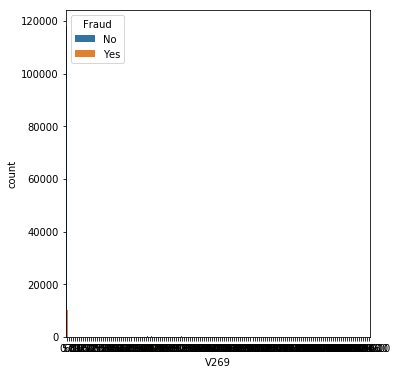

<Figure size 432x288 with 0 Axes>

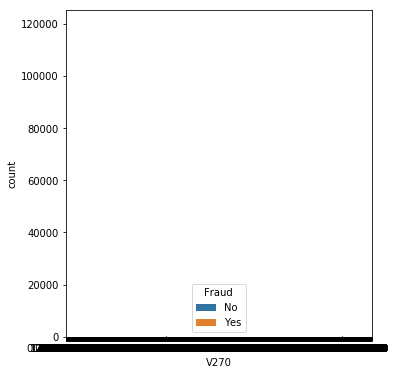

<Figure size 432x288 with 0 Axes>

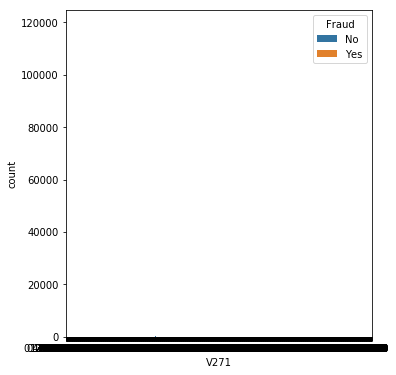

<Figure size 432x288 with 0 Axes>

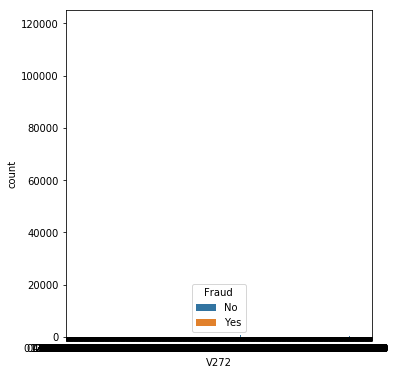

<Figure size 432x288 with 0 Axes>

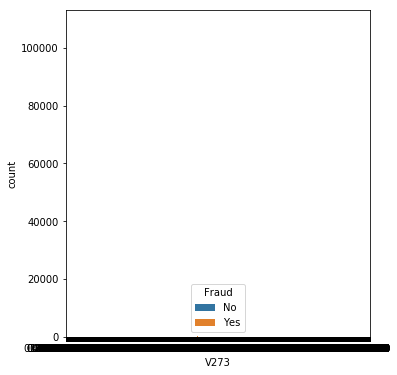

<Figure size 432x288 with 0 Axes>

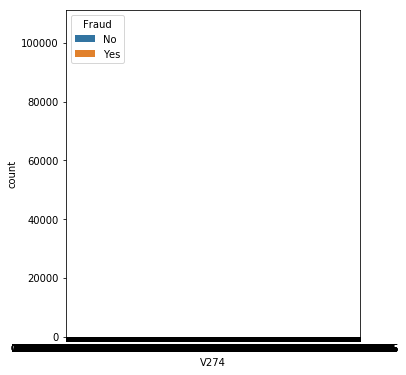

<Figure size 432x288 with 0 Axes>

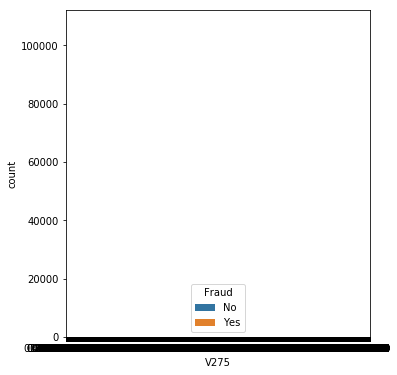

<Figure size 432x288 with 0 Axes>

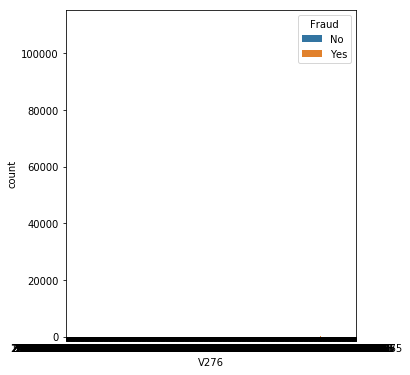

<Figure size 432x288 with 0 Axes>

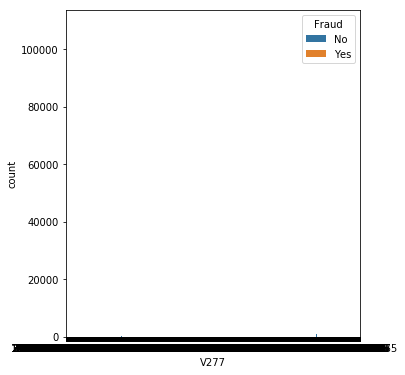

<Figure size 432x288 with 0 Axes>

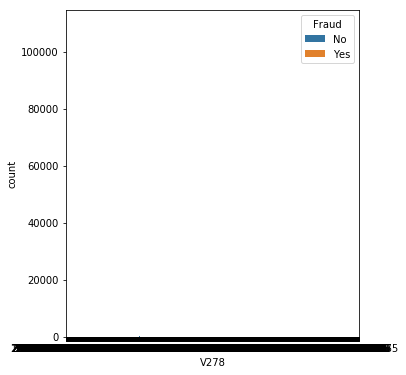

<Figure size 432x288 with 0 Axes>

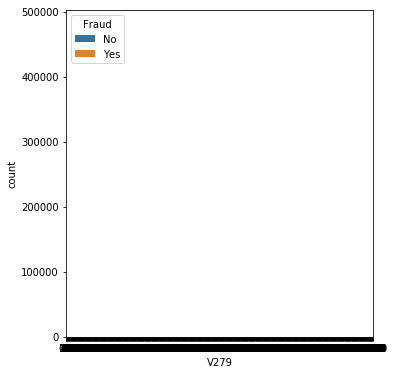

<Figure size 432x288 with 0 Axes>

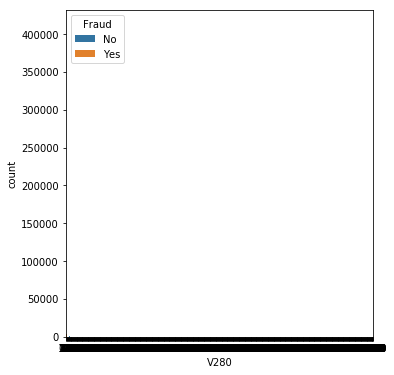

<Figure size 432x288 with 0 Axes>

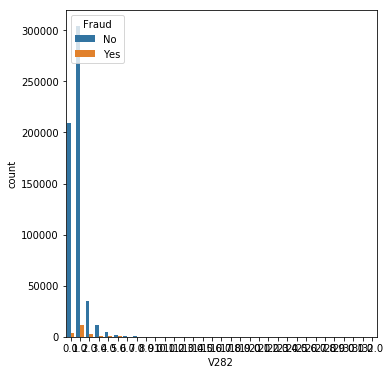

<Figure size 432x288 with 0 Axes>

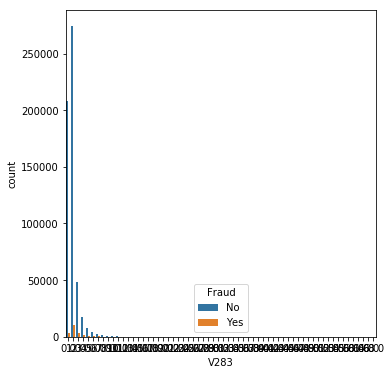

<Figure size 432x288 with 0 Axes>

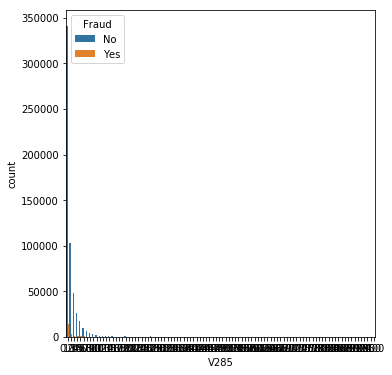

<Figure size 432x288 with 0 Axes>

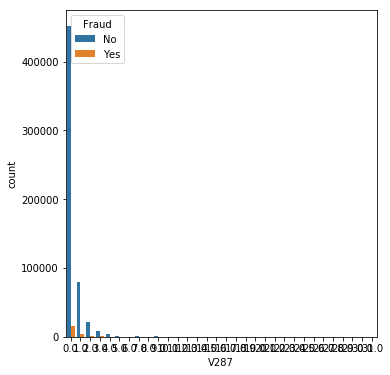

<Figure size 432x288 with 0 Axes>

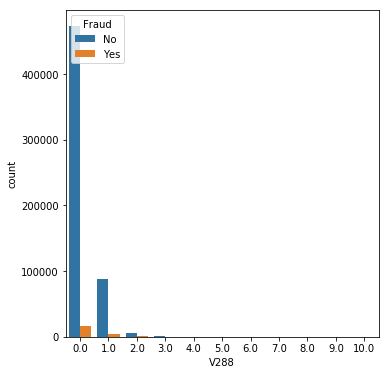

<Figure size 432x288 with 0 Axes>

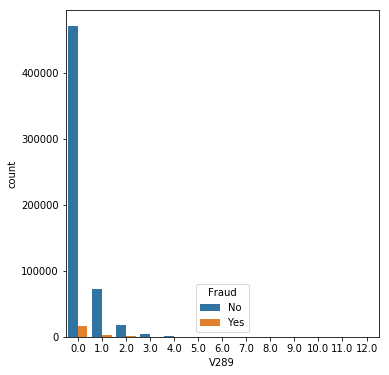

<Figure size 432x288 with 0 Axes>

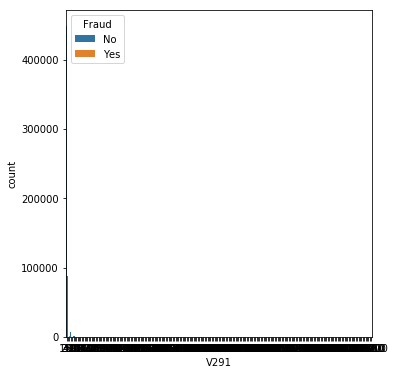

<Figure size 432x288 with 0 Axes>

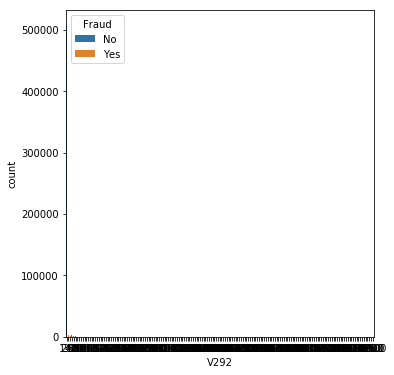

<Figure size 432x288 with 0 Axes>

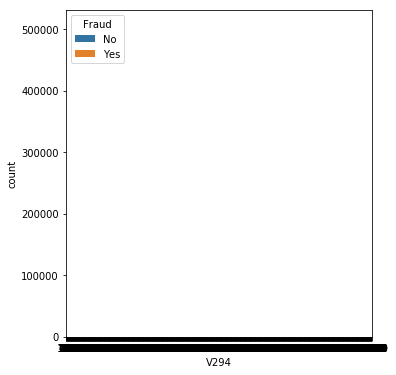

<Figure size 432x288 with 0 Axes>

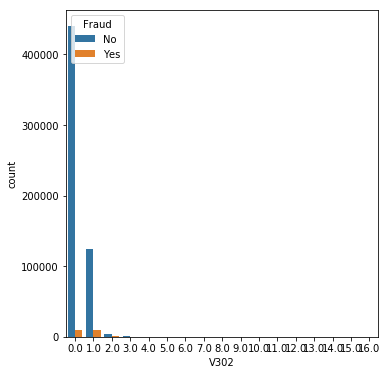

<Figure size 432x288 with 0 Axes>

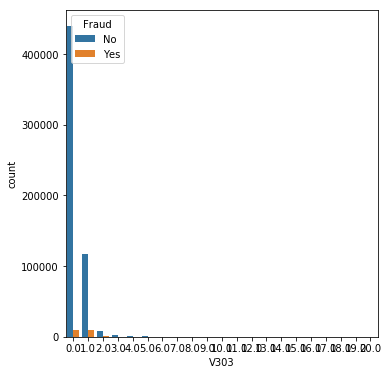

<Figure size 432x288 with 0 Axes>

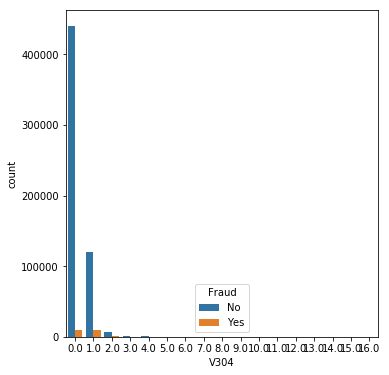

<Figure size 432x288 with 0 Axes>

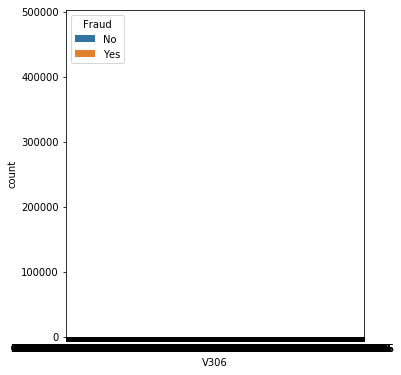

<Figure size 432x288 with 0 Axes>

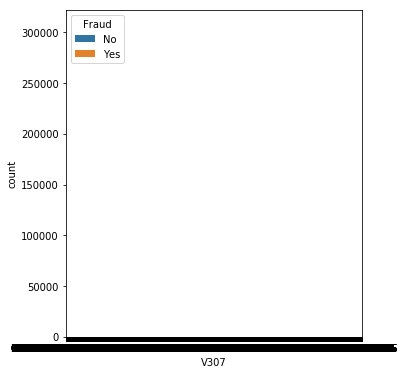

<Figure size 432x288 with 0 Axes>

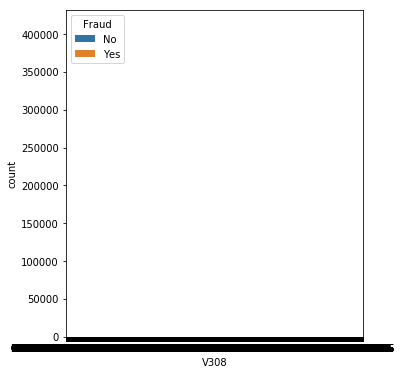

<Figure size 432x288 with 0 Axes>

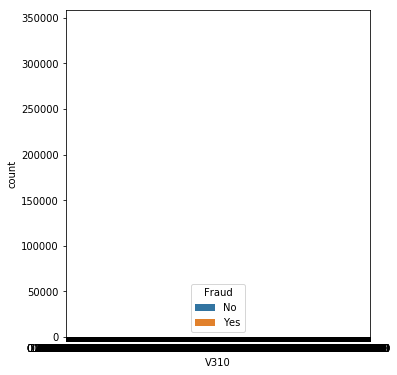

<Figure size 432x288 with 0 Axes>

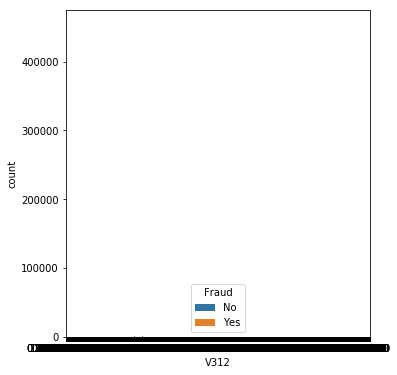

<Figure size 432x288 with 0 Axes>

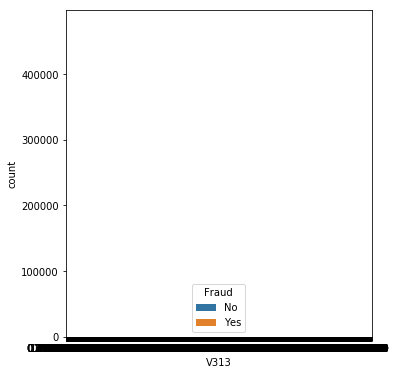

<Figure size 432x288 with 0 Axes>

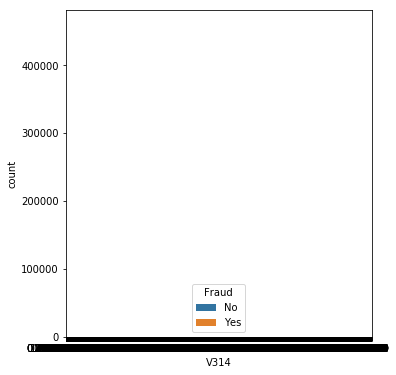

<Figure size 432x288 with 0 Axes>

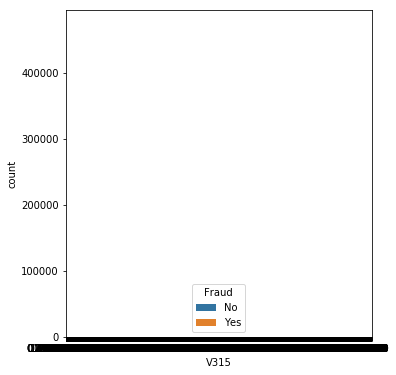

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure()
for v in v_cols:
              
        fig = plt.figure(figsize=(10,10))
        g = sns.countplot(x=v, data = df_train)
        g.set_title(v, fontsize = 22)
        g.set_ylim(0,420000)
        g.set_xlabel(v, fontsize=19)
        g.set_ylabel("Count", fontsize=17)
        plt.subplot(222)
        g1=sns.countplot(x=v, hue ='isFraud',data = df_train)
        plt.legend(title = 'Fraud', loc = 'best', labels = ['No','Yes'])
        plt.tight_layout()
        plt.show()
        plt.clf()

Almost all V variables have majority values between 0 and 5 except variables like
V37,V38,V95,V96,V97,V99,V126,V127,V128,V130,V131,V143,V145 etc

#### Checking ID variables

In [21]:
df_train[['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 
       'id_19', 'id_20',
         'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
       'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']].describe(include='all')

id_12     id_13    id_14   id_15   id_16     id_17     id_19     id_20   id_28   id_29       id_30        id_31    id_32      id_33           id_34   id_35   id_36   id_37   id_38
count     144233  127320.0  80044.0  140985  129340  139369.0  139318.0  139261.0  140978  140978       77565       140282  77586.0      73289           77805  140985  140985  140985  140985
unique         2       NaN      NaN       3       2       NaN       NaN       NaN       2       2          75          130      NaN        260               4       2       2       2       2
top     NotFound       NaN      NaN   Found   Found       NaN       NaN       NaN   Found   Found  Windows 10  chrome 63.0      NaN  1920x1080  match_status:2       T       F       T       F
freq      123025       NaN      NaN   67728   66324       NaN       NaN       NaN   76232   74926       21155        22000      NaN      16874           60011   77814  134066  110452   73922
mean         NaN       NaN      NaN     NaN     NaN       NaN       NaN       NaN     NaN     NaN         NaN          NaN      NaN        NaN             NaN     NaN     NaN     NaN     NaN
std          NaN       0.0      NaN     NaN     NaN       0.0       NaN       NaN     NaN     NaN         NaN          NaN      0.0        NaN             NaN     NaN     NaN     NaN     NaN
min          NaN      10.0   -660.0     NaN     NaN     100.0     100.0     100.0     NaN     NaN         NaN          NaN      0.0        NaN             NaN     NaN     NaN     NaN     NaN
25%          NaN      49.0   -360.0     NaN     NaN     166.0     266.0     256.0     NaN     NaN         NaN          NaN     24.0        NaN             NaN     NaN     NaN     NaN     NaN
50%          NaN      52.0   -300.0     NaN     NaN     166.0     341.0     472.0     NaN     NaN         NaN          NaN     24.0        NaN             NaN     NaN     NaN     NaN     NaN
75%          NaN      52.0   -300.0     NaN     NaN     225.0     427.0     533.0     NaN     NaN         NaN          NaN     32.0        NaN             NaN     NaN     NaN     NaN     NaN
max          NaN      64.0    720.0     NaN     NaN     229.0     671.0     661.0     NaN     NaN         NaN          NaN     32.0        NaN             NaN     NaN     NaN     NaN     NaN

### Transaction Amounts

In [23]:
df_train['TransactionAmt'] = df_train['TransactionAmt'].astype(float)
print("Transaction Amounts Quantiles:")
print(df_train['TransactionAmt'].quantile([.01, .025, .1, .25, .5, .75, .9, .975, .99]))

Transaction Amounts Quantiles:
0.010       9.242188
0.025      14.500000
0.100      25.953125
0.250      43.312500
0.500      68.750000
0.750     125.000000
0.900     275.250000
0.975     648.262500
0.990    1104.000000
Name: TransactionAmt, dtype: float64


### Mapping Emails

In [13]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 
          'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft',
          'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 
          'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink',
          'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other',
          'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 
          'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo',
          'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft',
          'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 
          'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 
          'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 
          'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other',
          'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}


us_emails = ['gmail', 'net', 'edu']
for c in ['P_emaildomain', 'R_emaildomain']:
    df_train[c + '_bin'] = df_train[c].map(emails)
    df_test[c + '_bin'] = df_test[c].map(emails)
    
    df_train[c + '_suffix'] = df_train[c].map(lambda x: str(x).split('.')[-1])
    df_test[c + '_suffix'] = df_test[c].map(lambda x: str(x).split('.')[-1])
    
    df_train[c + '_suffix'] = df_train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    df_test[c + '_suffix'] = df_test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

### Encoding Categorical variables

In [16]:
# Label Encoding
for f in df_train.drop('isFraud', axis=1).columns:
    if df_train[f].dtype=='object' or df_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df_train[f].values) + list(df_test[f].values))
        df_train[f] = lbl.transform(list(df_train[f].values))
        df_test[f] = lbl.transform(list(df_test[f].values))   


In [28]:
df_train.head()

TransactionID  isFraud  TransactionDT  TransactionAmt  ProductCD  card1  card2  card3  card4  card5  card6  addr1  addr2  dist1  P_emaildomain  R_emaildomain   C1   C2   C4   C5   C6   C7   C8   C9  C10  C11  C12   C13  C14     D1     D2    D3    D4   D5  D6  D8  D9   D10    D11  D12  D13  D14    D15  M1  M2  M3  M4  M5  M6  M7  M8  M9   V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  V15  V16  V17  V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  V30  V31  V32  V33  V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  V44  V45  V46  V47  V48  V49  V50  V51  V52  V53  V54  V55  V56  V57  V58  V59  V60  V61  V62  V63  V64  V65  V66  V67  V68  V69  V70  V71  V72  V73  V74  V75  V76  V77  V78  V79  V80  V81  V82  V83  V84  V85  V86  V87  V88  V89  V90  V91  V92  V93  V94  V95   V96   V97   V99  V100  V126    V127   V128   V130   V131  V138  V139  V140  V141  V142  V143  V144   V145  V146  V147  V148  V149    V150  V151  V152  V153  V154  V155  V156  V157  \
0        2987000        0          86400            68.5          4  13926    NaN  150.0      1  142.0      1  315.0   87.0   19.0             32             32  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  2.0  0.0   1.0  1.0   14.0    NaN  13.0   NaN  NaN NaN NaN NaN  13.0   13.0  NaN  NaN  NaN    0.0   1   1   1   2   0   1   2   2   2  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   1.0   0.0   0.0   0.0   0.0   117.0    0.0    0.0    0.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1        2987001        0          86401            29.0          4   2755  404.0  150.0      2  102.0      1  325.0   87.0    NaN             16             32  1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN   0.0    NaN  NaN  NaN  NaN    0.0   2   2   2   0   1   1   2   2   2  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0     0.0    0.0    0.0    0.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2        2987002        0          86469            59.0          4   4663  490.0  150.0      4  166.0      2  330.0   87.0  287.0             36             32  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN   0.0  315.0  NaN  NaN  NaN  315.0   1   1   1   0   0   0   0   0   0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0     0.0    0.0    0.0    0.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

In [29]:
df_test.head()

TransactionID  TransactionDT  TransactionAmt  ProductCD  card1  card2  card3  card4  card5  card6  addr1  addr2   dist1  P_emaildomain  R_emaildomain   C1   C2   C4   C5   C6   C7   C8   C9  C10  C11  C12    C13  C14     D1     D2    D3     D4    D5  D6  D8  D9    D10    D11  D12  D13  D14    D15  M1  M2  M3  M4  M5  M6  M7  M8  M9   V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  V15  V16  V17  V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  V30  V31  V32  V33  V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  V44  V45  V46  V47  V48  V49  V50  V51  V52  V53  V54  V55  V56  V57  V58  V59  V60  V61  V62  V63  V64  V65  V66  V67  V68  V69  V70  V71  V72  V73  V74  V75  V76  V77  V78  V79  V80  V81  V82  V83  V84  V85  V86  V87  V88  V89  V90  V91  V92  V93  V94  V95  V96  V97  V99  V100       V126        V127       V128        V130       V131  V138  V139  V140  V141  V142  V143  V144  V145  V146  V147  V148  V149  V150  V151  V152  V153  V154  V155  \
0        3663549       18403224       31.953125          4  10409  111.0  150.0      4  226.0      2  170.0   87.0     1.0             16             32  6.0  6.0  0.0  3.0  4.0  0.0  0.0  6.0  0.0  5.0  1.0  115.0  6.0  419.0  419.0  27.0  398.0  27.0 NaN NaN NaN  418.0  203.0  NaN  NaN  NaN  409.0   1   1   0   3   2   0   1   1   1  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0   0.0   0.000000   47.950001   0.000000   47.950001   0.000000   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1        3663550       18403263       49.000000          4   4272  111.0  150.0      4  226.0      2  299.0   87.0     4.0              2             32  3.0  2.0  0.0  0.0  1.0  0.0  0.0  2.0  0.0  1.0  1.0   12.0  2.0  149.0  149.0   7.0  634.0   7.0 NaN NaN NaN  231.0  634.0  NaN  NaN  NaN  634.0   1   0   0   0   2   0   2   2   2  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  4.0  1.0  4.0   1.0   0.000000  280.000000  77.000000  280.000000  77.000000   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2        3663551       18403310      171.000000          4   4476  574.0  150.0      4  226.0      2  472.0   87.0  2636.0             19             32  2.0  2.0  0.0  0.0  5.0  0.0  0.0  4.0  0.0  2.0  0.0   22.0  2.0  137.0  137.0  10.0   97.0  10.0 NaN NaN NaN  136.0  136.0  NaN  NaN  NaN   97.0   1   1   0   0   0   0   0   0   0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  2.0  2.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  2.0  1.0  2.0  0.0  0.0  0.0  1.0  2.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  5.0  0.0  3.0   0.0   0.000000  968.000000   0.000000  705.000000   0.000000   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

### Filling Missing Values

In [17]:
df_train.fillna(value=-999, inplace=True)
df_test.fillna(value=-999, inplace=True)

### Creating Training and testing data sets

In [ ]:
X_train = df_train.sort_values('TransactionDT').drop(['isFraud','TransactionDT','TransactionID'],axis=1)
y_train = df_train.sort_values('TransactionDT')['isFraud'].astype(bool)

X_test = df_test.sort_values('TransactionDT').drop(['TransactionDT','TransactionID'],axis=1)


#del df_train

### Deleteing original Training data to save memory

In [ ]:
del df_train

### Training The logistic regression model 

In [21]:
clf = LogisticRegression(random_state=666, solver='lbfgs',\
                         multi_class='ovr', verbose=1, n_jobs=-1)\
                         .fit(X_train, y_train)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   41.1s finished


### Checking the model coefficients

In [43]:
clf.coef_

array([[ 2.31592812e-04, -1.61843544e-06, -2.87513930e-05,
        -3.21889558e-04, -3.53731429e-05, -9.91099982e-07,
        -1.07317883e-04, -2.07685740e-06, -2.48504290e-04,
        -1.54121430e-04,  1.66524520e-04, -9.36526532e-06,
        -8.61258976e-06,  1.12394611e-04,  1.61895516e-04,
         4.33452448e-05, -1.86757369e-05,  3.16622122e-05,
         3.71440835e-05,  7.03441441e-05, -1.01664977e-05,
         5.13717475e-05,  6.48186022e-05,  6.79143420e-05,
        -5.51509237e-05,  2.93948985e-07, -3.34631319e-04,
        -5.51220586e-04,  1.27739230e-04, -3.24534263e-04,
         6.01578128e-04,  1.53768119e-04,  3.36068523e-04,
         6.28480535e-04, -2.17771147e-04, -2.19666134e-04,
         4.65033372e-04,  7.14509763e-05,  3.53344826e-04,
        -3.70923938e-04, -5.20989624e-07, -7.03342392e-07,
        -7.53647797e-07, -4.59499473e-06, -2.41070702e-06,
        -1.13415189e-06, -2.47570335e-07, -5.05015045e-07,
        -7.14483340e-07,  8.84275716e-06,  8.90154204e-0

### Using the trained model to predict the values for testing data

In [56]:
Predicted_probabilities = pd.DataFrame(clf.predict_proba(X_test))

### Creating Submission file

In [59]:
submission = pd.DataFrame()
submission['TransactionID'] = df_test['TransactionID']
submission['isFraud'] = Predicted_probabilities[1]


In [60]:
submission.head()

TransactionID   isFraud
0        3663549  0.010731
1        3663550  0.033520
2        3663551  0.014268
3        3663552  0.026299
4        3663553  0.008072

In [64]:
submission.to_csv("submission.csv", index=False)